<a href="https://colab.research.google.com/github/VHKA1729/air-pollution/blob/master/vhka1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<font size="20"><h3 align='center'>**_DSL Project_**</font><br>
    
    
<font size="5"><h3 align='center'><span style='color:Blue'> Predict impact of air quality on mortality rates(Kaggle Competition)</font>


<font size="3"><h3 align='center'>https://www.kaggle.com/c/predict-impact-of-air-quality-on-death-rates/overview</font><br>
    <br>


<font size="3">**Group Number - 2**<br>
<font size="3"> Mimansi Agarwal   &emsp;19BM6JP15</font>        
<font size="3"> Vaibhav HK Anand  &emsp;19BM6JP24</font>    
<font size="3"> Bankar Prasad Vilas &emsp;19BM6JP25</font> 


## TO DO

- ANOVA on variables per region
- XGB Regressor
- Best depth via cost pruning for RFR
- Graphs for regulartization 

# Libraries

In [0]:
#!pip install impyute

In [0]:
SEED = 1729

In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import  make_scorer, mean_absolute_error, r2_score, median_absolute_error, mean_squared_error
import math
from sklearn.impute import KNNImputer

import missingno as msno

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import gc
import random
import os

import scipy.stats as sps 

In [0]:
#plt.style.available

In [0]:
plt.style.use('fivethirtyeight')

# Functions

In [10]:
def seed_everything(SEED=1729):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    print('done')

seed_everything()

done


In [0]:
def f(x):
  if (x<=0):
    return(np.nan)
  else:
    return(x)

In [0]:
def reduce_mem_usage(df, verbose=True):
    '''
    Reduces the usage of memory by a dataframe
    '''
    start_mem = df.memory_usage().sum() / 2**20
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] #defining a list of numeric types
    #start_mem = df.memory_usage().sum() / 2**20   #converting bytes into MB
    for col in df.columns: # iterating over each column of dataframe
        col_type = df[col].dtypes # extracting the data type of a single column
        if col_type in numerics: # checking whether the data type of column is a numeric datatype or not
            c_min = df[col].min()
            c_max = df[col].max()
          
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype('float16')
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype('float32')
            else:
                df[col] = df[col].astype('float64')    
    end_mem = df.memory_usage().sum() / 2**20
    if verbose: print('Mem. usage decreased to {:5.5f} Mb ({:.2f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def reg_metrics (y_true,y_predicted):
  mse = mean_squared_error(y_true,y_predicted)
  print("MSE = " + str(mse))
  print("RMSE =" + str(math.sqrt(mse)))
  print("Mean Absolute Error =" + str(mean_absolute_error(y_true,y_predicted)))
  print('Median Absolute Error  = ' + str(median_absolute_error(y_true, y_predicted)))
  print('R^2                    = ' + str(r2_score(y_true, y_predicted)))
  del mse
  gc.collect()

In [0]:
def resid_plot(y_true, y_predicted):
    '''
    1. Plots residual plots by taking the y_true and y_predicted as input.
    2. Can be used with any regression method be it linear, ridge, lasso, boosting-based, etc.
    '''
    temp1 = np.array(y_true).reshape(-1,1)
    temp2 = np.array(y_predicted).reshape(-1,1)

    resids = np.subtract(temp1,temp2) #calculating residuals

    sns.regplot(x=y_predicted, y=resids, fit_reg=True)

    plt.title("Residuals vs. Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")

    plt.show()
    plt.close()
    del temp1, temp2
    gc.collect()

In [0]:
def resids_hist(y_true,y_predicted):
  '''
  Plots histogram of residuals
  '''

  temp1 = np.array(y_true).reshape(-1,1)
  temp2 = np.array(y_predicted).reshape(-1,1)

  resids = np.subtract(temp1,temp2) 

  sns.distplot(resids)

  plt.title("Histogram of Residual Values")
  plt.xlabel("Residuals")
  plt.ylabel("Count")
  del temp1, temp2
  gc.collect()

In [0]:
def resid_qq(y_true, y_predicted):
    resids = np.subtract(np.array(y_true).reshape(-1,1),  np.array(y_predicted).reshape(-1,1))
    sps.probplot(resids.flatten(), plot = plt)
    plt.title('Q-Q Plot of residuals')
    plt.xlabel('Quantiles of standard Normal distribution')
    plt.ylabel('Quantiles of residuals')
    plt.show()

## Regularization

In [0]:
def plot_regularization(l, train_RMSE, test_RMSE, coefs, min_idx, title):   
    plt.plot(l, test_RMSE, color = 'green', label = 'Test RMSE')
    plt.plot(l, train_RMSE, label = 'Train RMSE')    
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.legend()
    plt.xlabel('Regularization parameter')
    plt.ylabel('Root Mean Square Error')
    plt.title(title)
    plt.show()
    
    plt.plot(l, coefs)
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.title('Model coefficient values \n vs. regularizaton parameter')
    plt.xlabel('Regularization parameter')
    plt.ylabel('Model coefficient value')
    plt.show()

In [0]:
def test_regularization_l2(x_train, y_train, x_test, y_test, l2):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l2:
        lin_mod = Ridge(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(mean_squared_error(y_train, y_score_train)**0.5)
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(mean_squared_error(y_test, y_score)**0.5)
    min_idx = np.argmin(test_RMSE)
    min_l2 = l2[min_idx]
    min_RMSE = test_RMSE[min_idx] 
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l2, train_RMSE, test_RMSE, coefs, min_l2, title)
    return min_l2, min_RMSE

In [0]:
def ridge(X_train,y_train, X_test, y_test):
  l2 = [x for x in range(0,50)]
  out_l2 = test_regularization_l2(X_train, y_train, X_test, y_test, l2)
  print(out_l2)
  lin_mod_l2 = Ridge(alpha = out_l2[0])
  lin_mod_l2.fit(X_train, y_train)
  y_score_l2 = lin_mod_l2.predict(X_test)
  print()
  reg_metrics(y_test, y_score_l2)
  resids_hist(np.array(y_test), np.array(y_score_l2))  
  resid_qq(np.array(y_test), np.array(y_score_l2)) 
  resid_plot(np.array(y_test), np.array(y_score_l2))

In [0]:
def test_regularization_l1(x_train, y_train, x_test, y_test, l1):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l1:
        lin_mod = Lasso(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(mean_squared_error(y_train, y_score_train)**0.5)
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(mean_squared_error(y_test, y_score)**0.5)
    min_idx = np.argmin(test_RMSE)
    min_l1 = l1[min_idx]
    min_RMSE = test_RMSE[min_idx]
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l1, train_RMSE, test_RMSE, coefs, min_l1, title)
    return min_l1, min_RMSE

In [0]:
def lasso(X_train,y_train,X_test,y_test):
    l1 = [x/5000 for x in range(1,50)]
    out_l1 = test_regularization_l1(X_train, y_train, X_test, y_test, l1)
    print(out_l1)
    lin_mod_l1 = Lasso(alpha = out_l1[0])
    lin_mod_l1.fit(X_train, y_train)
    y_score_l1 = lin_mod_l1.predict(X_test)
    print()
    reg_metrics(y_test, y_score_l1) 
    resids_hist(np.array(y_test), np.array(y_score_l1))
    resid_qq(np.array(y_test), np.array(y_score_l1)) 
    resid_plot(np.array(y_test), np.array(y_score_l1))

# Data import

In [0]:
train = pd.read_csv('/content/train.csv', parse_dates=['date'], index_col='Id')
test = pd.read_csv('/content/test.csv', parse_dates=['date'], index_col='Id')
region=pd.read_csv('/content/regions.csv')

In [23]:
train.head()

region       date  mortality_rate      O3   PM10  PM25  NO2      T2M
Id                                                                         
1   E12000001 2007-01-02           2.264  42.358  9.021   NaN  NaN  278.138
2   E12000001 2007-01-03           2.030  49.506  5.256   NaN  NaN  281.745
3   E12000001 2007-01-04           1.874  51.101  4.946   NaN  NaN  280.523
4   E12000001 2007-01-05           2.069  47.478  6.823   NaN  NaN  280.421
5   E12000001 2007-01-06           1.913  45.226  7.532   NaN  NaN  278.961

# Exploratory data analysis

In [24]:
region

Code                    Region
0  E12000001                North East
1  E12000002                North West
2  E12000003  Yorkshire and The Humber
3  E12000004             East Midlands
4  E12000005             West Midlands
5  E12000006           East of England
6  E12000007                    London
7  E12000008                South East
8  E12000009                South West

In [25]:
# Checking that the date column is monotonic
for r in train['region'].unique():
  print(train[train['region']==r]['date'].is_monotonic)
del r

True
True
True
True
True
True
True
True
True


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18403 entries, 1 to 18403
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   region          18403 non-null  object        
 1   date            18403 non-null  datetime64[ns]
 2   mortality_rate  18403 non-null  float64       
 3   O3              18394 non-null  float64       
 4   PM10            18394 non-null  float64       
 5   PM25            15127 non-null  float64       
 6   NO2             11833 non-null  float64       
 7   T2M             18403 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.3+ MB


In [27]:
train.describe()

mortality_rate            O3  ...           NO2           T2M
count    18403.000000  18394.000000  ...  11833.000000  18403.000000
mean         1.301737     45.325857  ...     12.045813    283.002235
std          0.304161     16.221330  ...      8.296675      5.182186
min          0.439000      0.988000  ...      1.104000    265.562000
25%          1.102000     35.074250  ...      6.056000    279.321500
50%          1.281000     45.836000  ...      9.769000    283.270000
75%          1.474000     55.881000  ...     15.858000    287.240500
max          2.841000    105.693000  ...     76.765000    297.209000

[8 rows x 6 columns]

In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7886 entries, 18404 to 26289
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   region  7886 non-null   object        
 1   date    7886 non-null   datetime64[ns]
 2   O3      7886 non-null   float64       
 3   PM10    7886 non-null   float64       
 4   PM25    7886 non-null   float64       
 5   NO2     7886 non-null   float64       
 6   T2M     7886 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 492.9+ KB


In [29]:
test.describe()

O3         PM10         PM25          NO2          T2M
count  7886.000000  7886.000000  7886.000000  7886.000000  7886.000000
mean     49.527998    14.545470     8.749311    13.140902   283.410366
std      16.086797     7.660908     6.437121     8.848008     5.274034
min       1.559000     2.506000     0.850000     1.386000   268.696000
25%      39.843000     9.467250     4.620250     6.732750   279.458500
50%      50.935500    12.364000     6.810000    10.627500   283.518000
75%      60.379000    17.353750    10.872000    16.864750   287.707250
max     103.718000    67.361000    56.717000    67.063000   296.740000

In [30]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Code    9 non-null      object
 1   Region  9 non-null      object
dtypes: object(2)
memory usage: 272.0+ bytes


## Missing Values

In [31]:
train.isna().sum()

region               0
date                 0
mortality_rate       0
O3                   9
PM10                 9
PM25              3276
NO2               6570
T2M                  0
dtype: int64

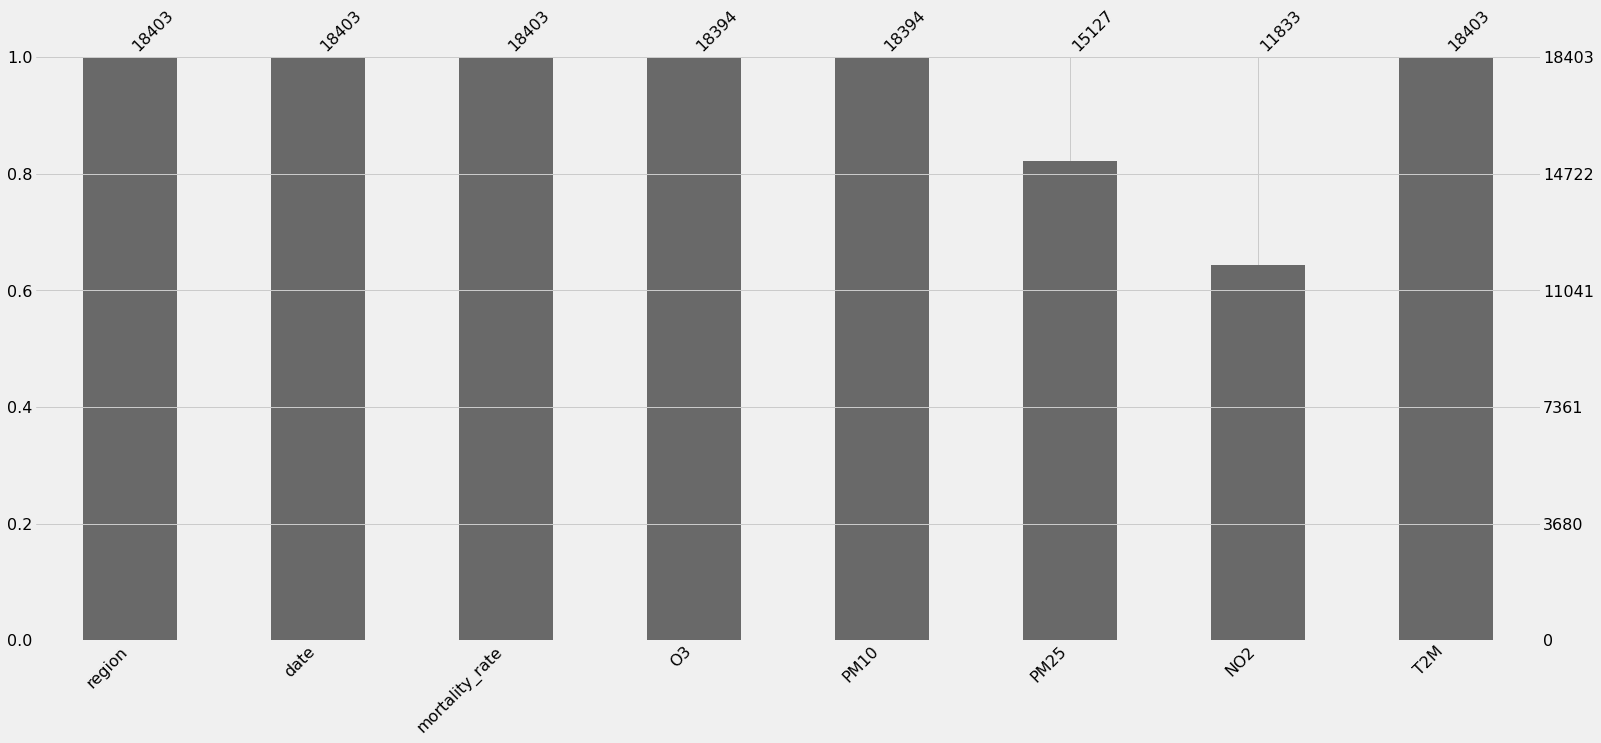

In [32]:
msno.bar(train)

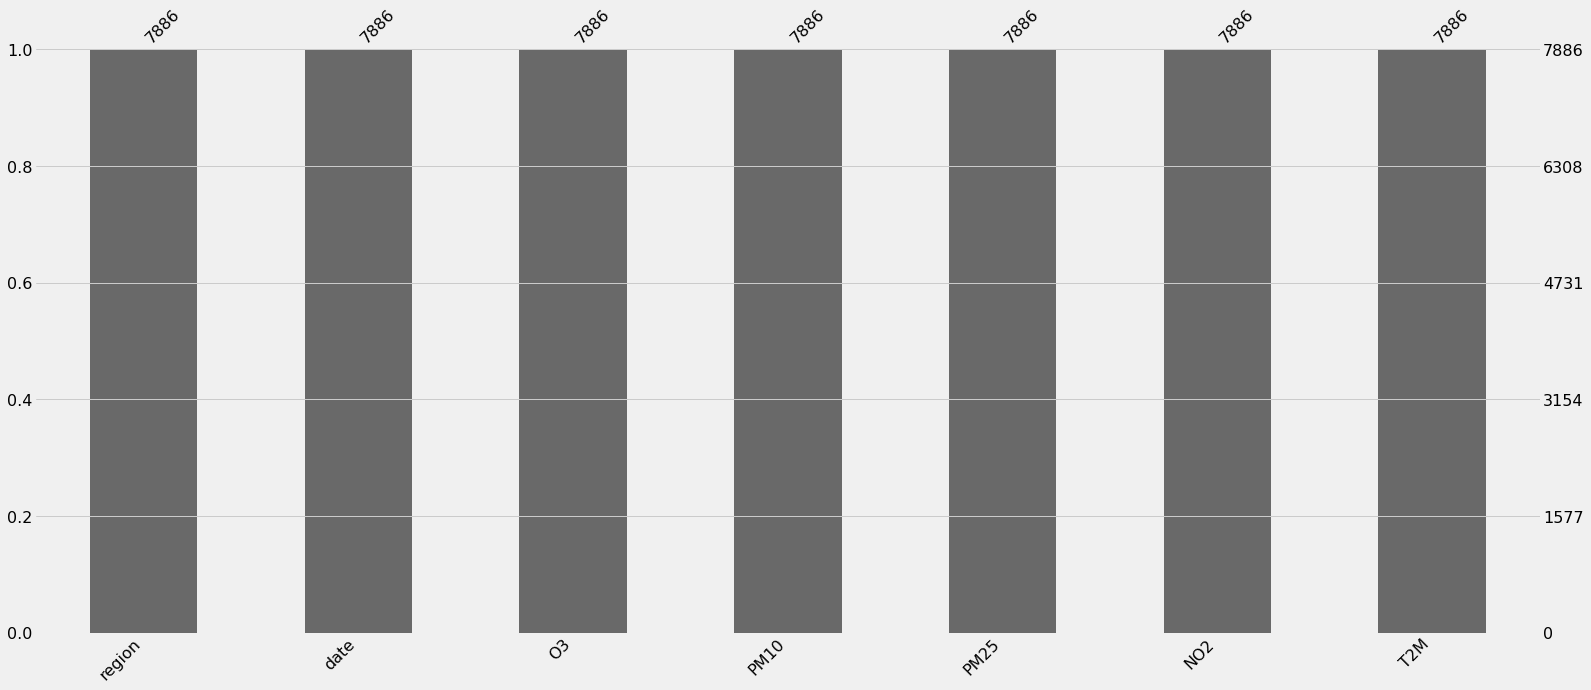

In [33]:
msno.bar(test)

# No missing values

AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)


5

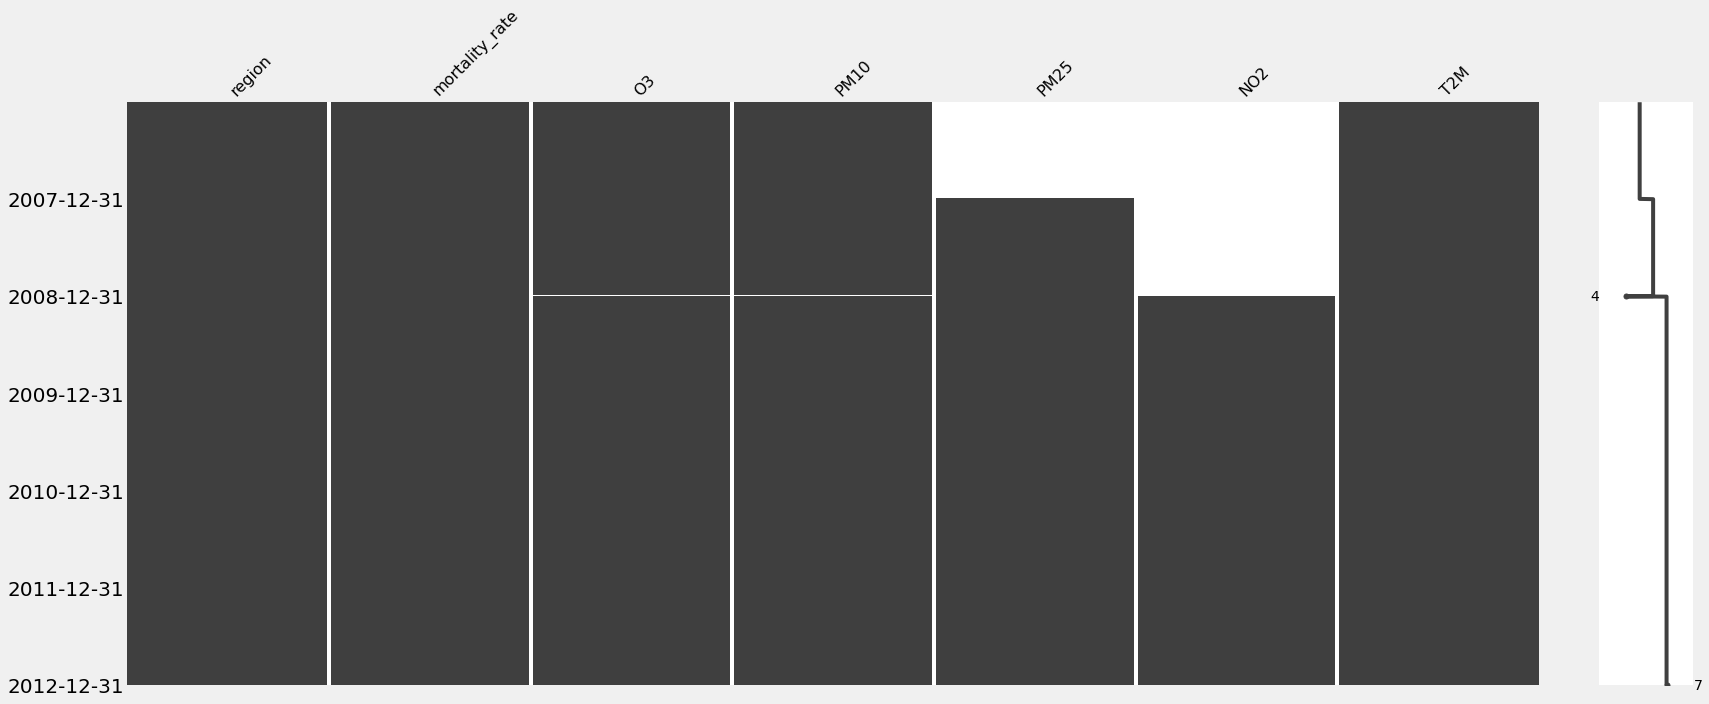

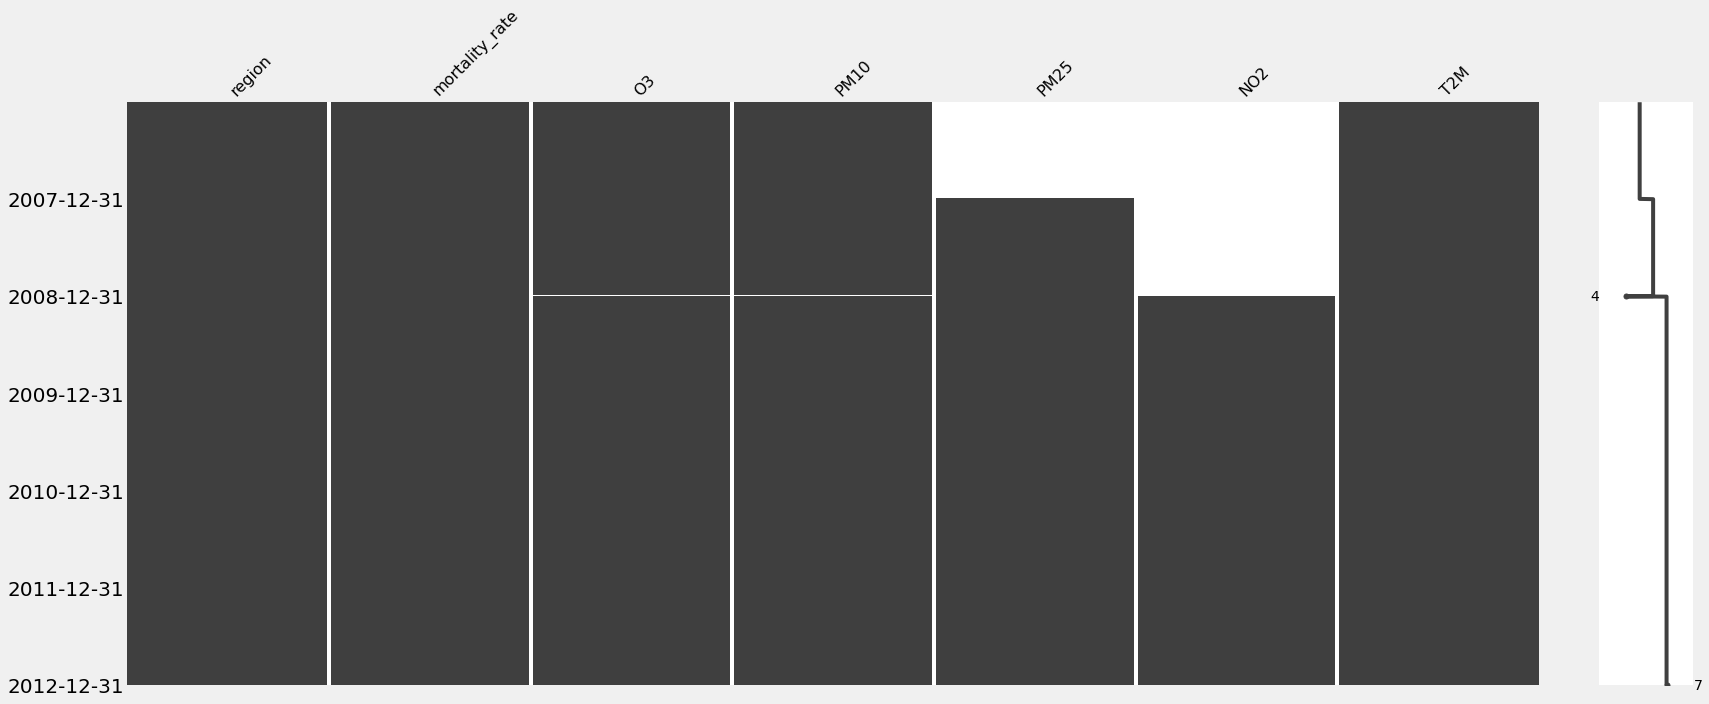

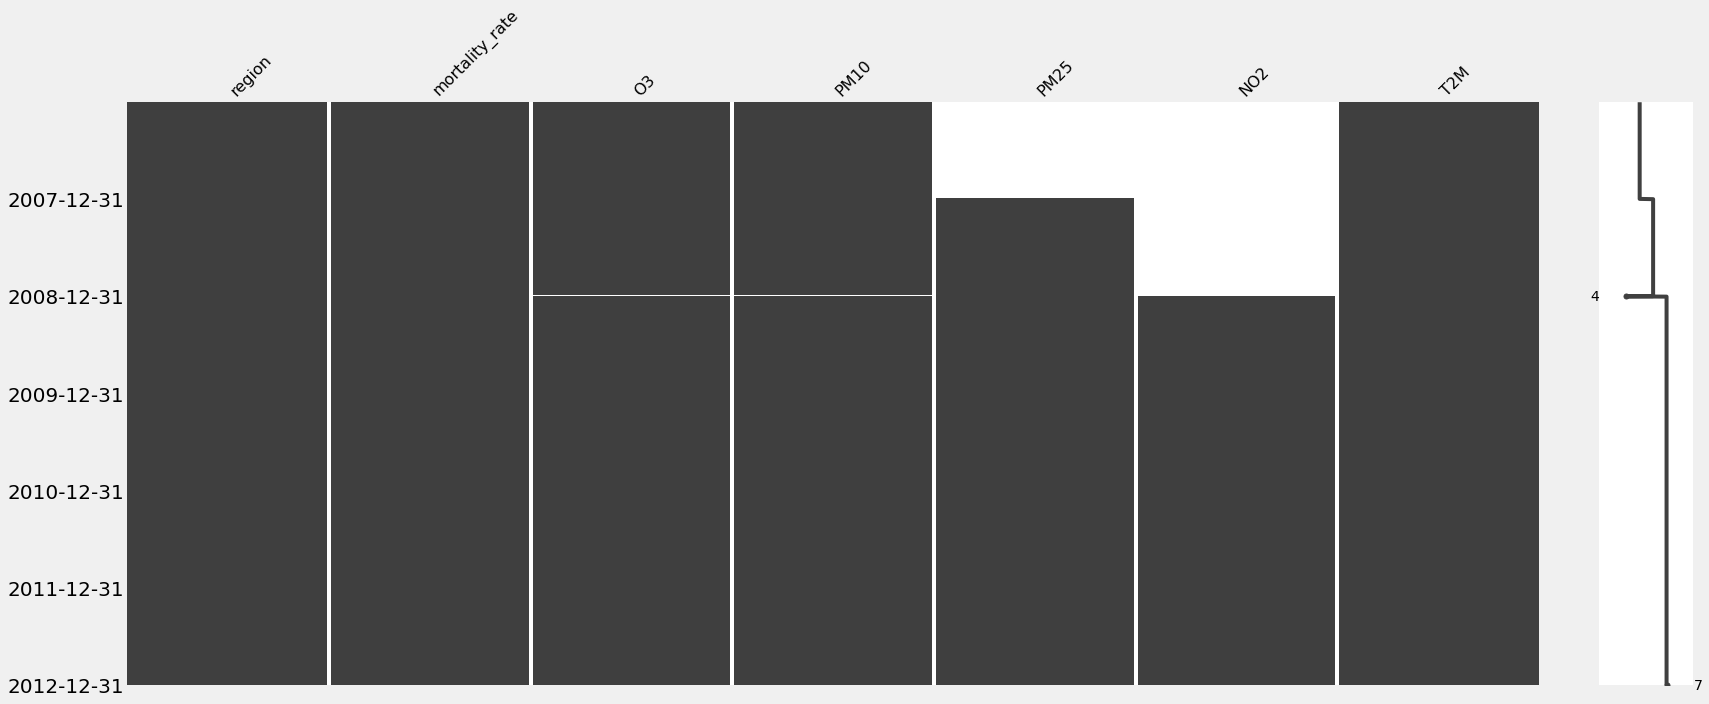

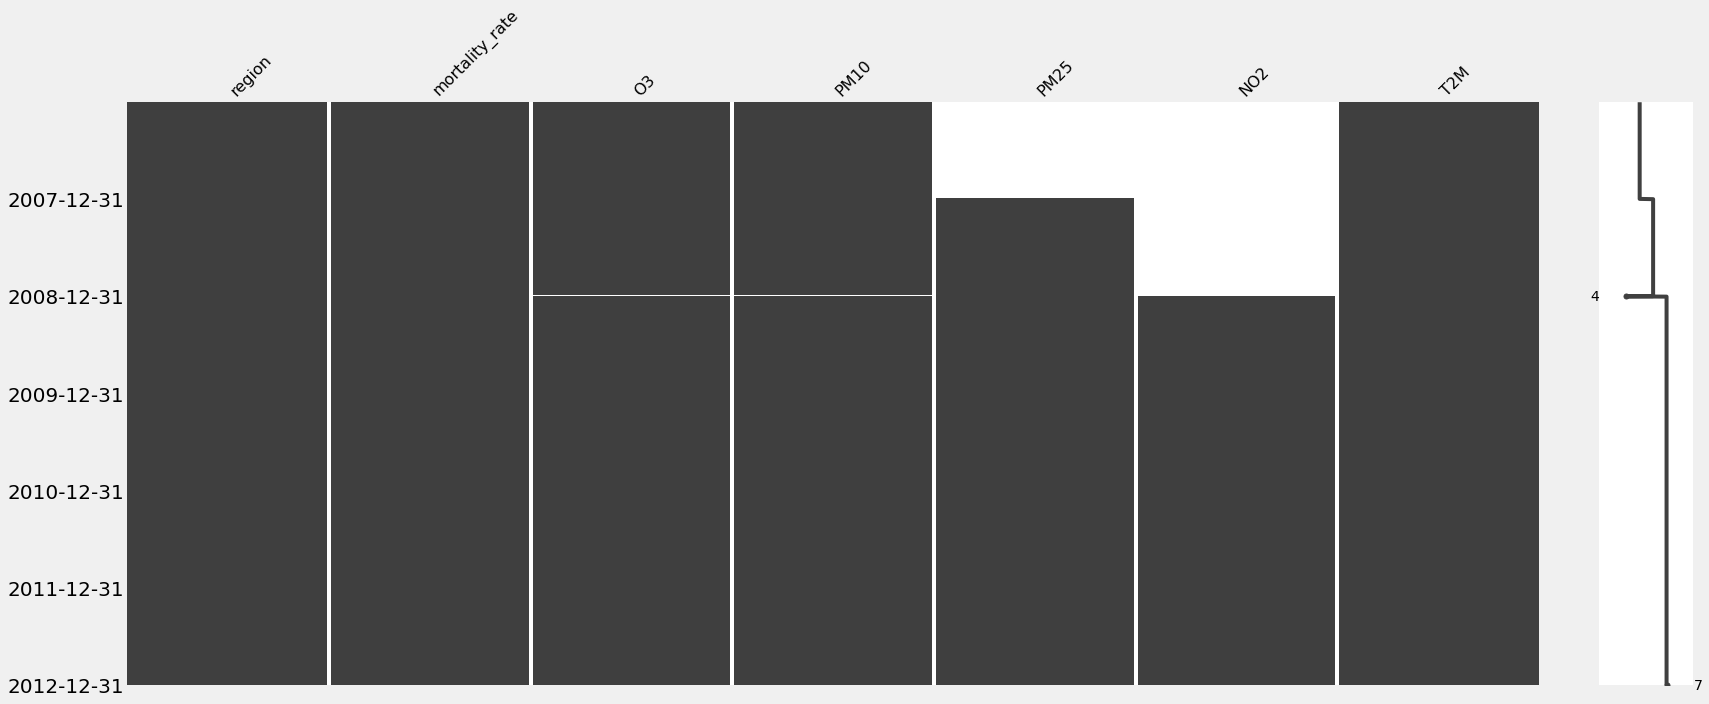

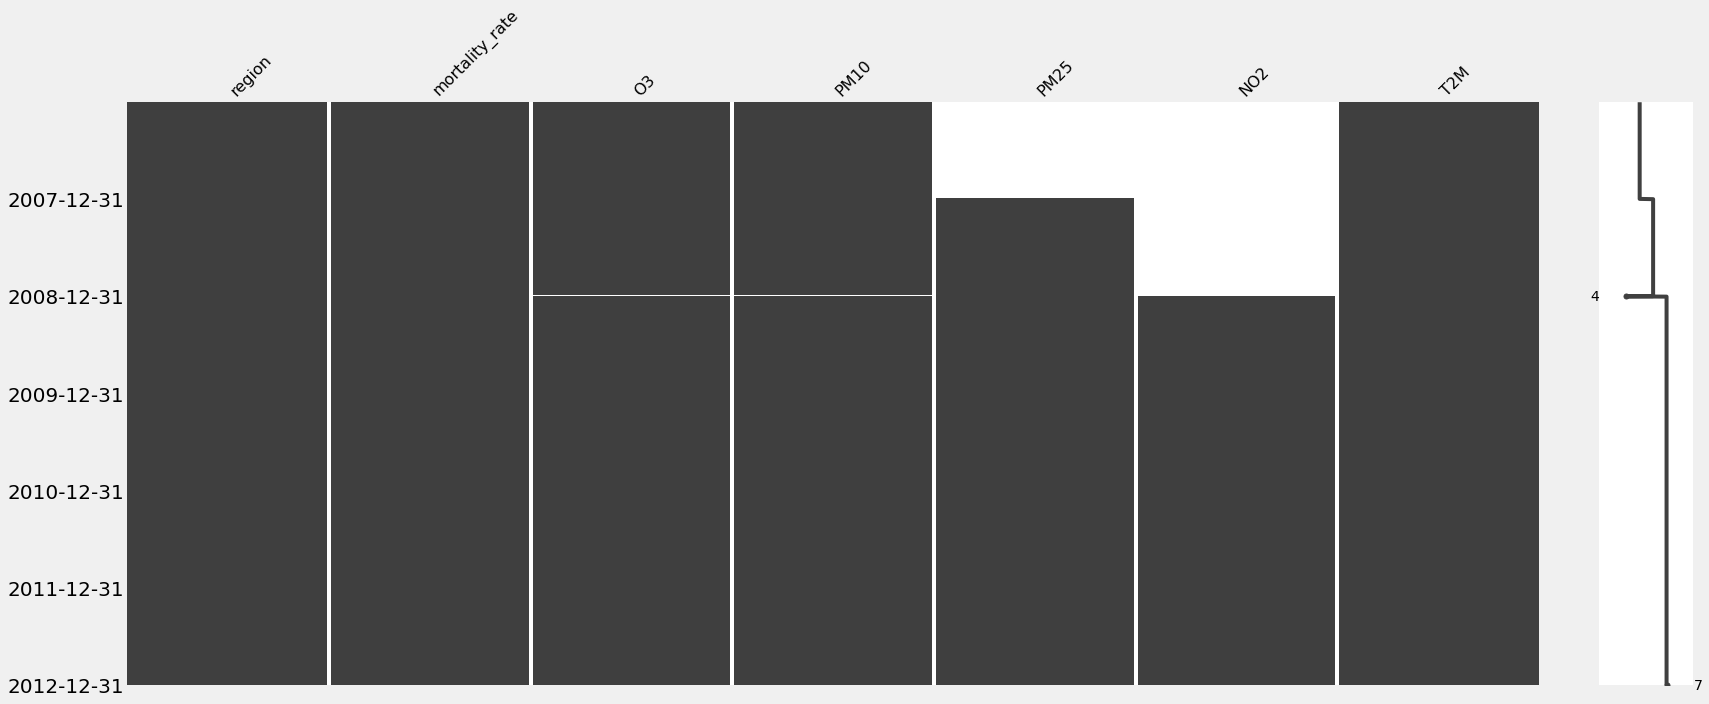

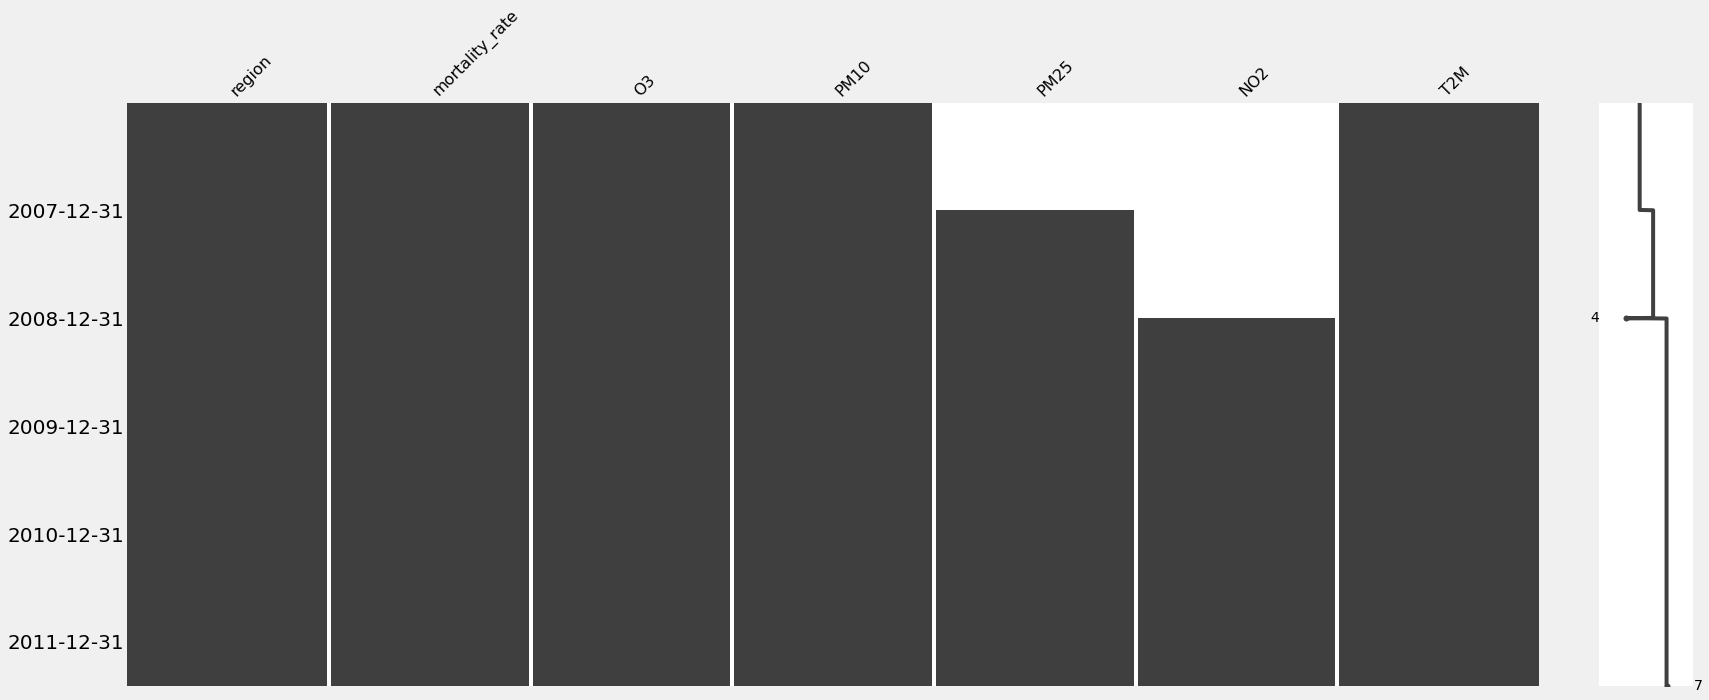

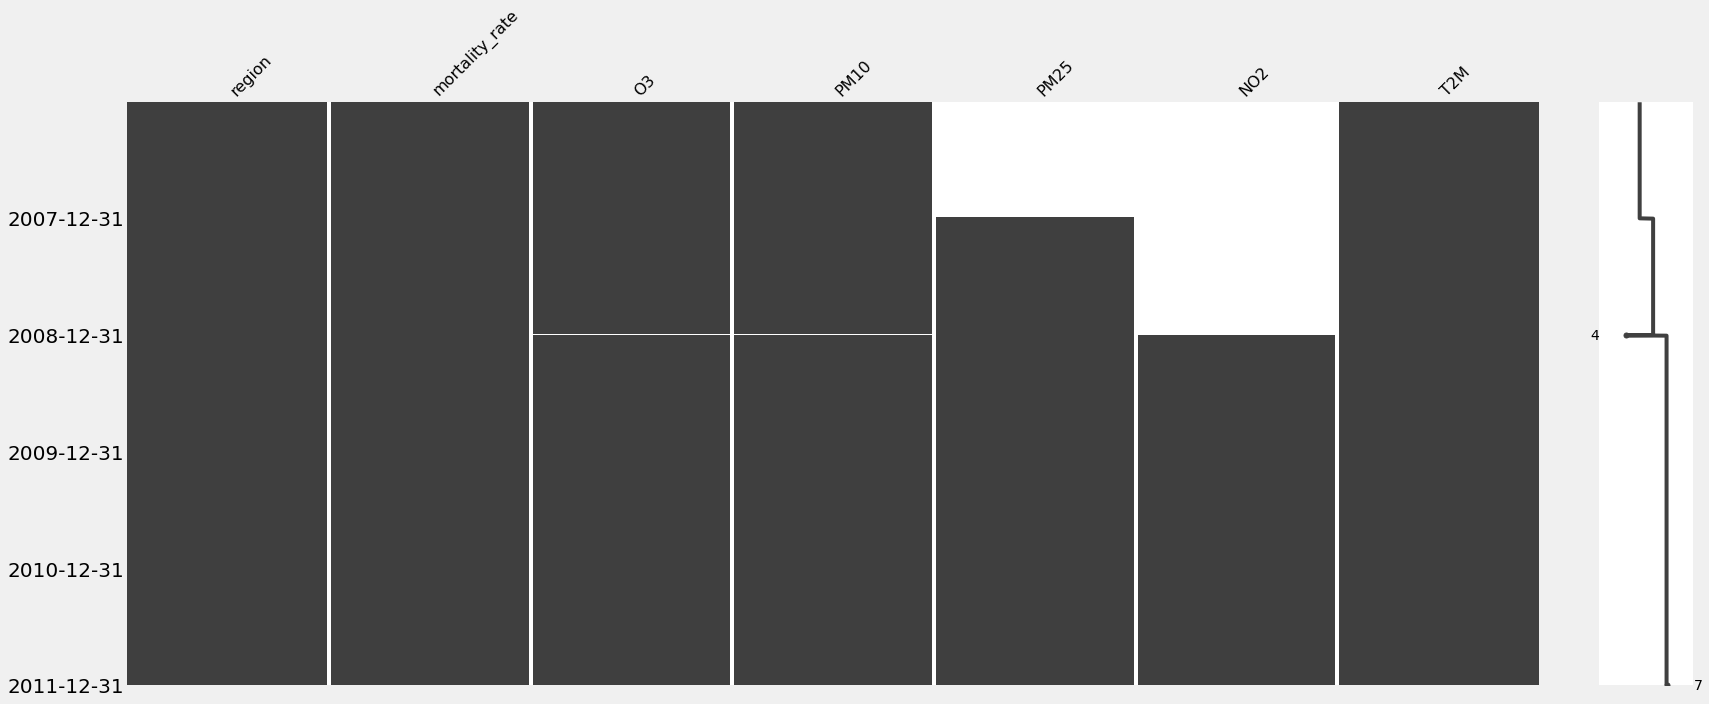

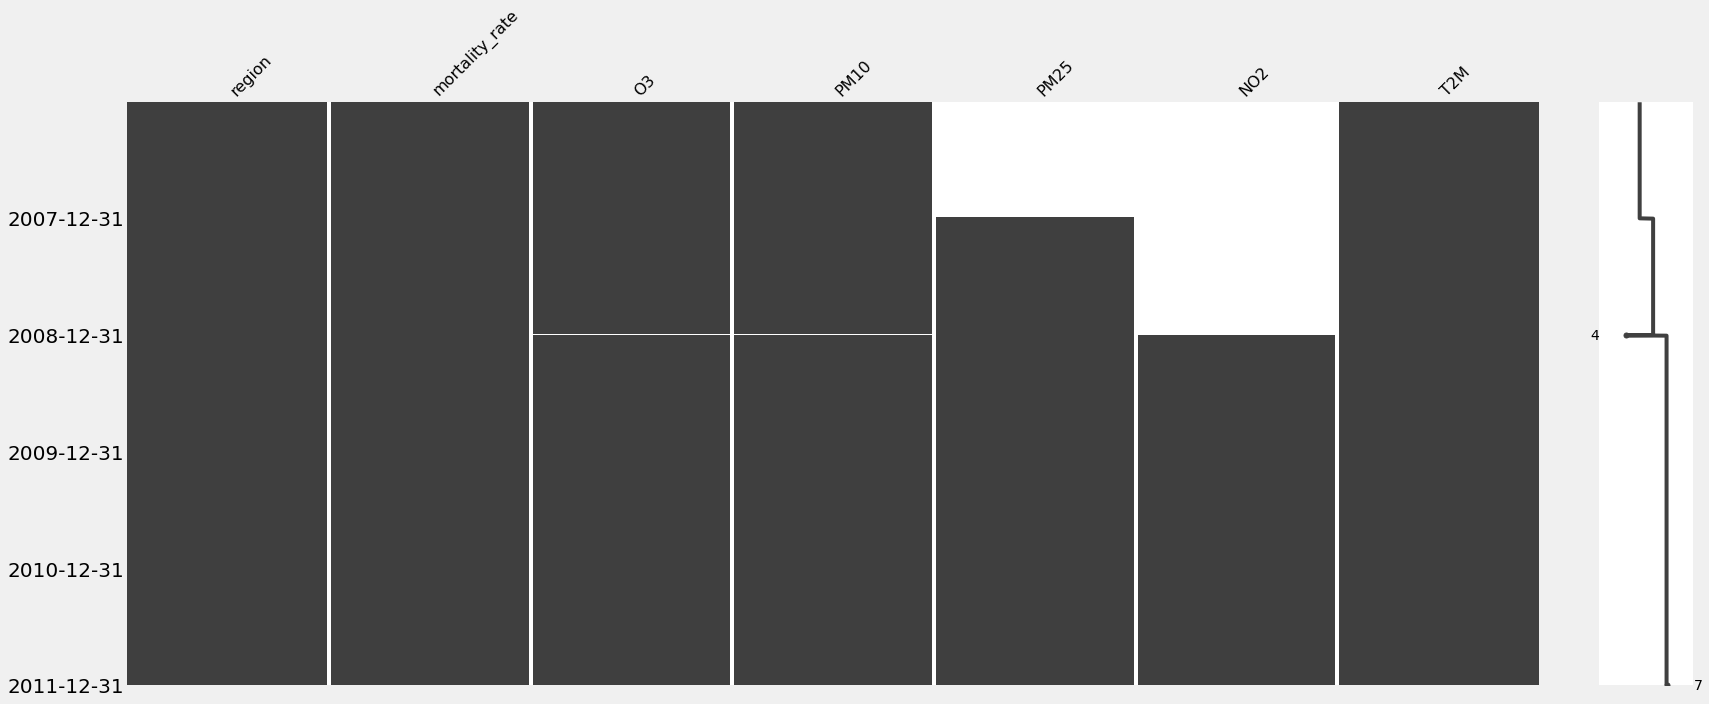

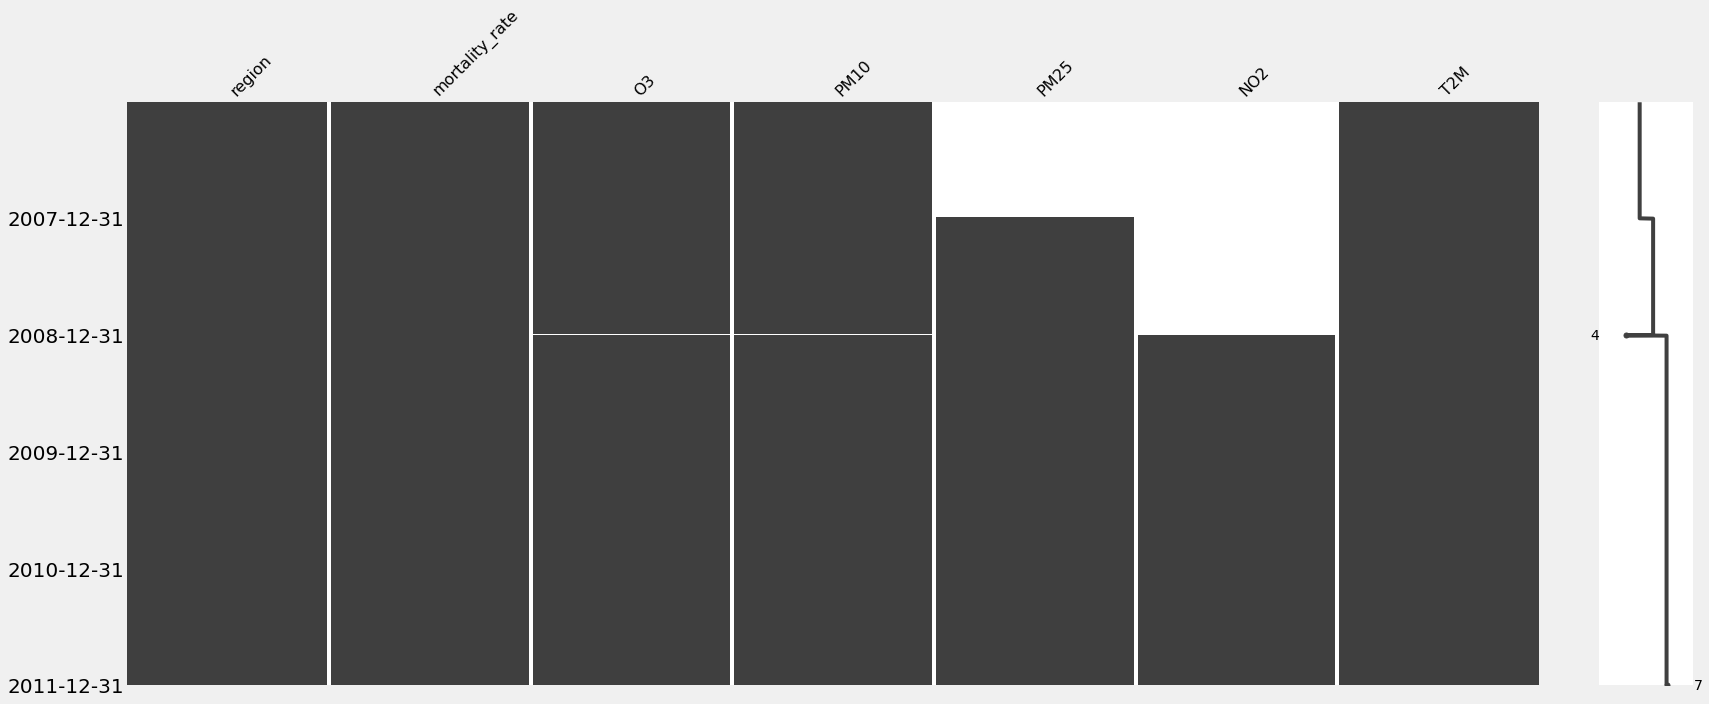

In [34]:
temp = train.set_index('date')

for r in train['region'].unique():
  t = temp[temp['region']==r]
  print(msno.matrix(t, freq = 'A'))

del temp, t
gc.collect()

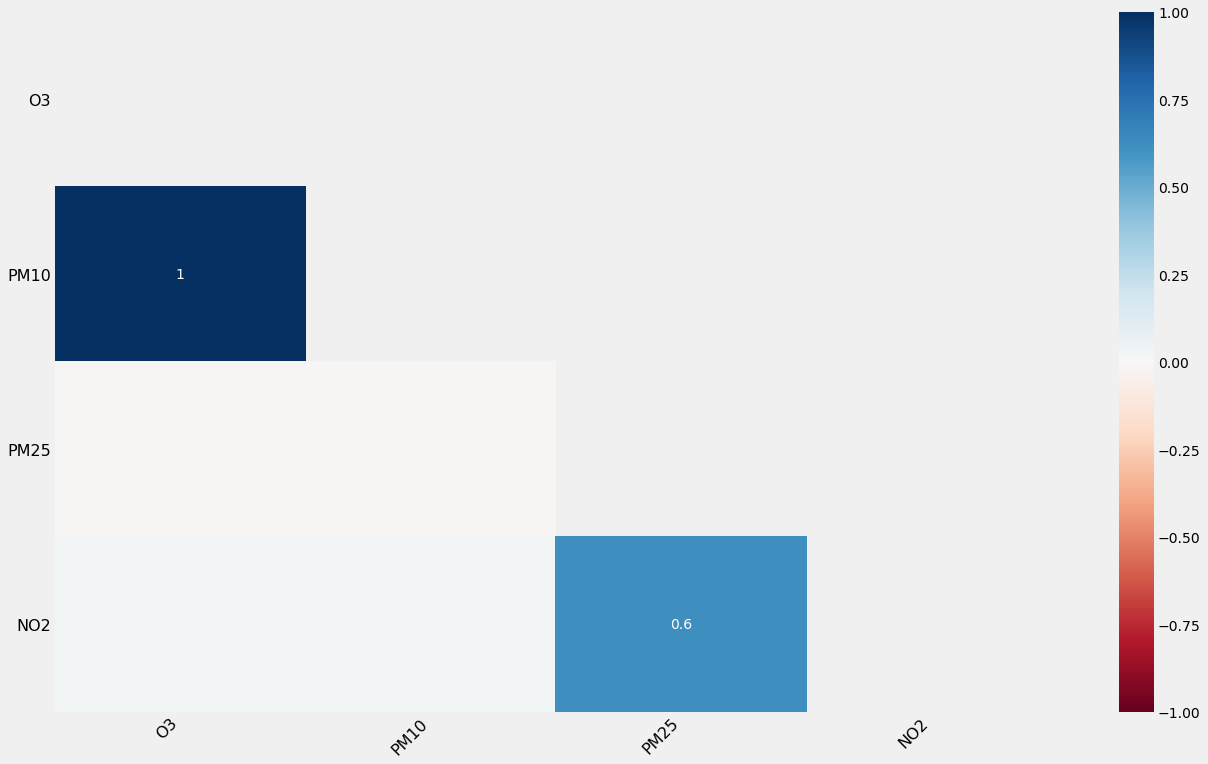

In [35]:
msno.heatmap(train)

# https://github.com/ResidentMario/missingno

# correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another
# Variables that are always full or always empty have no meaningful correlation, and so are silently removed from the visualization—in this case for instance the datetime and injury number columns, which are completely filled, are not included.

AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)


38160

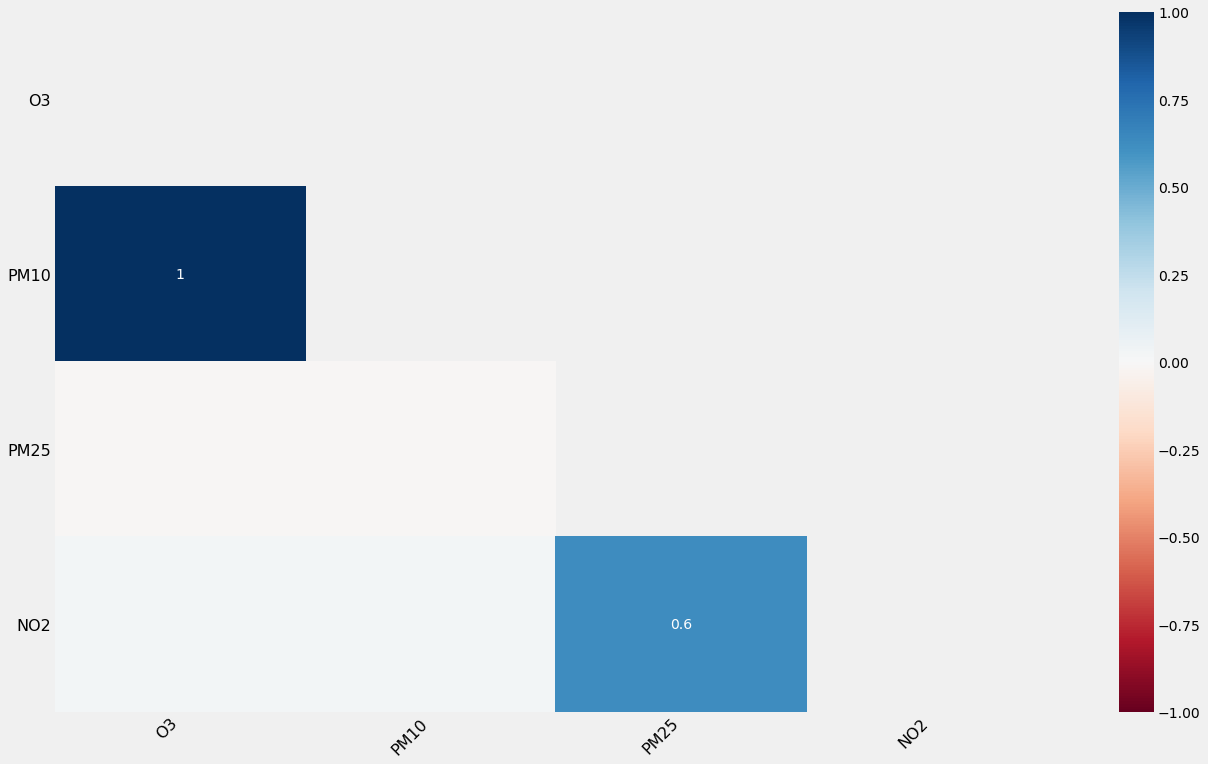

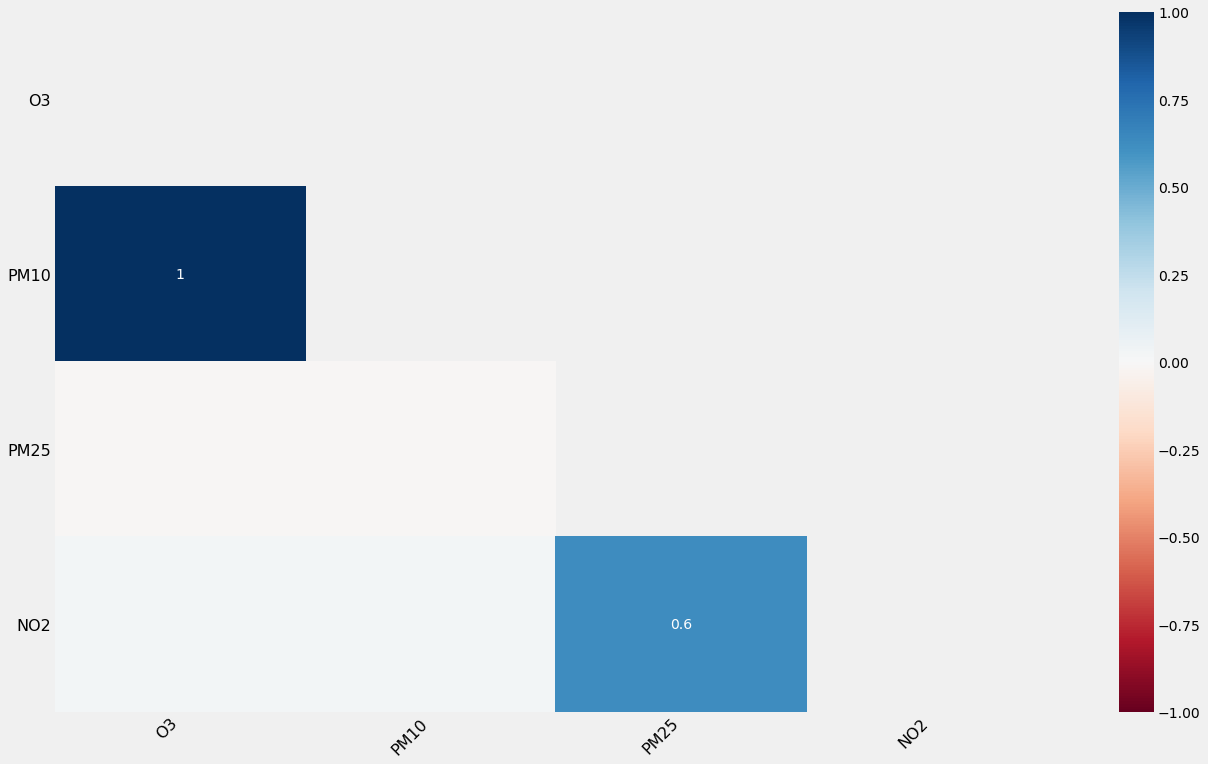

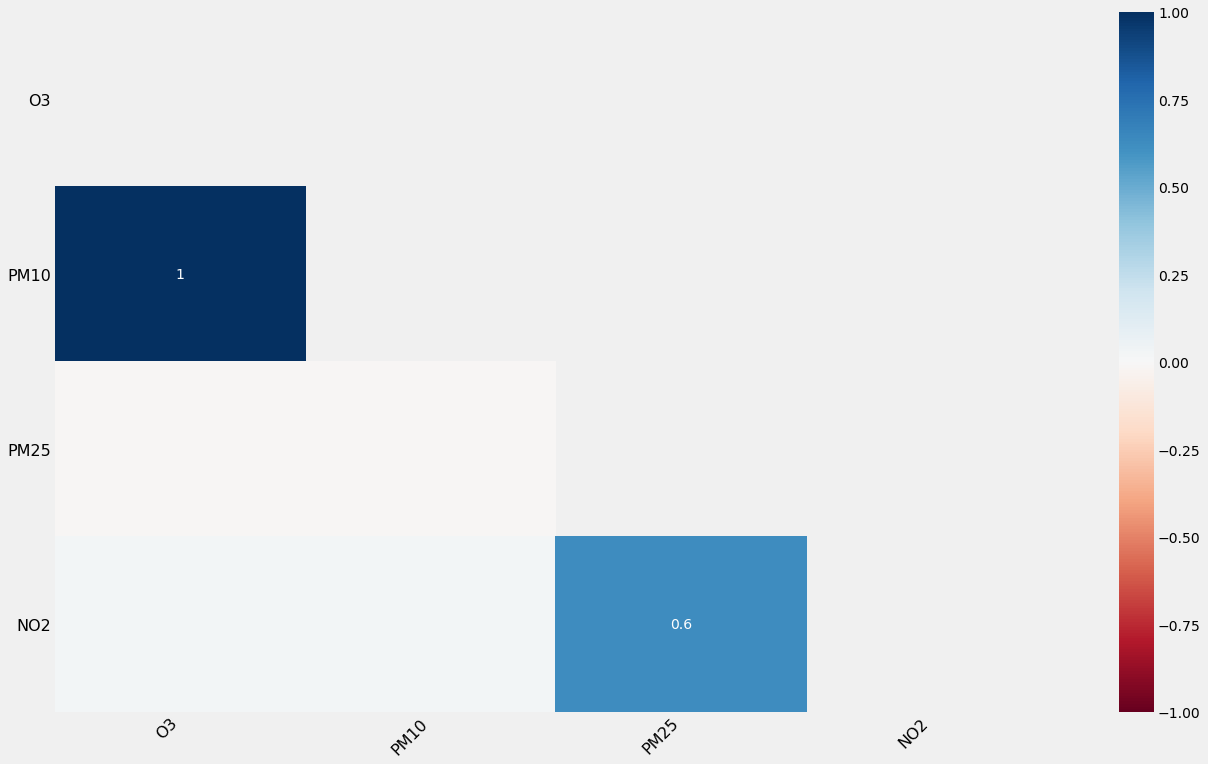

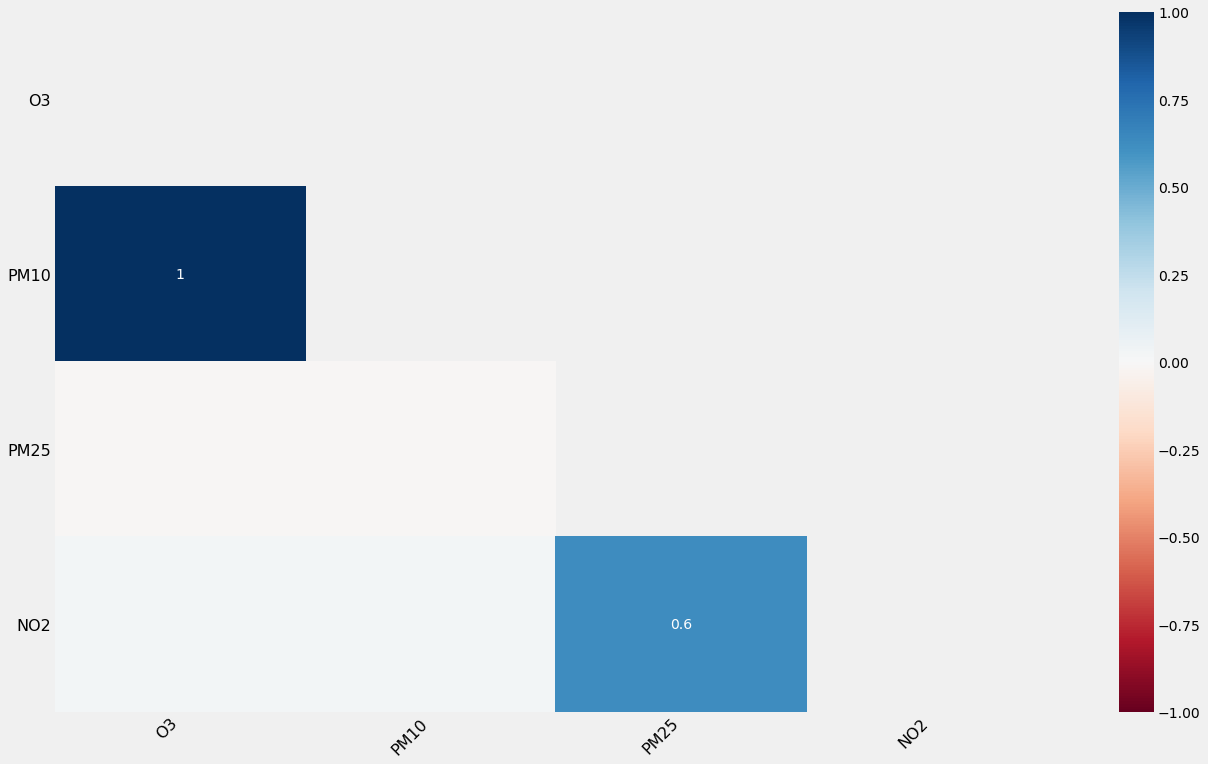

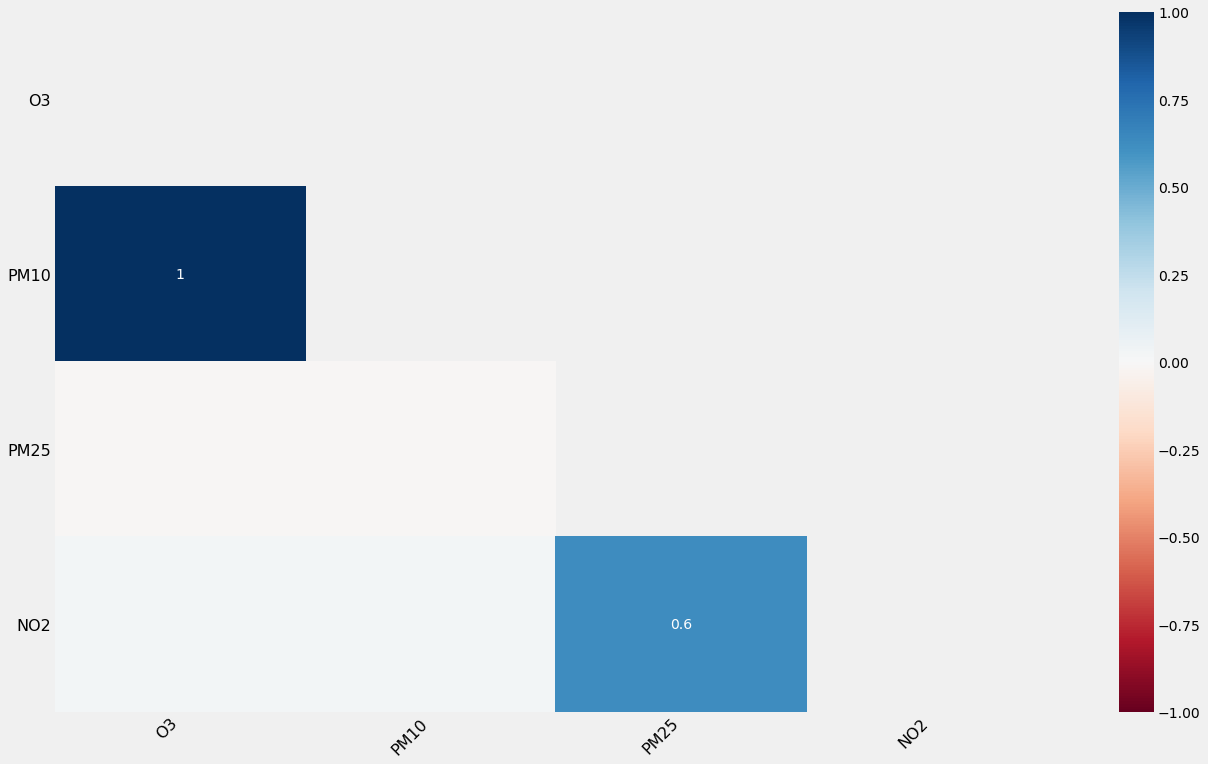

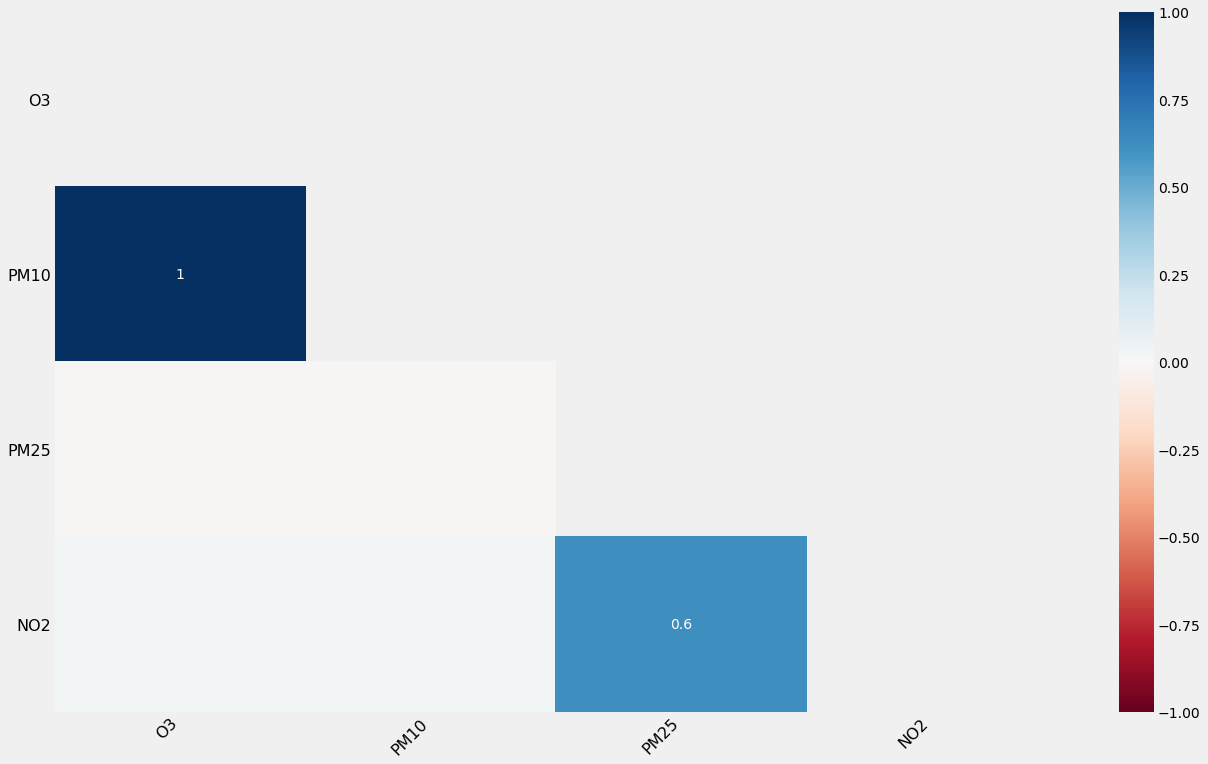

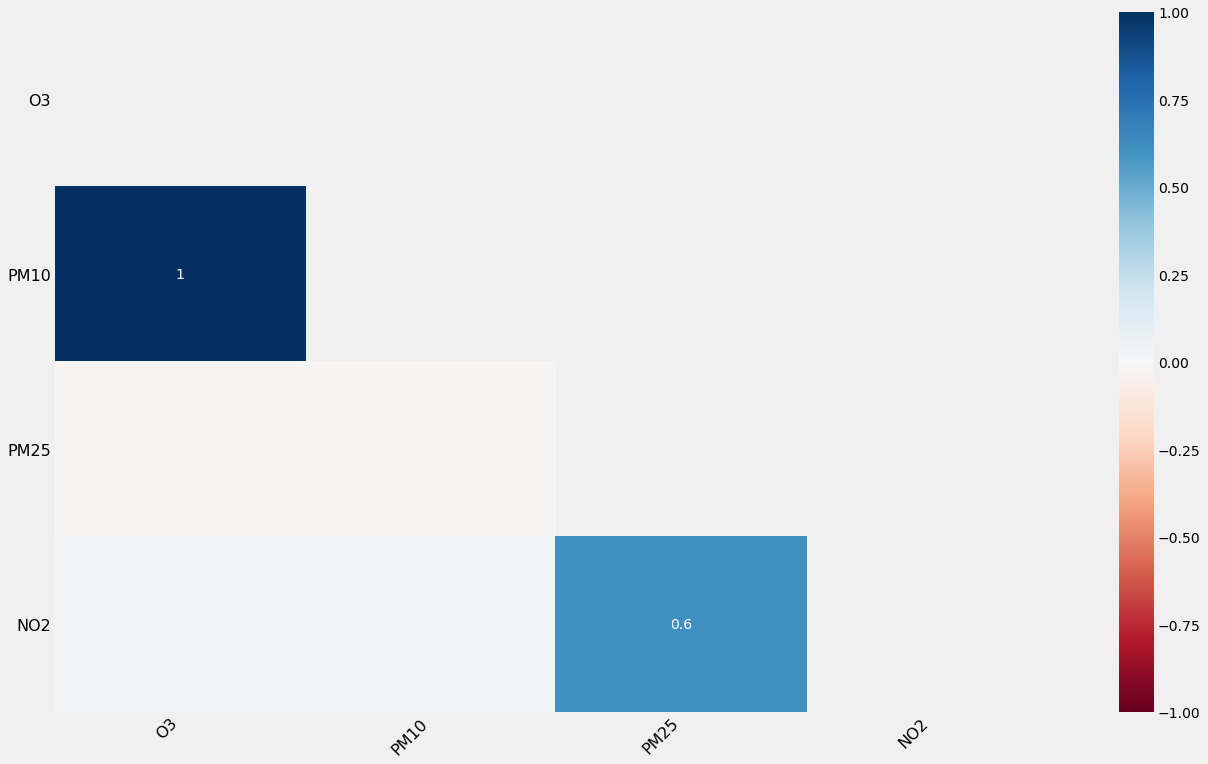

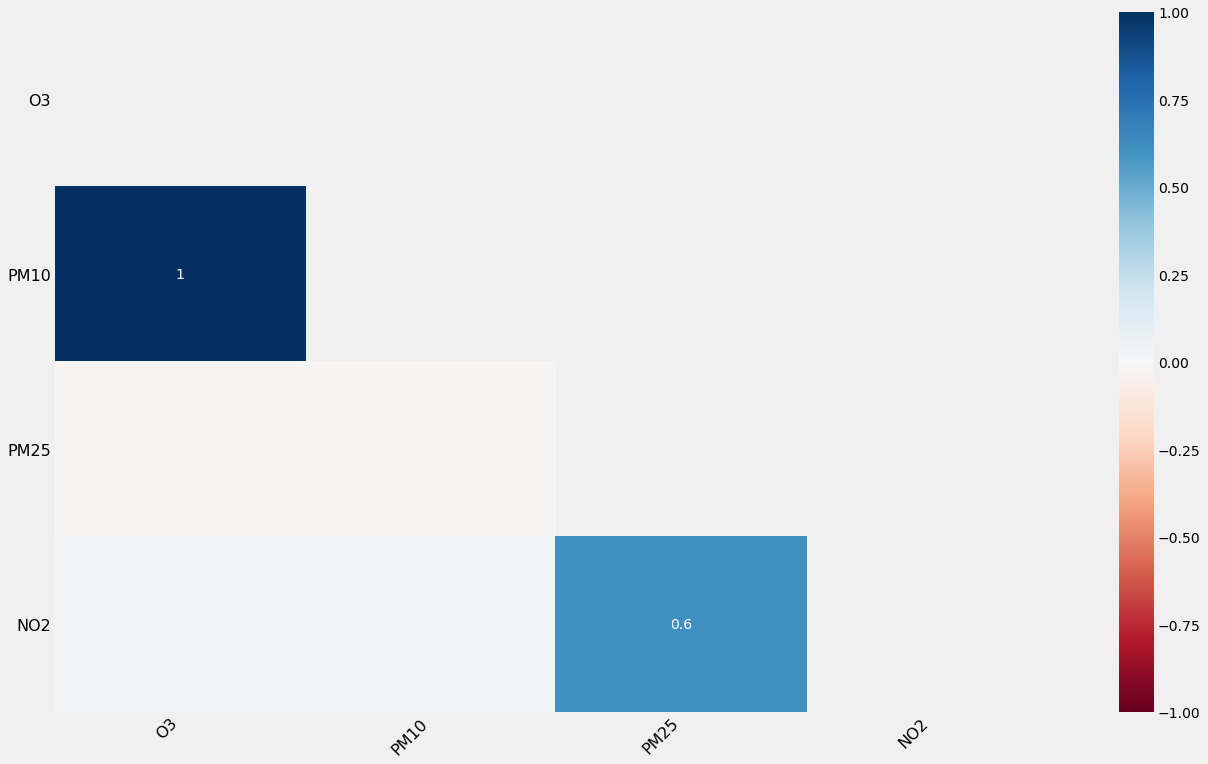

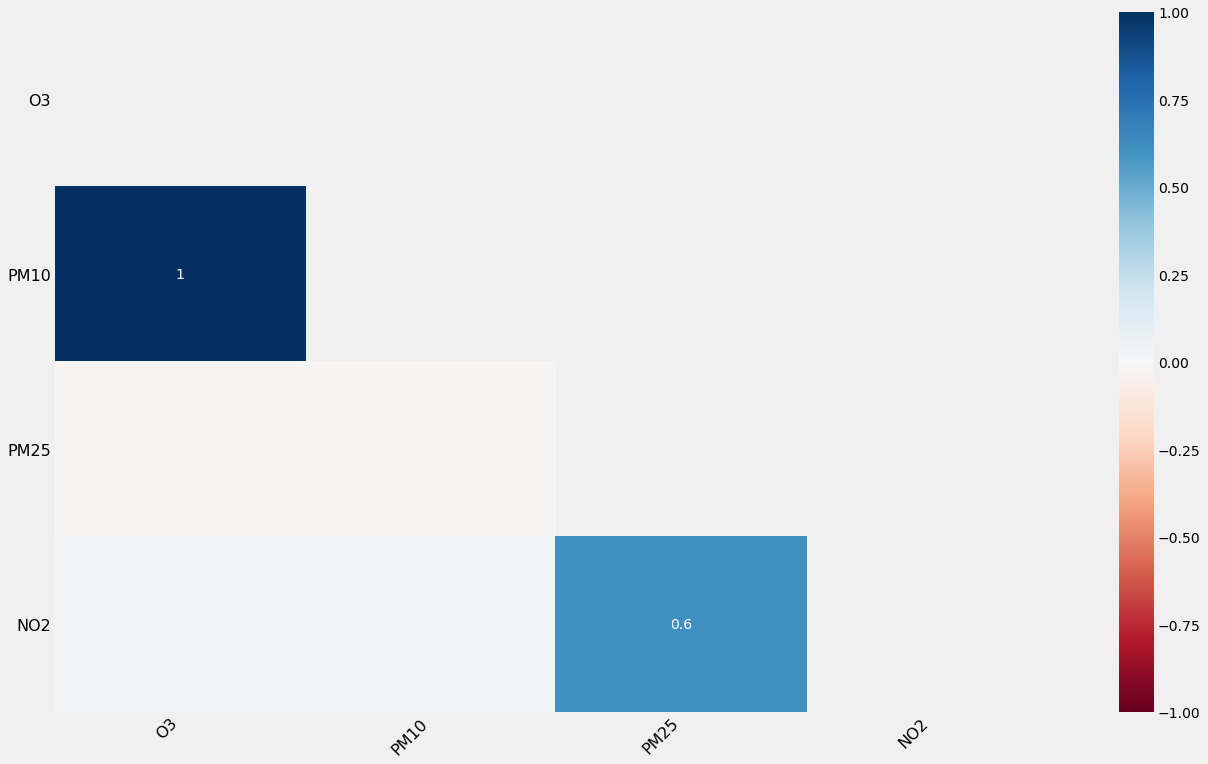

In [36]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(msno.heatmap(t))

del t
gc.collect()

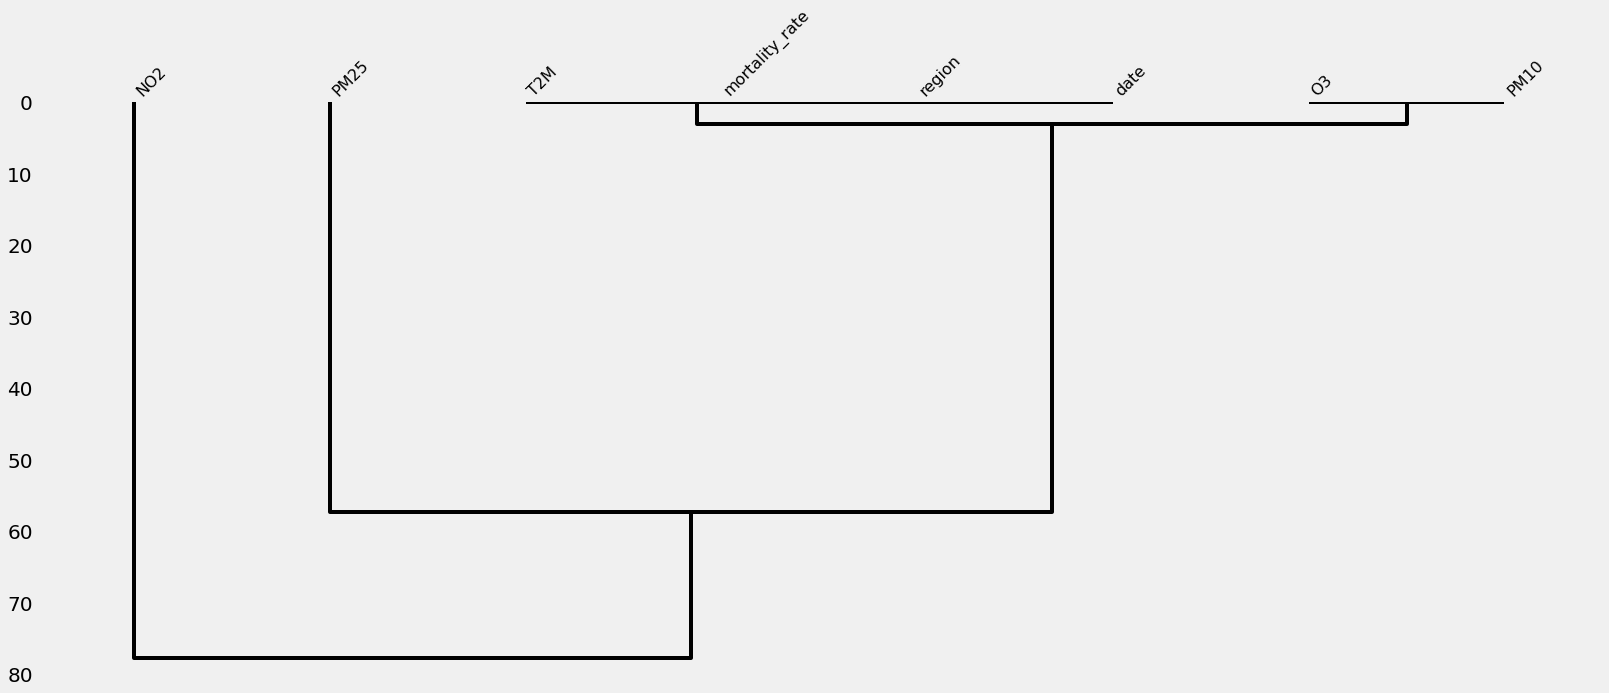

In [37]:
msno.dendrogram(train)

AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)


36695

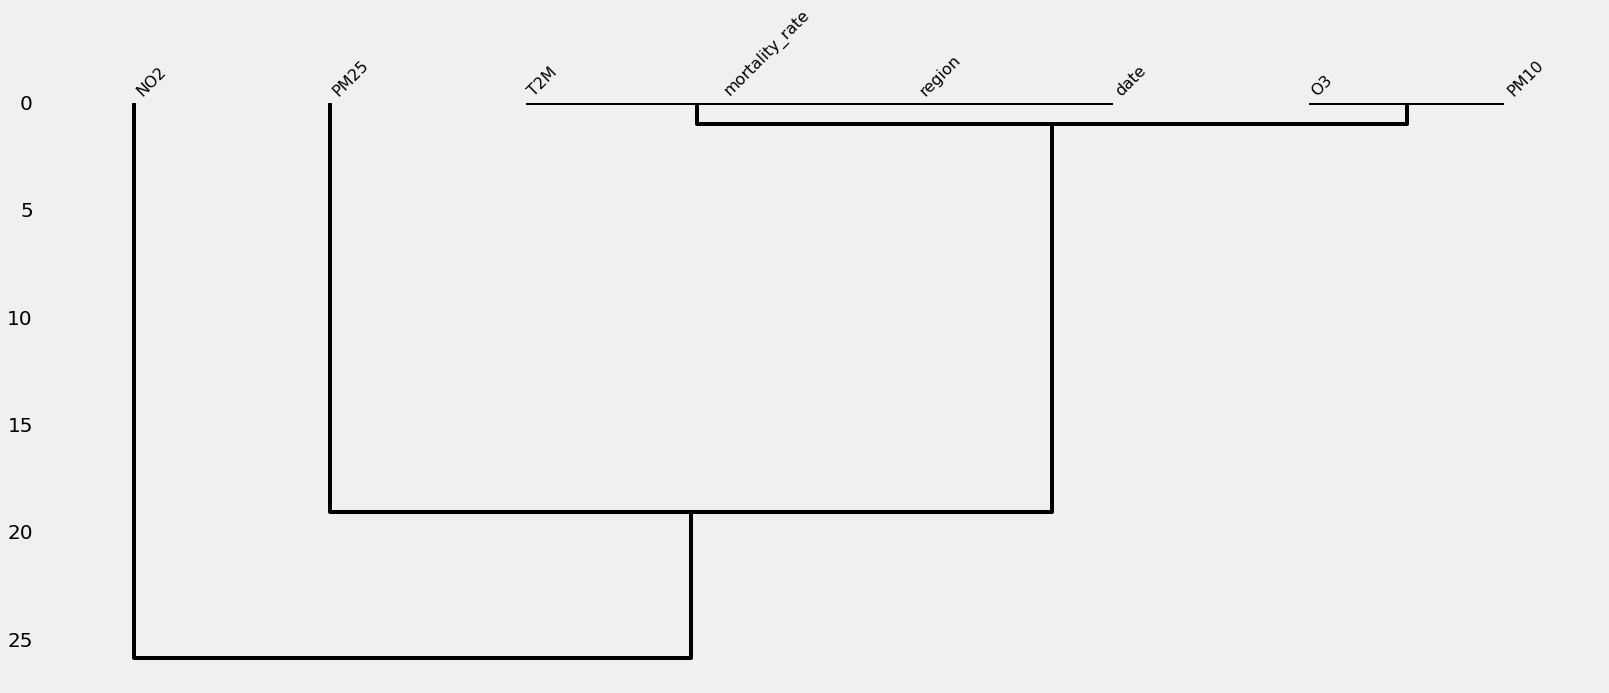

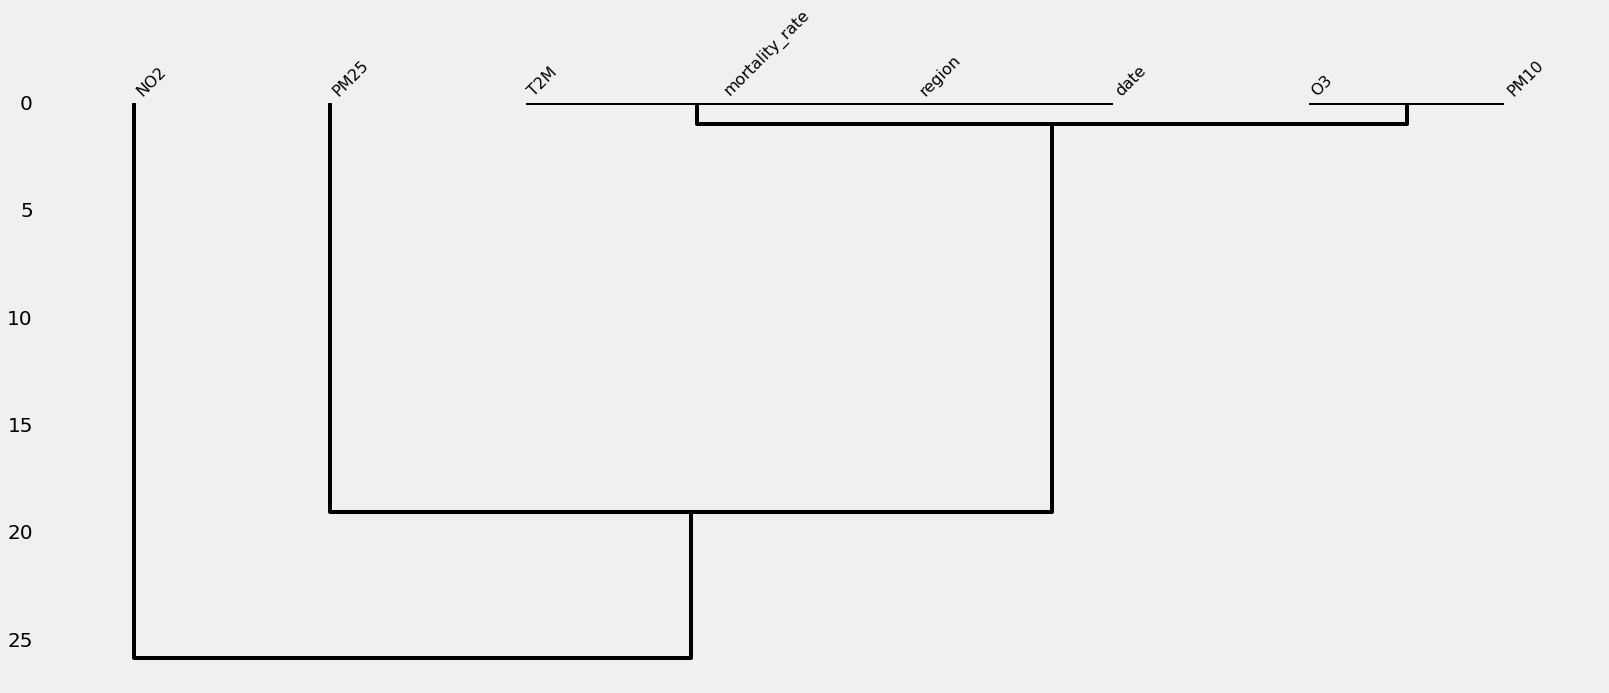

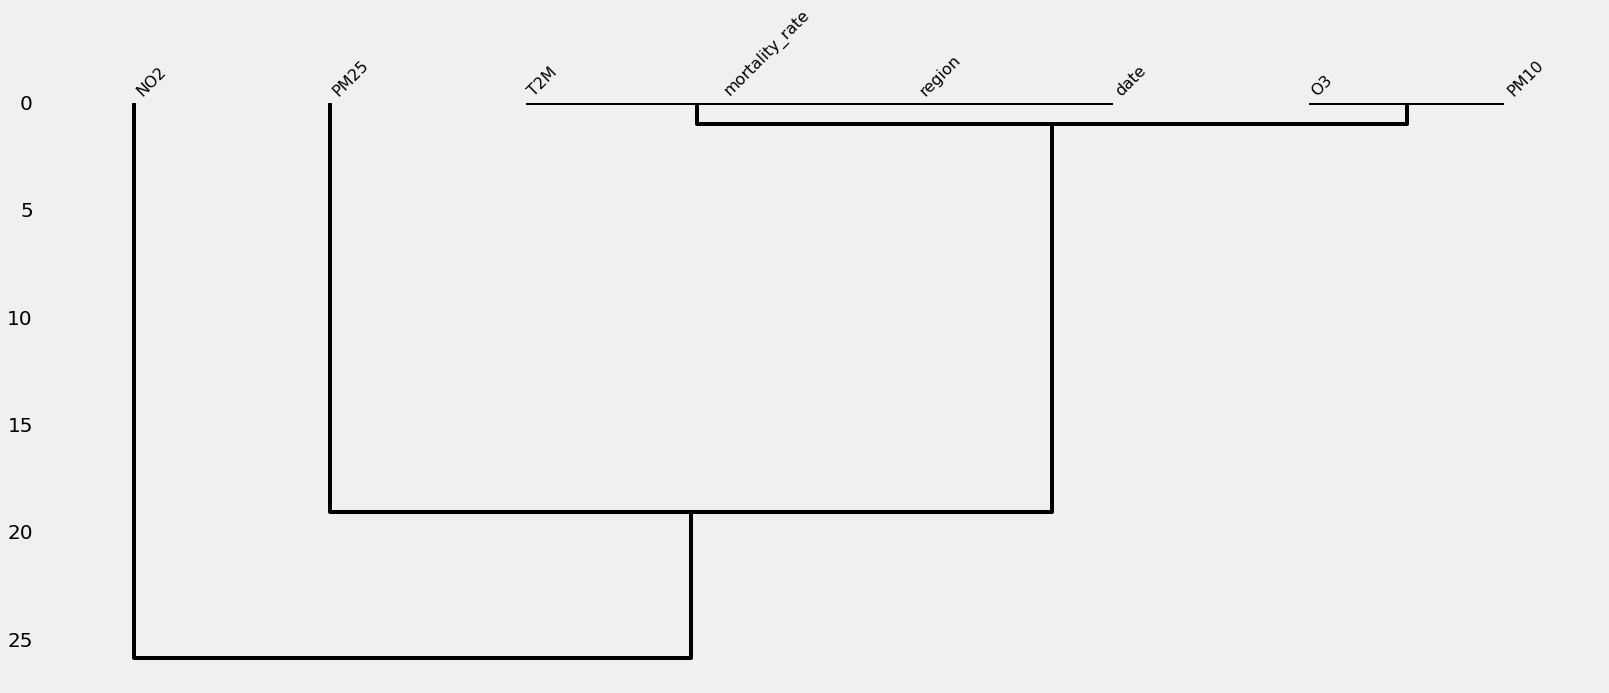

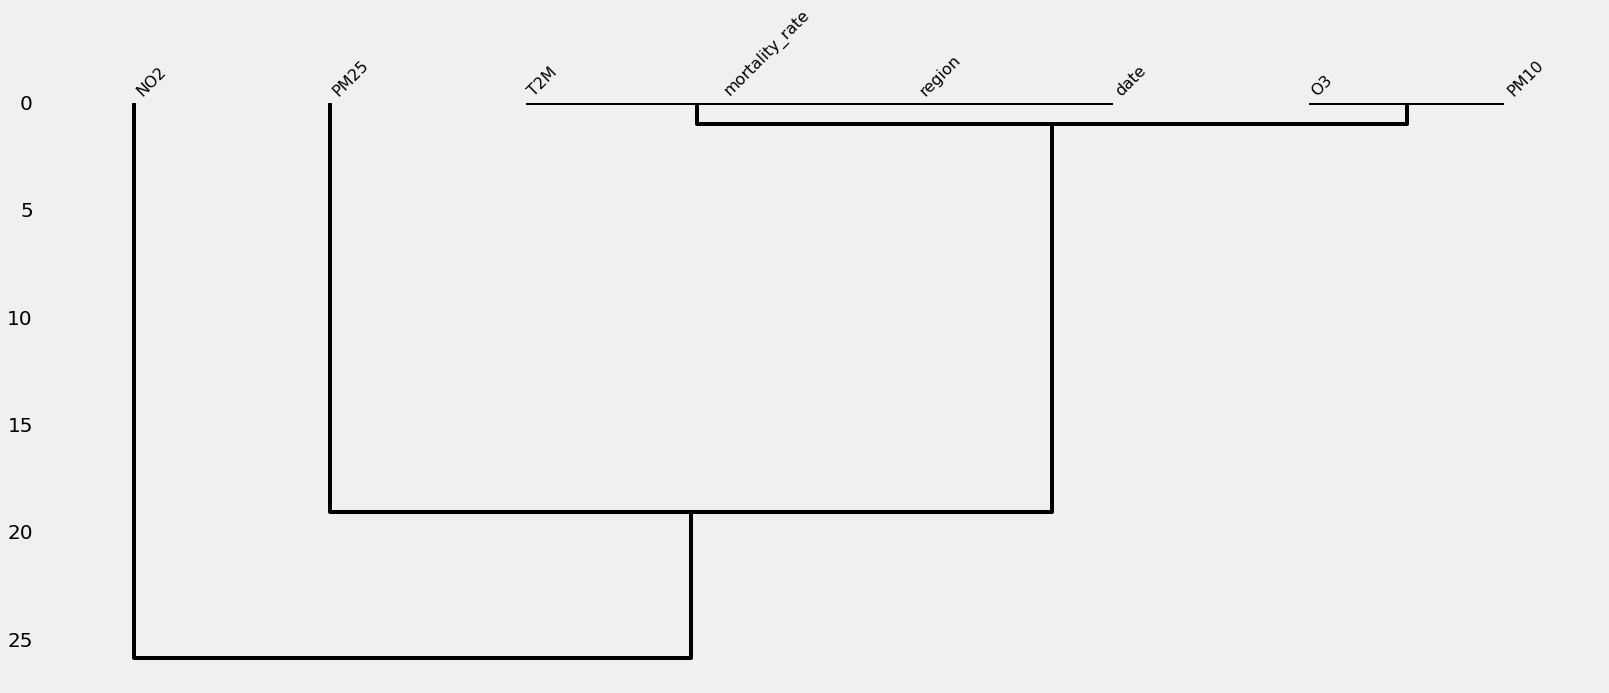

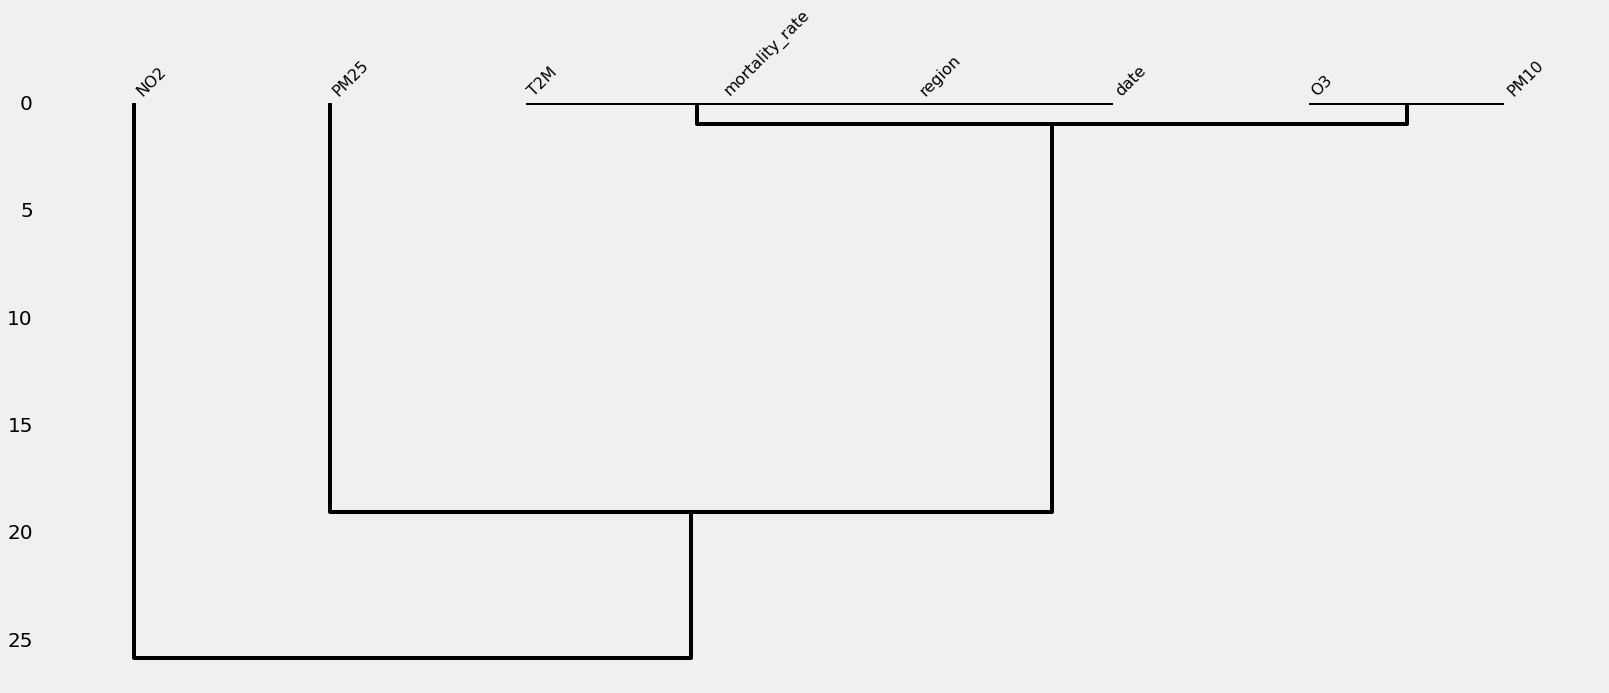

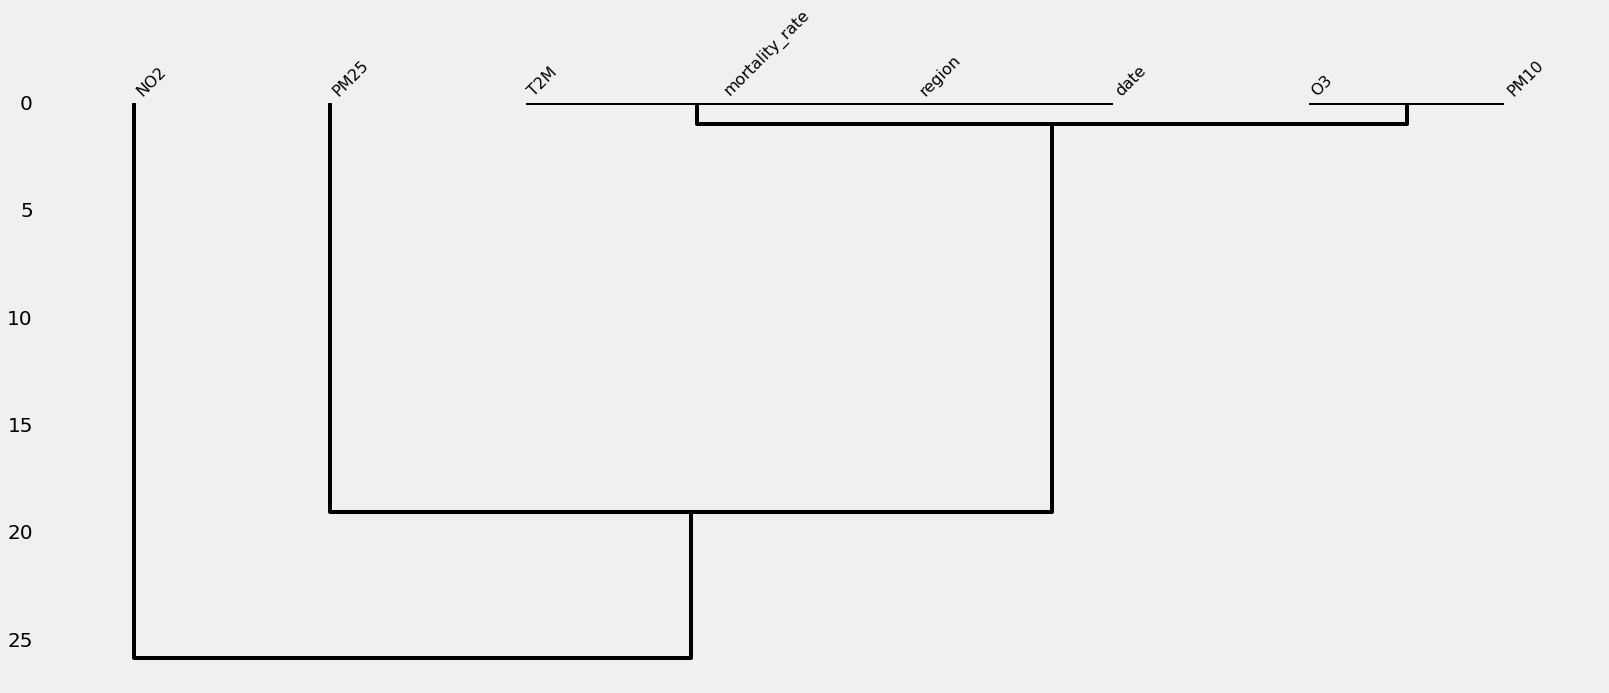

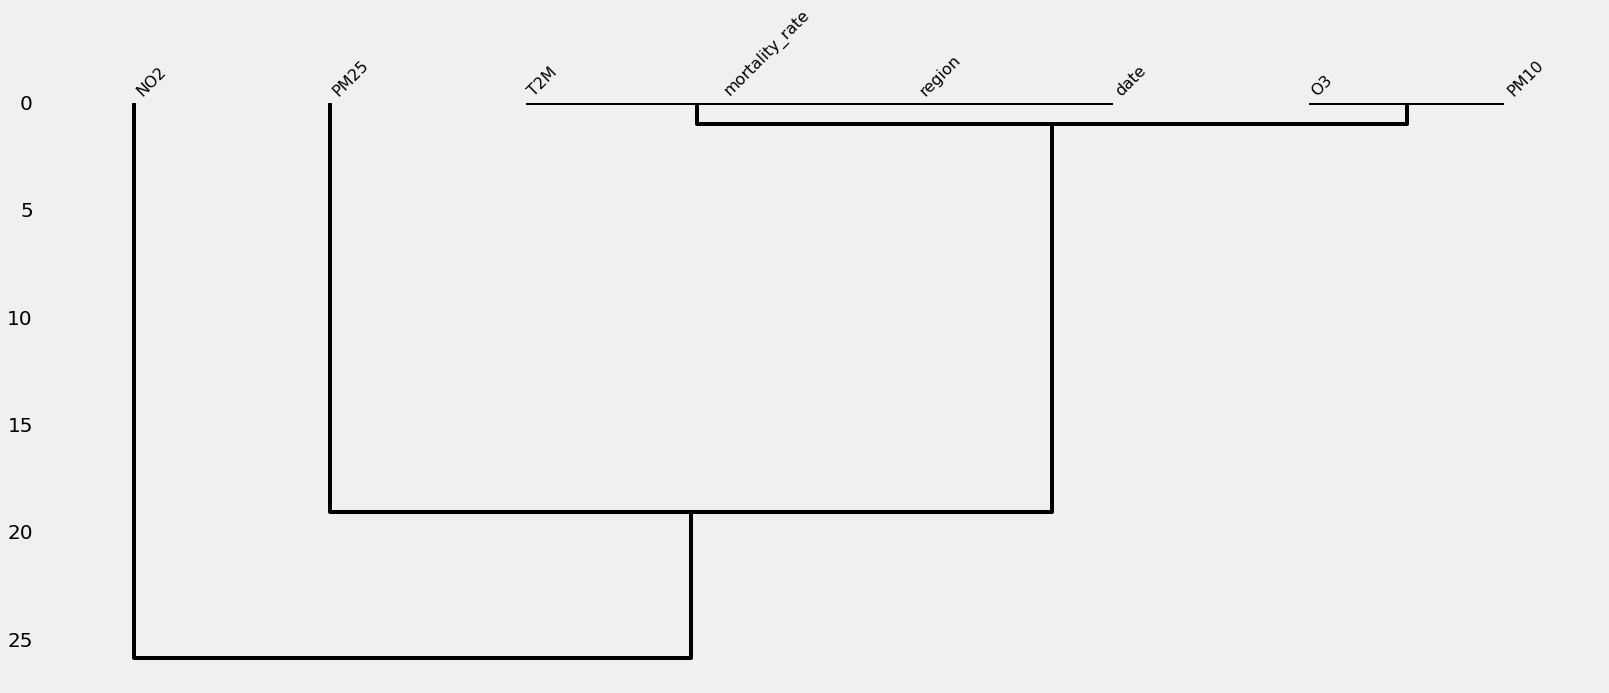

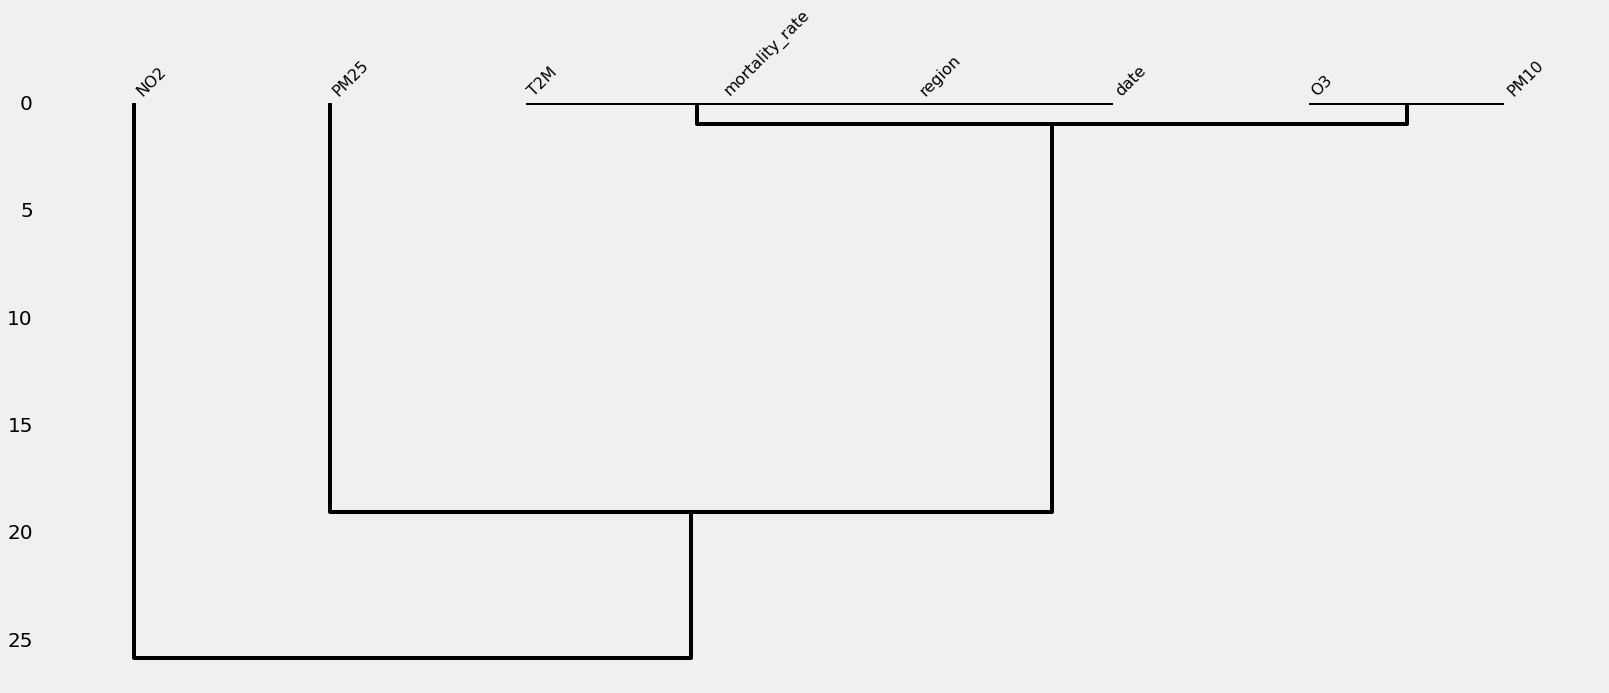

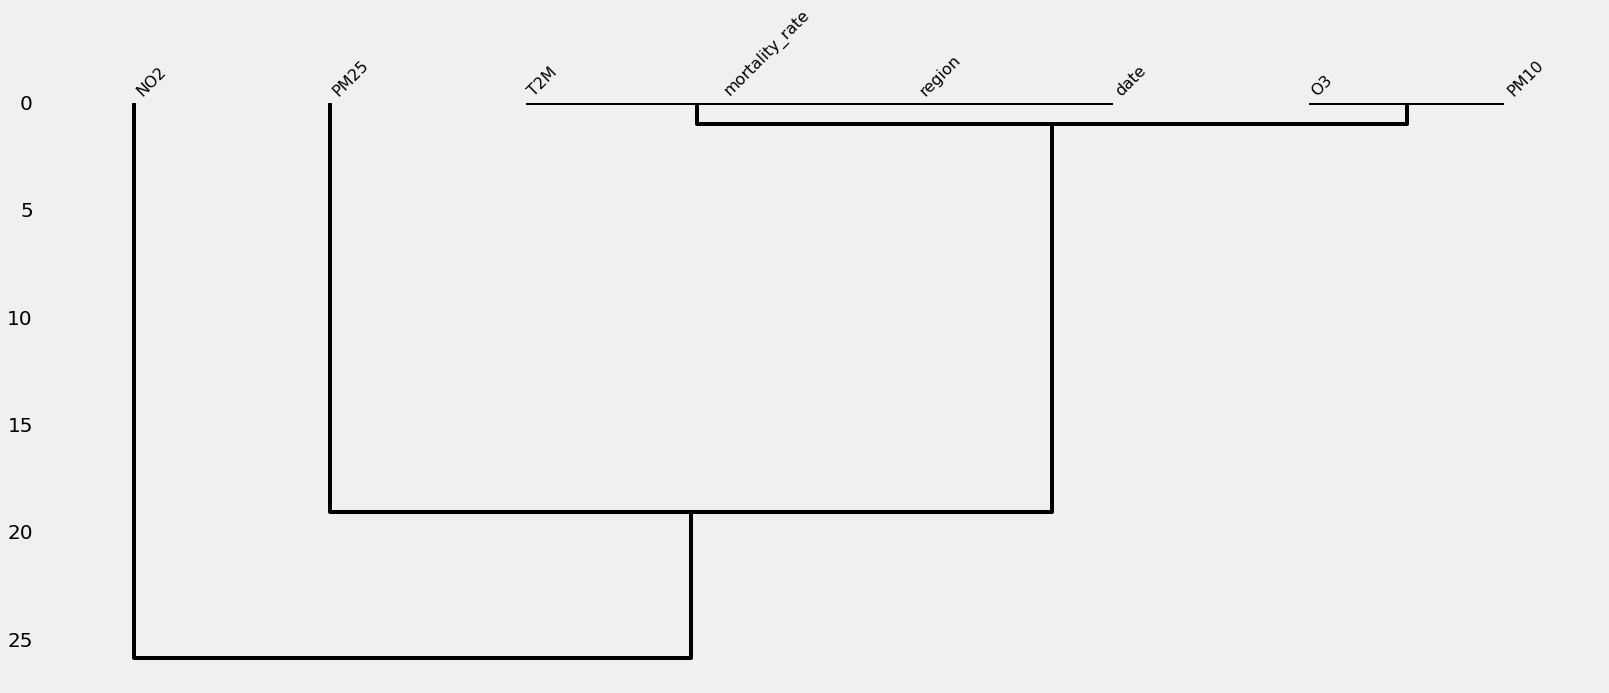

In [38]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(msno.dendrogram(t))

del t
gc.collect()

**_Missing values present in 4 columns, O3 ,PM10, PM25, NO2_**

## Merging Region names with the rest of the data

In [0]:
train1 = train.merge(region, left_on='region', right_on='Code')
#train1.drop(columns = ['region'],inplace=True)
test1 = test.merge(region, left_on='region', right_on='Code')
#test1.drop(columns = ['region'],inplace=True)

## univariate analysis ##

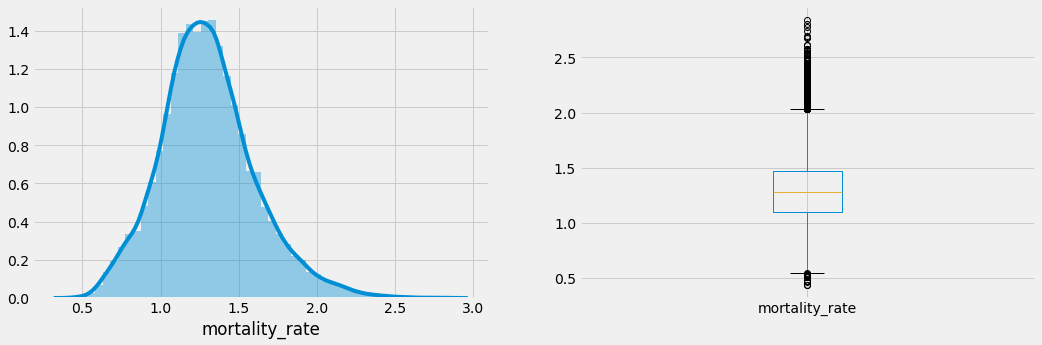

In [40]:
# Visualizing mortality_rate
def mr(df):
  plt.subplot(121)
  sns.distplot(df['mortality_rate']);

  plt.subplot(122)
  df['mortality_rate'].plot.box(figsize=(16,5))

  plt.show()

mr(train)

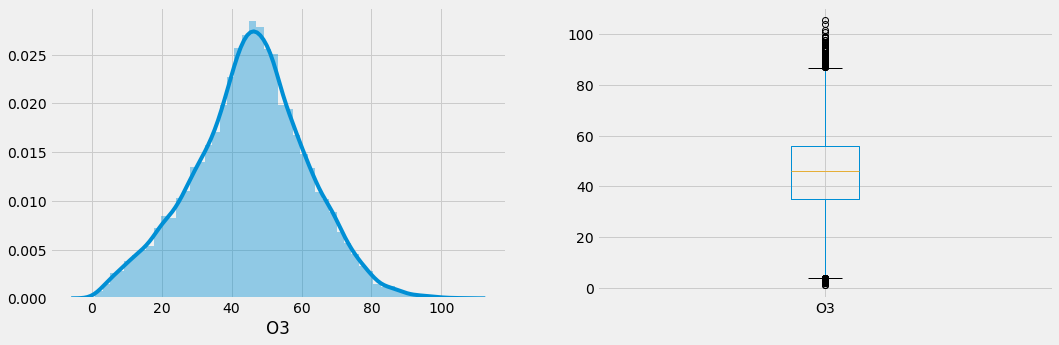

In [41]:
# Visualizing O3
def o3(df):
    plt.subplot(121)
    O3_1 = train['O3'].dropna()
    sns.distplot(O3_1);

    plt.subplot(122)
    O3_1.plot.box(figsize=(16,5))

    plt.show()
    plt.close()

o3(train)

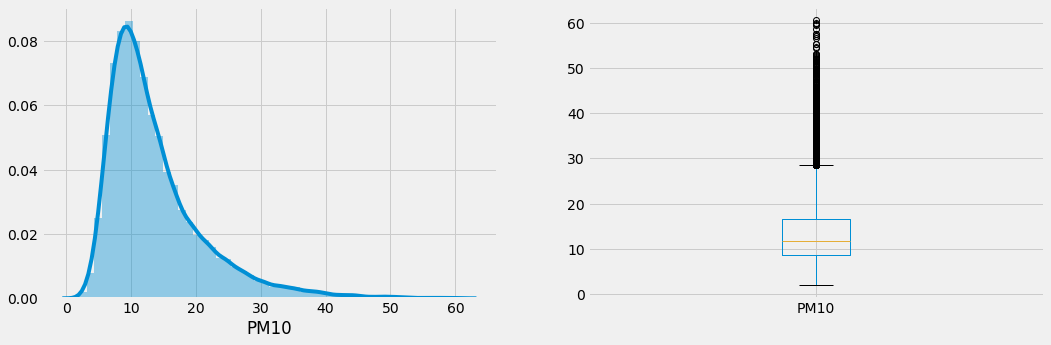

In [42]:
# Visualizing PM10
def pm10(df):
    plt.subplot(121)
    PM10_1 = train['PM10'].dropna()
    sns.distplot(PM10_1);

    plt.subplot(122)
    PM10_1.plot.box(figsize=(16,5))

    plt.show()

pm10(train)

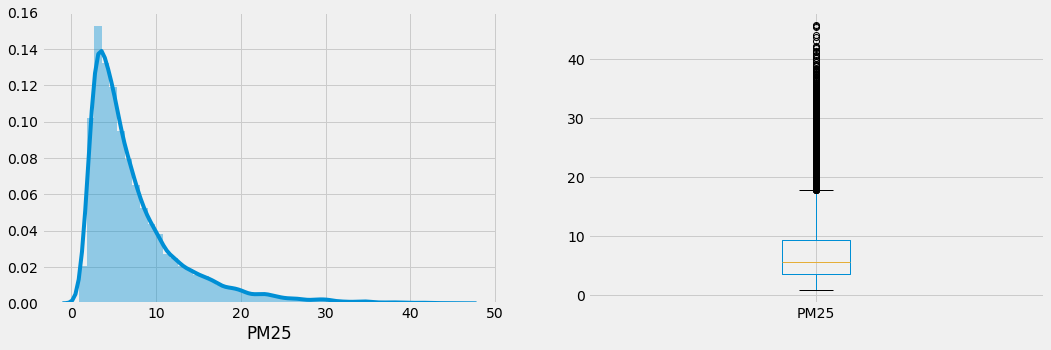

In [43]:
# Visualizing PM25

def pm25(df):
    plt.subplot(121)
    PM25_1 = train['PM25'].dropna()
    sns.distplot(PM25_1);

    plt.subplot(122)
    PM25_1.plot.box(figsize=(16,5))

    plt.show()

pm25(train)

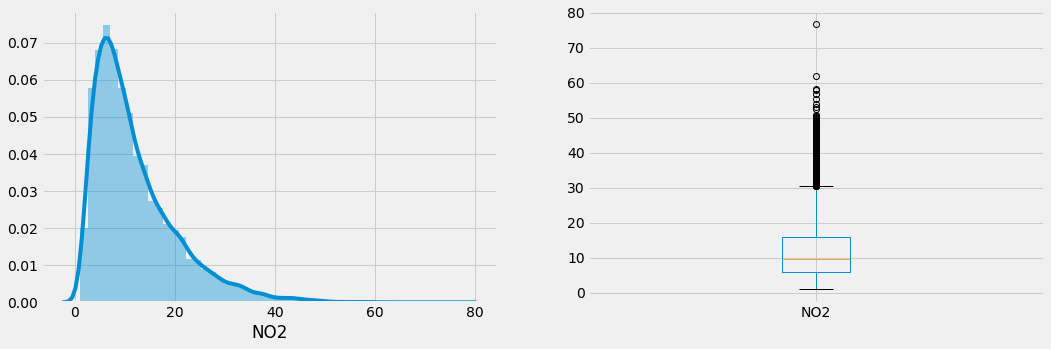

In [44]:
# Visualizing NO2
def no2(df):
    plt.subplot(121)
    NO2_1 = train['NO2'].dropna()
    sns.distplot(NO2_1);

    plt.subplot(122)
    NO2_1.plot.box(figsize=(16,5))

    plt.show()
  
no2(train)

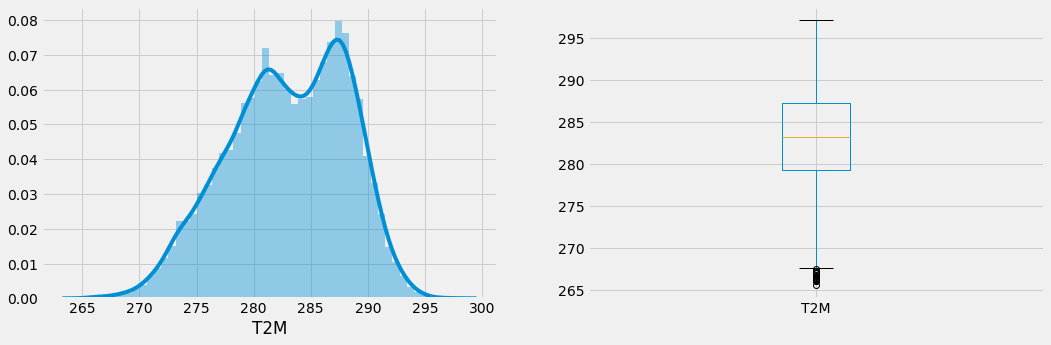

In [45]:
# Visualizing T2M

def t2m(df):
    plt.subplot(121)
    sns.distplot(train['T2M']);

    plt.subplot(122)
    train['T2M'].plot.box(figsize=(16,5))

    plt.show()

t2m(train)

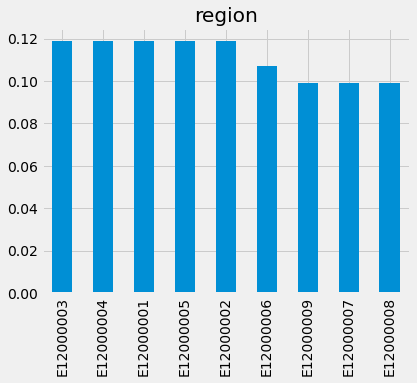

In [46]:
# Visualizing categorical features
plt.subplot(231)
train['region'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'region')

mortality rate across regions


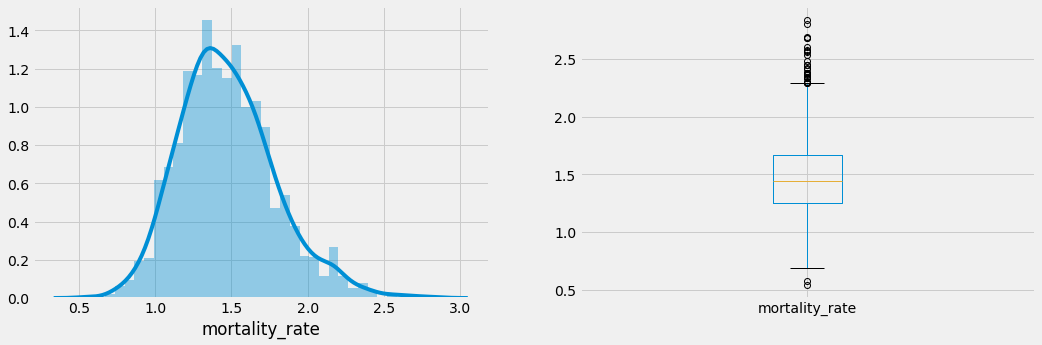

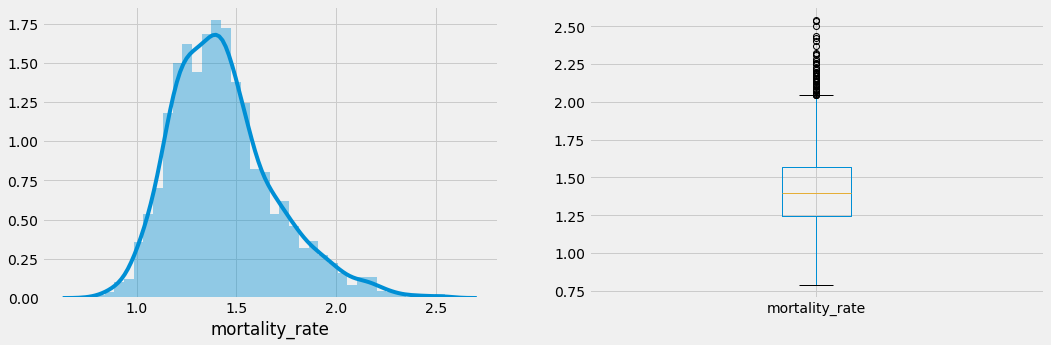

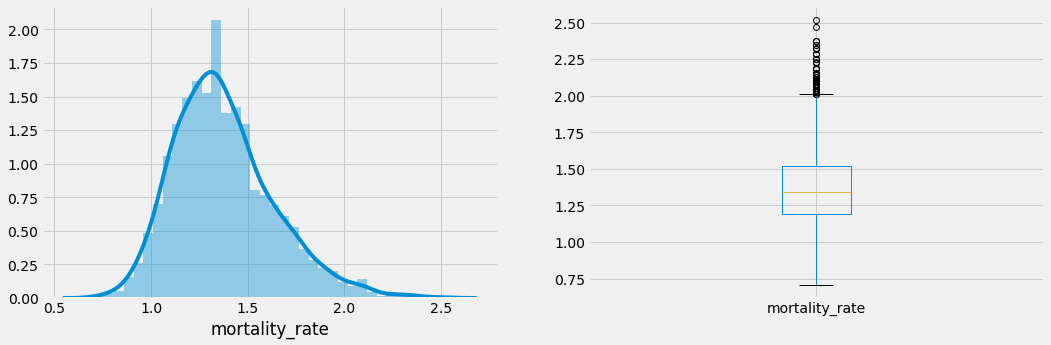

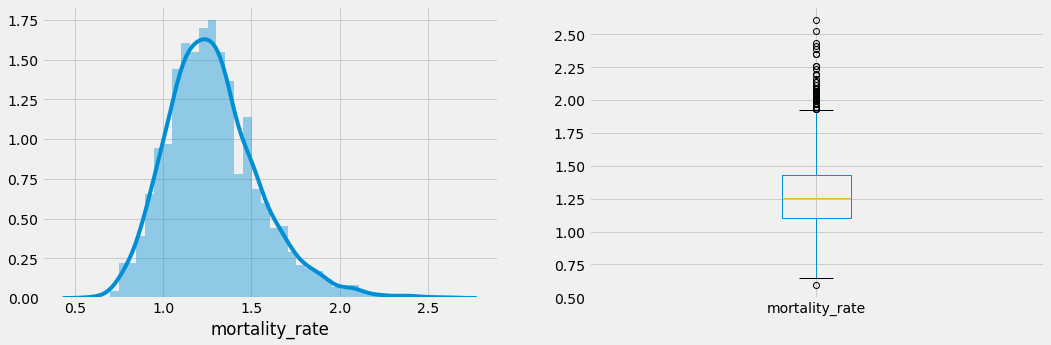

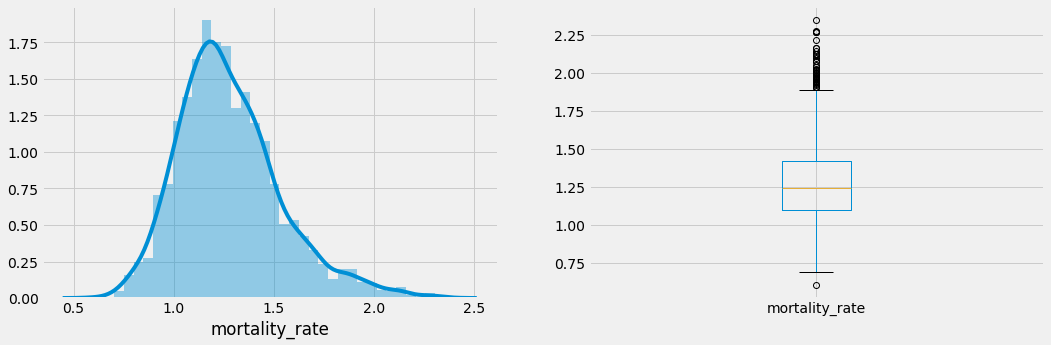

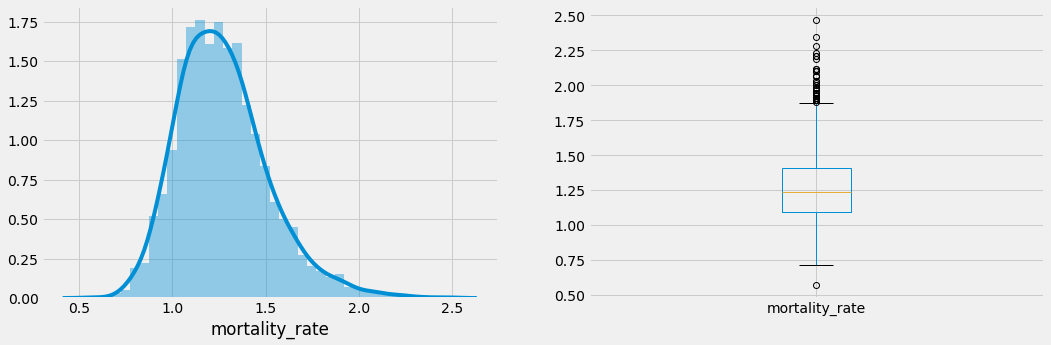

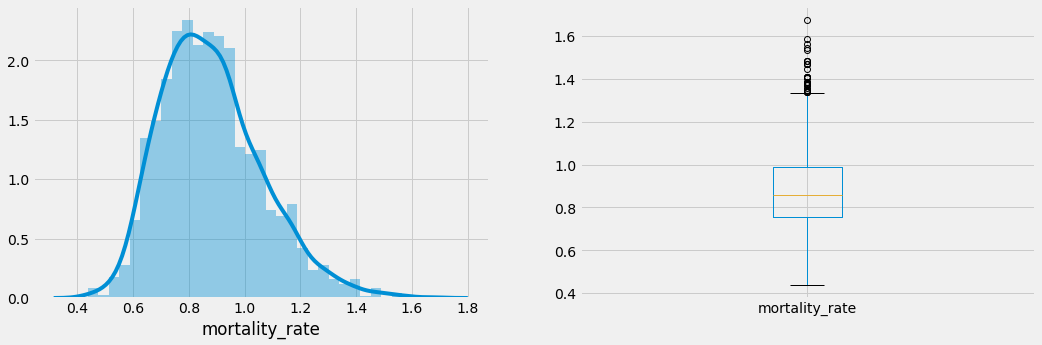

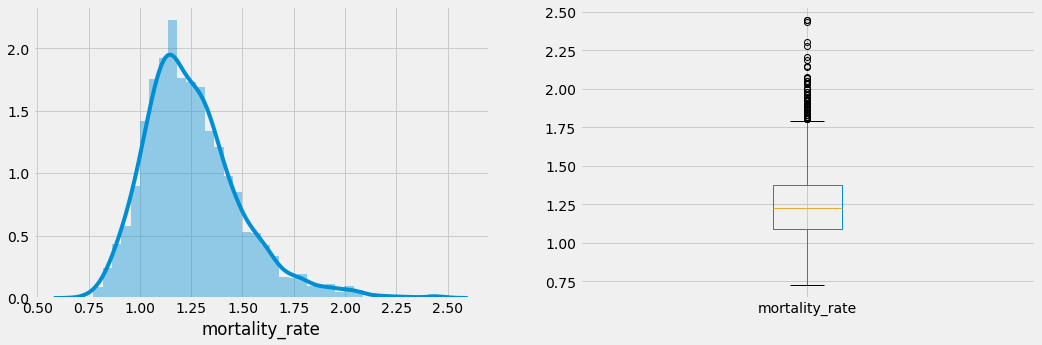

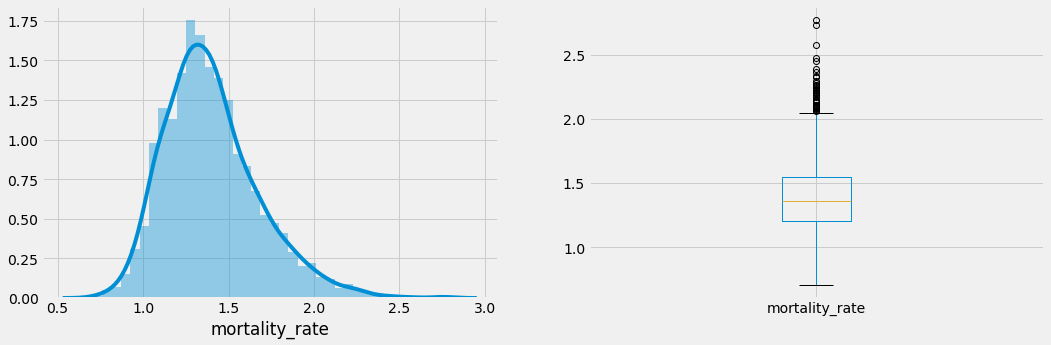

In [47]:
print('mortality rate across regions')
for r in train['region'].unique():
  t = train[train['region']==r]
  mr(t)

ozone across regions


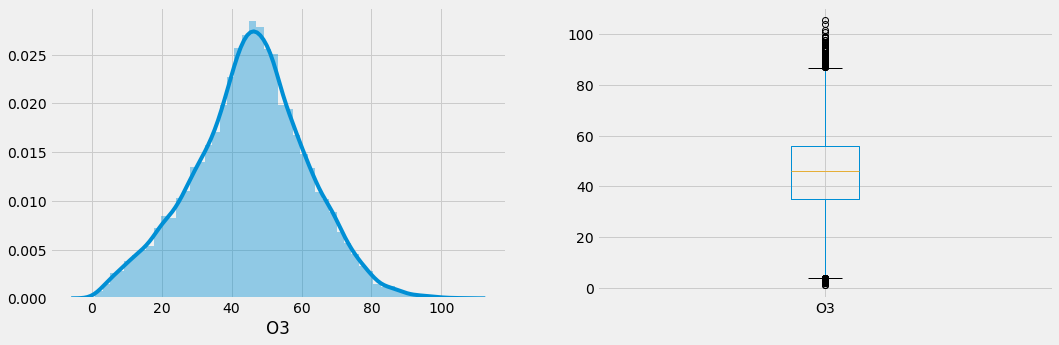

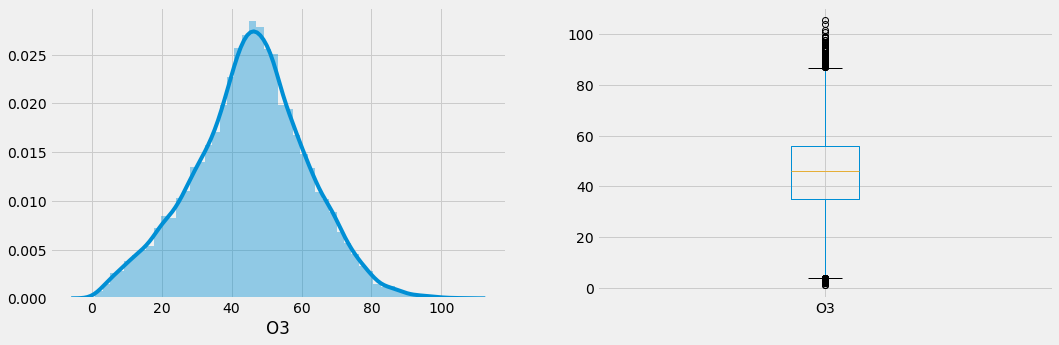

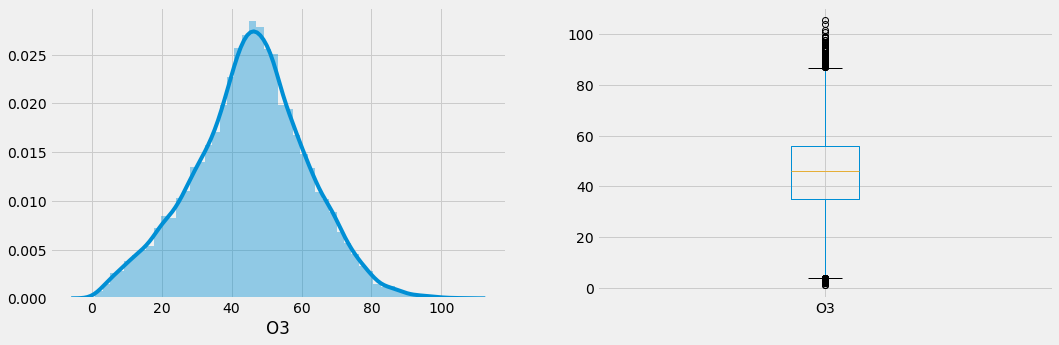

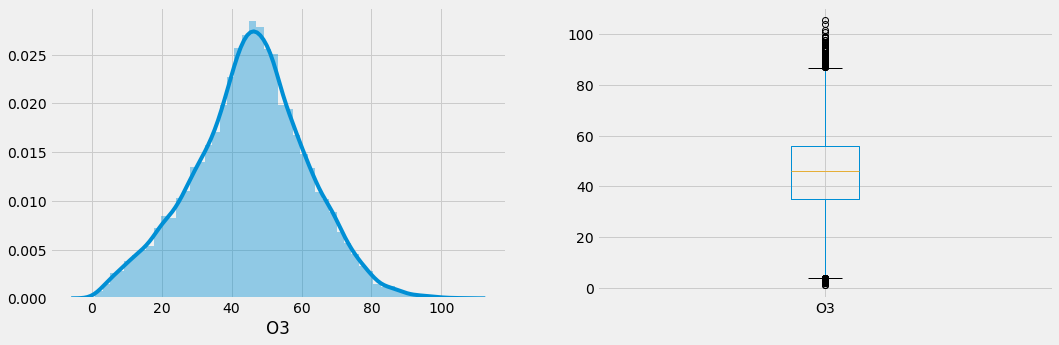

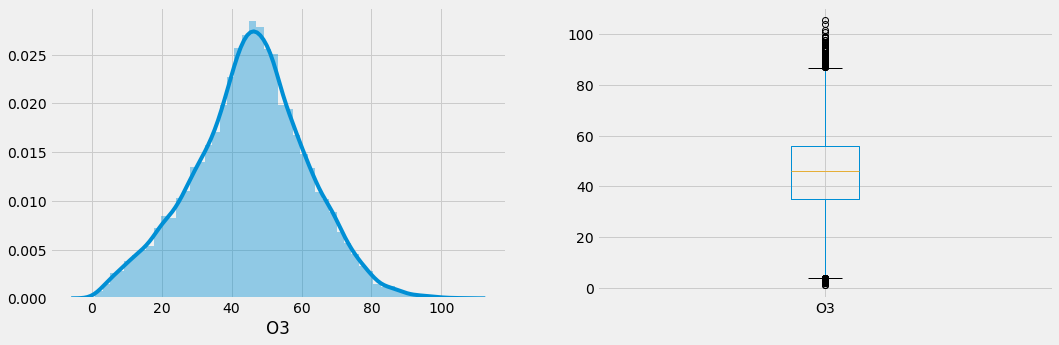

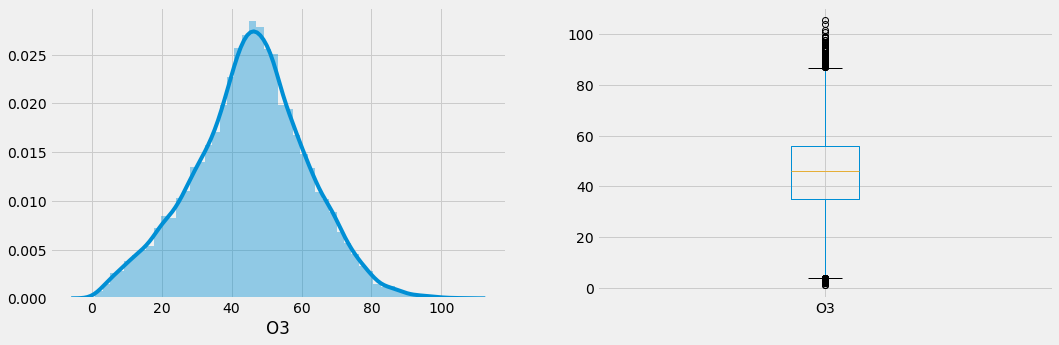

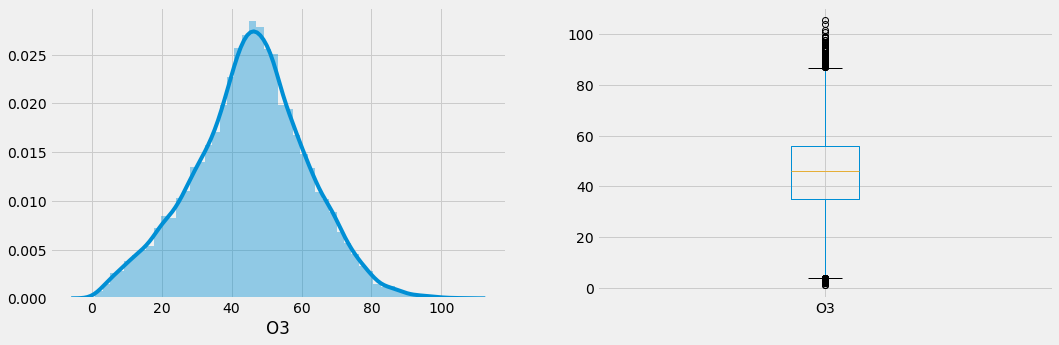

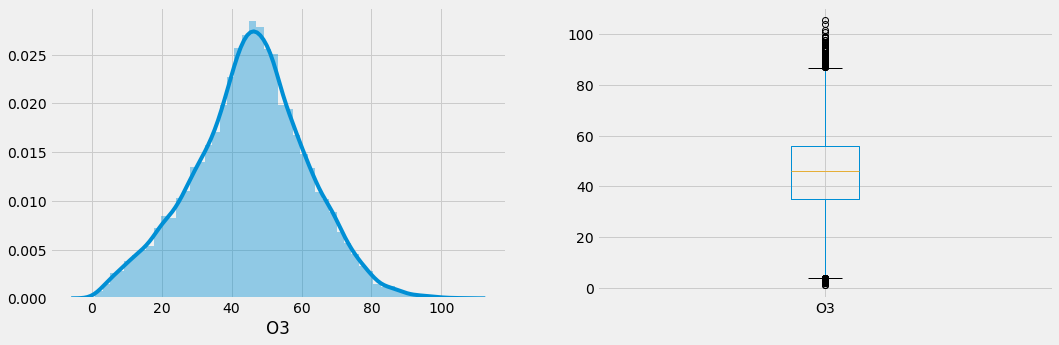

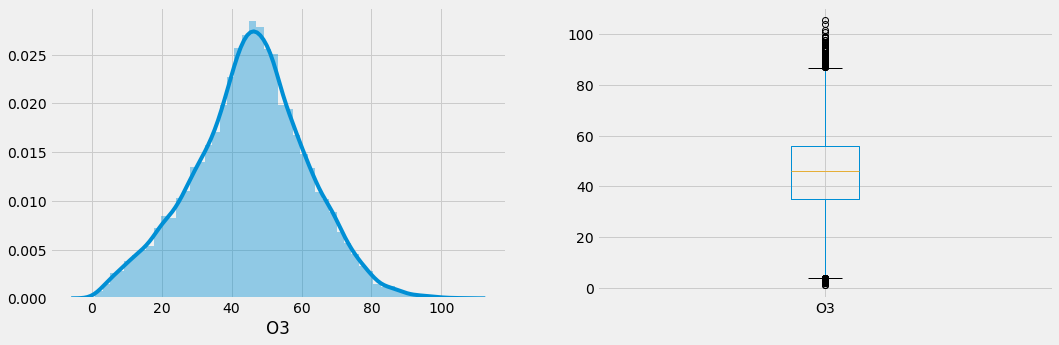

In [48]:
print('ozone across regions')
for r in train['region'].unique():
  t = train[train['region']==r]
  o3(t)

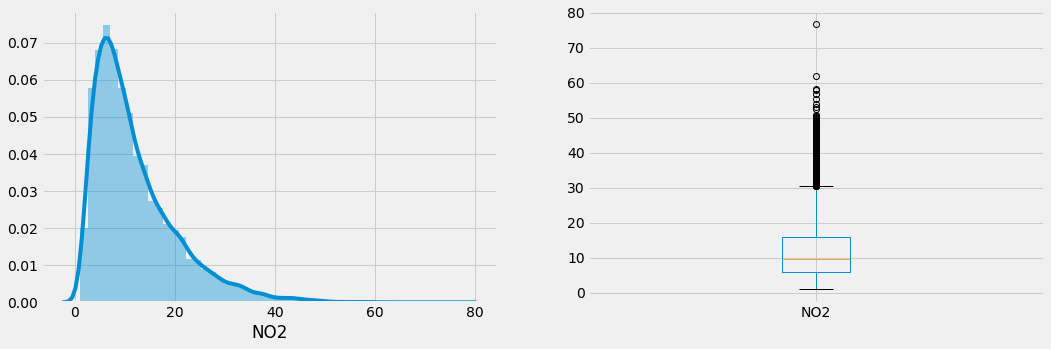

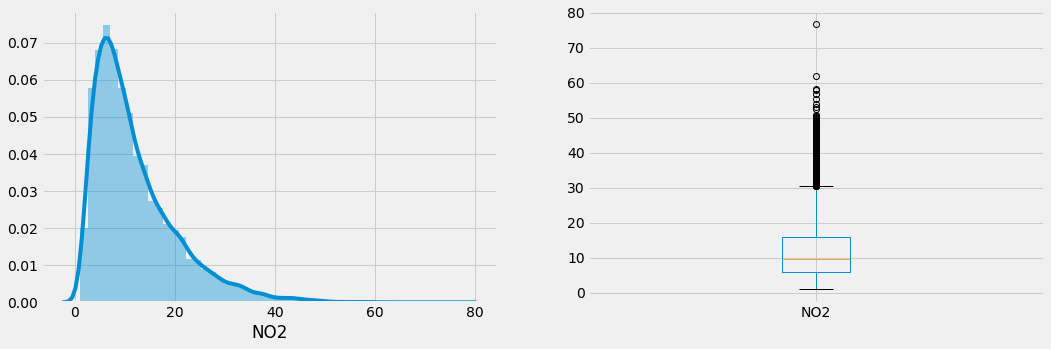

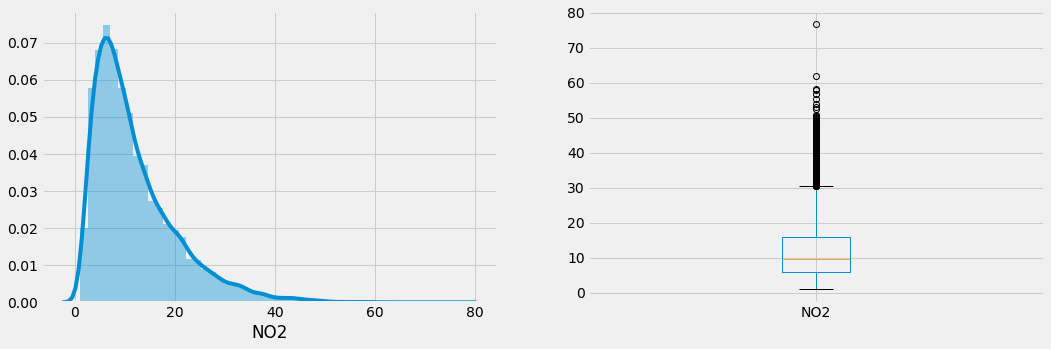

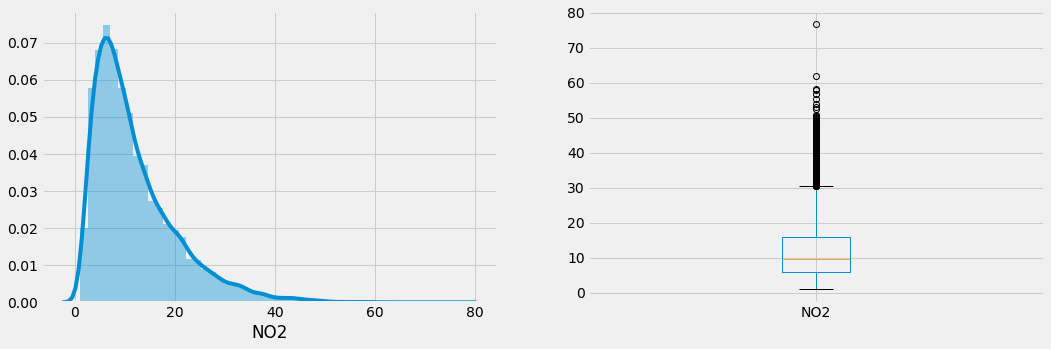

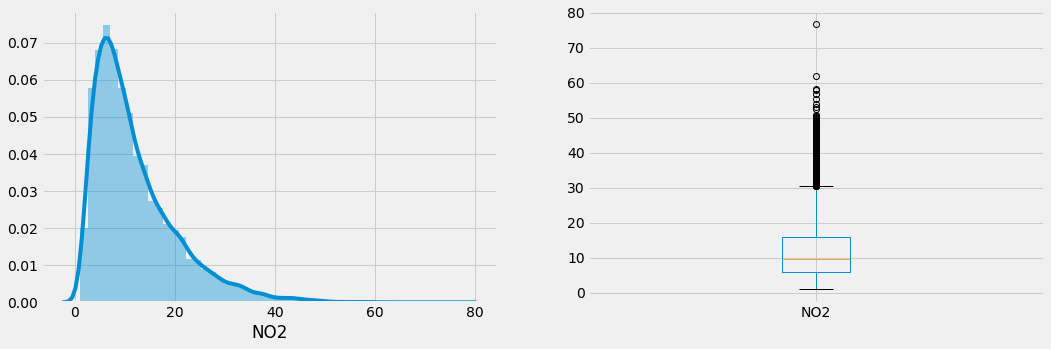

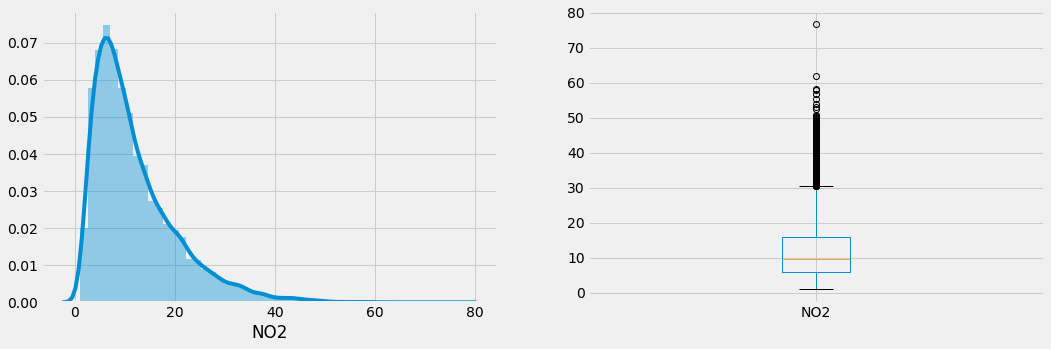

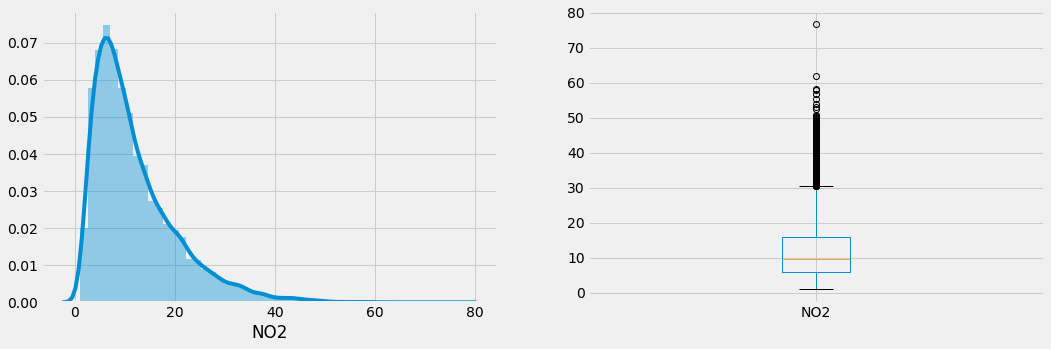

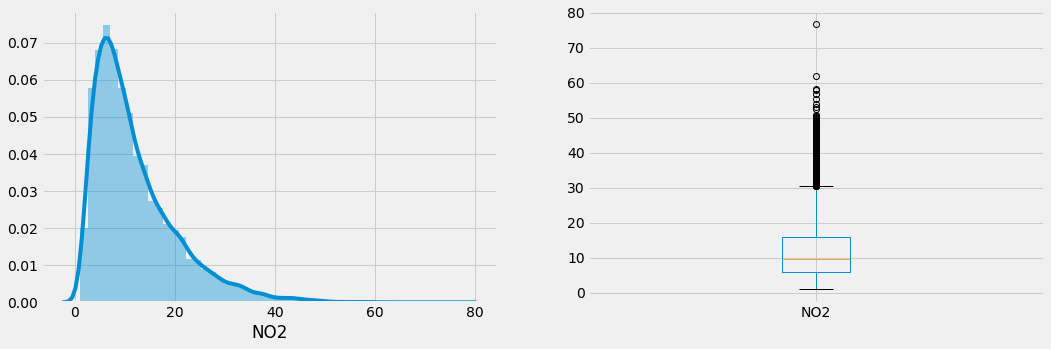

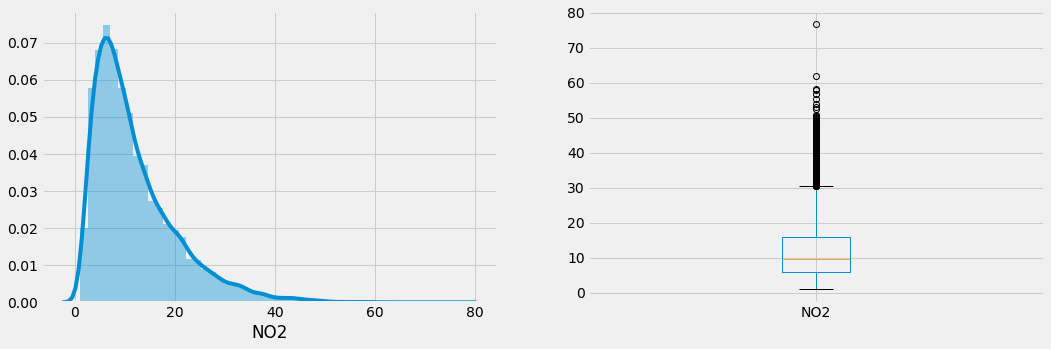

In [49]:
for r in train['region'].unique():
  t = train[train['region']==r]
  no2(t)

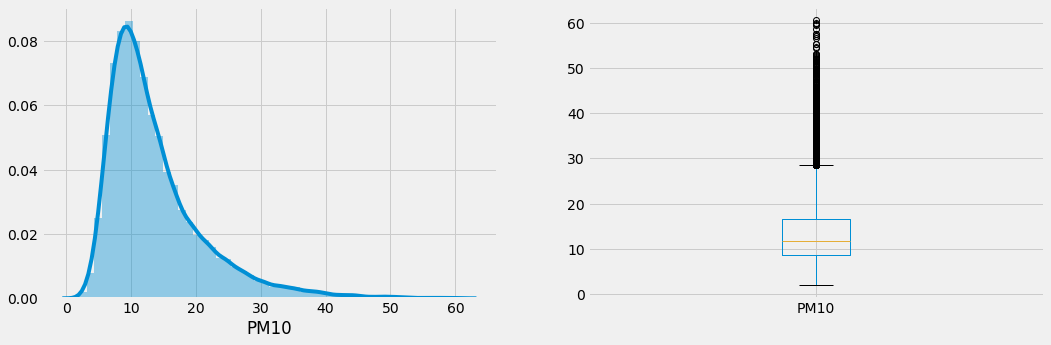

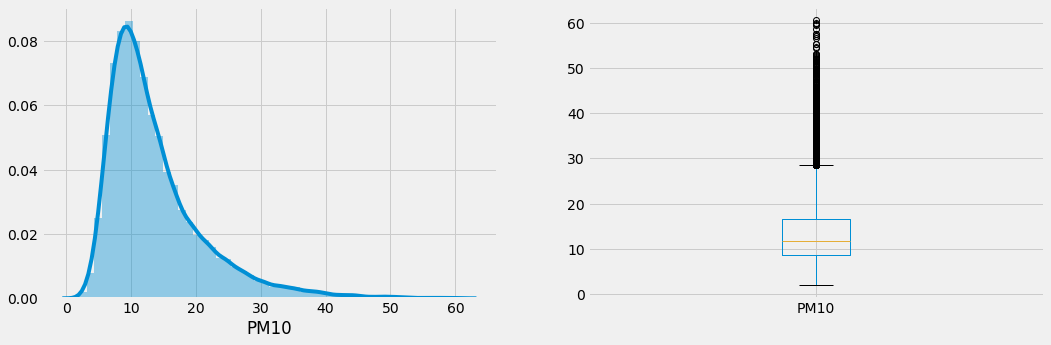

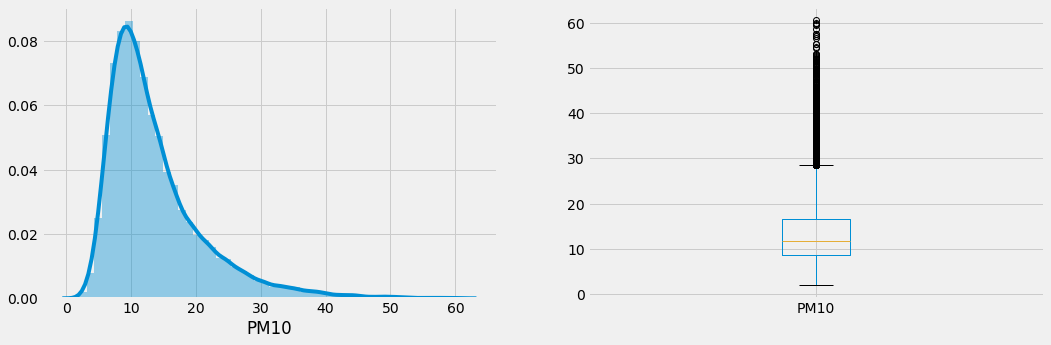

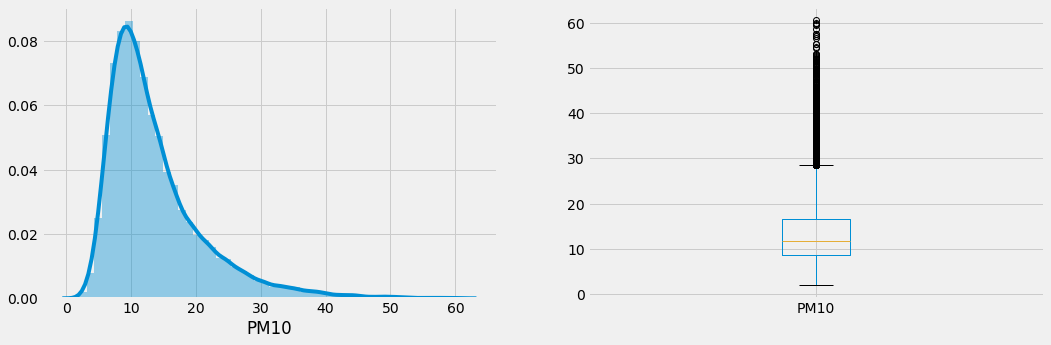

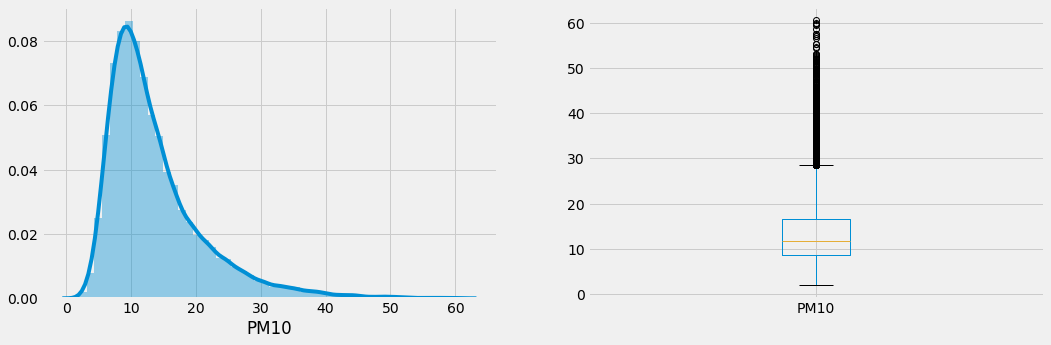

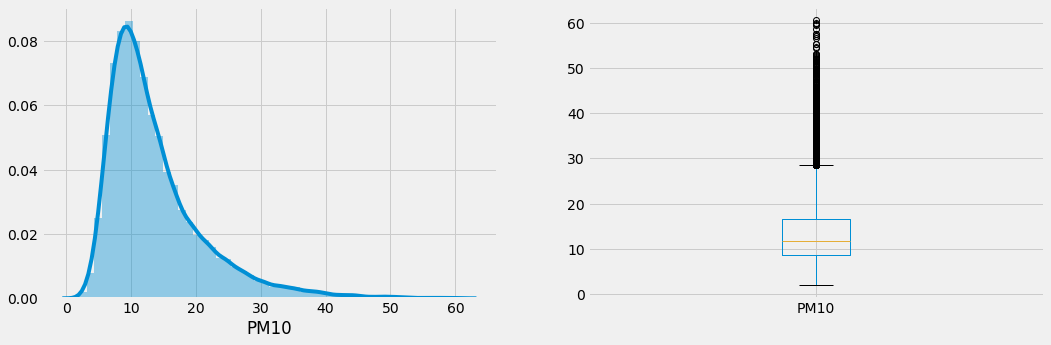

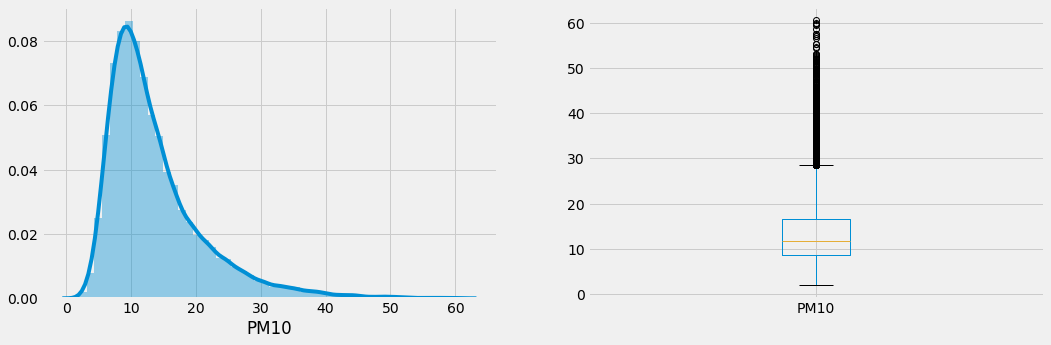

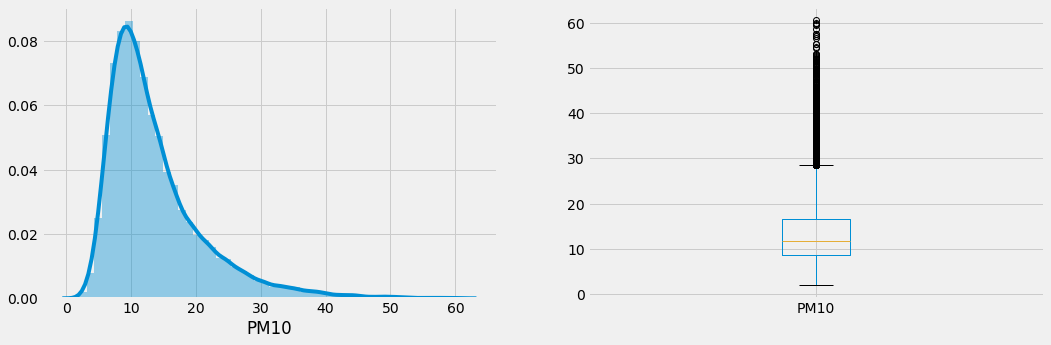

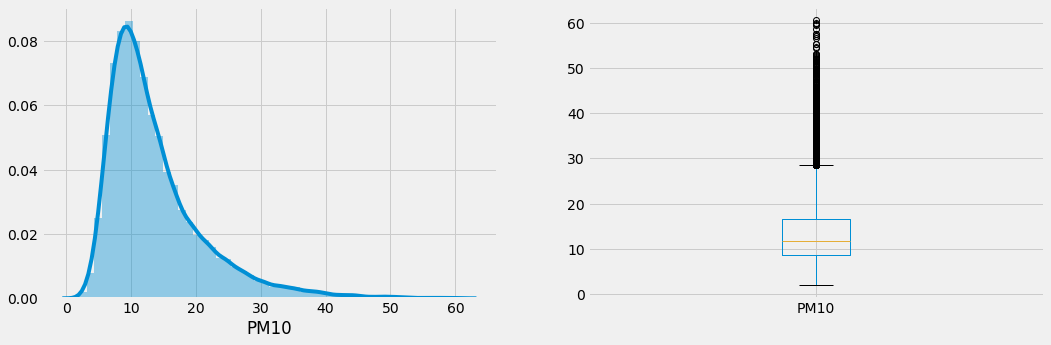

In [50]:
for r in train['region'].unique():
  t = train[train['region']==r]
  pm10(t)
plt.close()

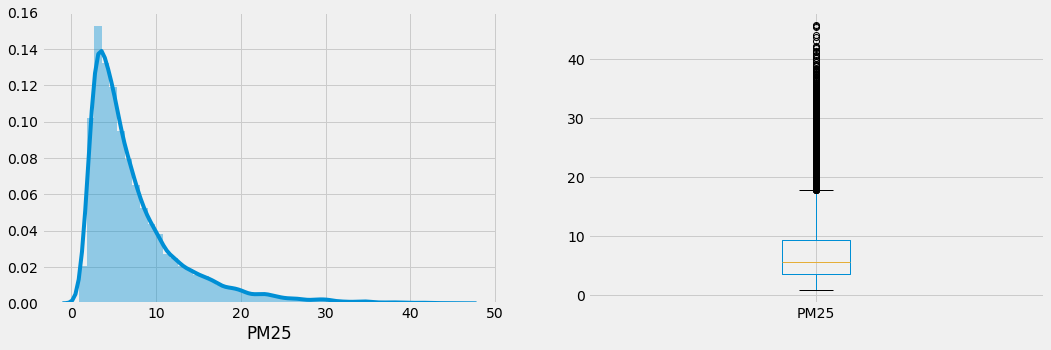

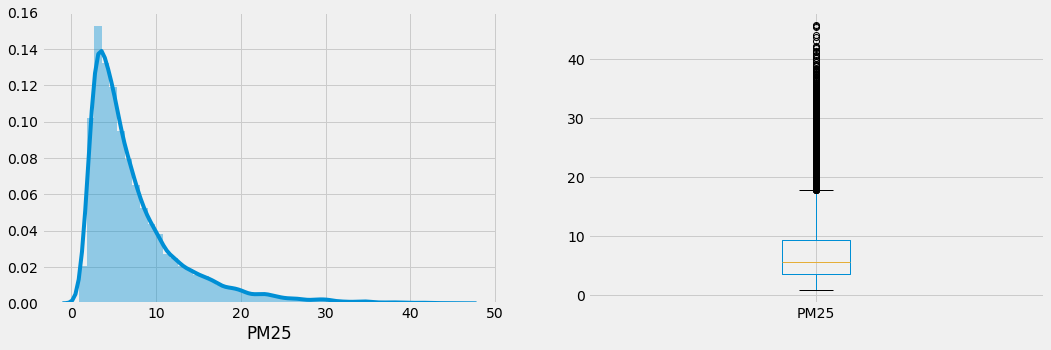

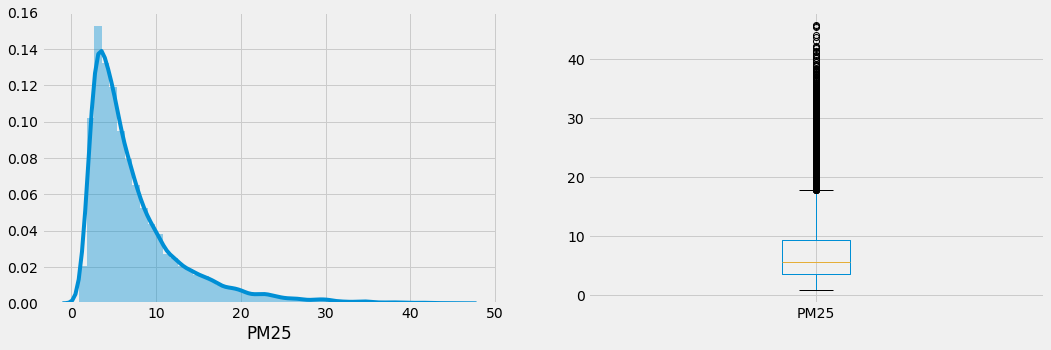

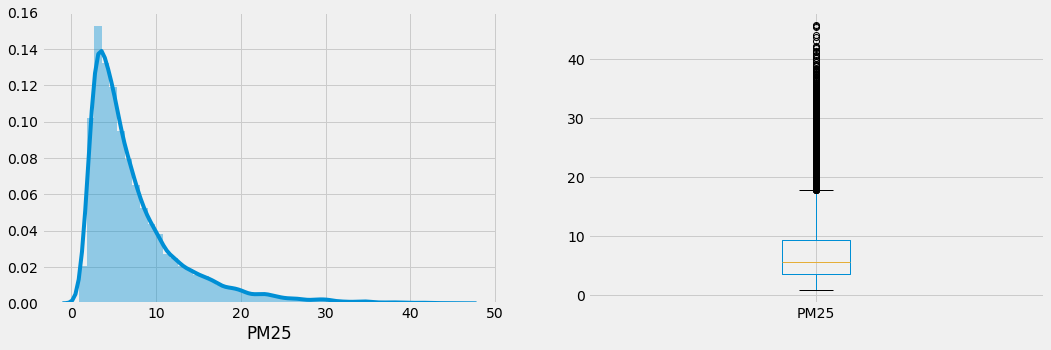

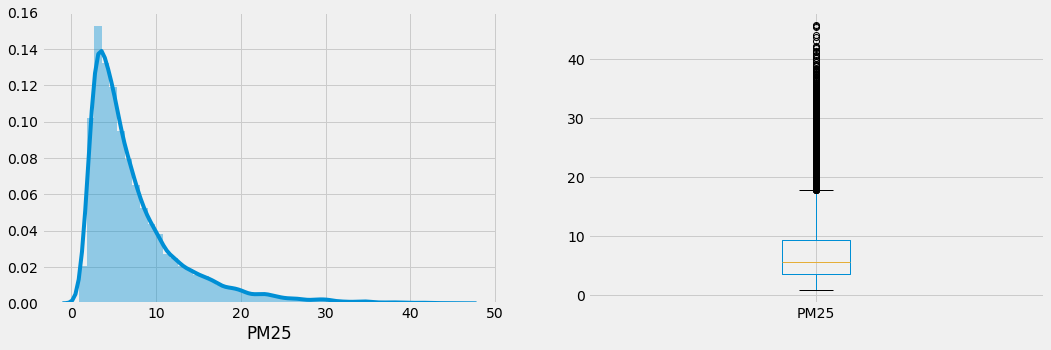

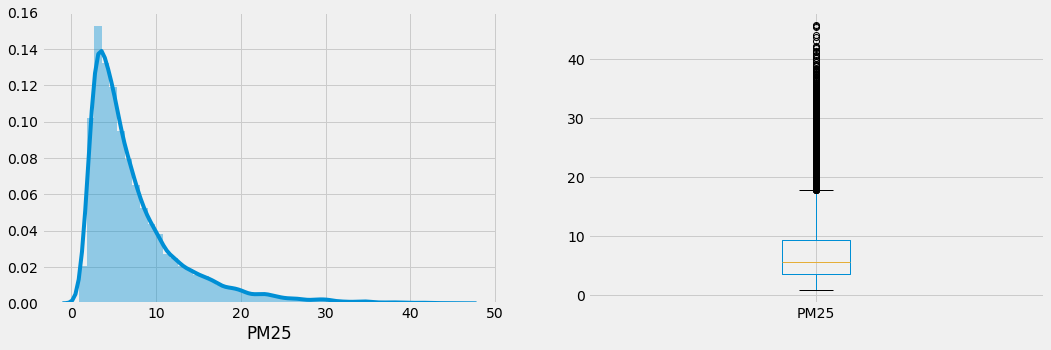

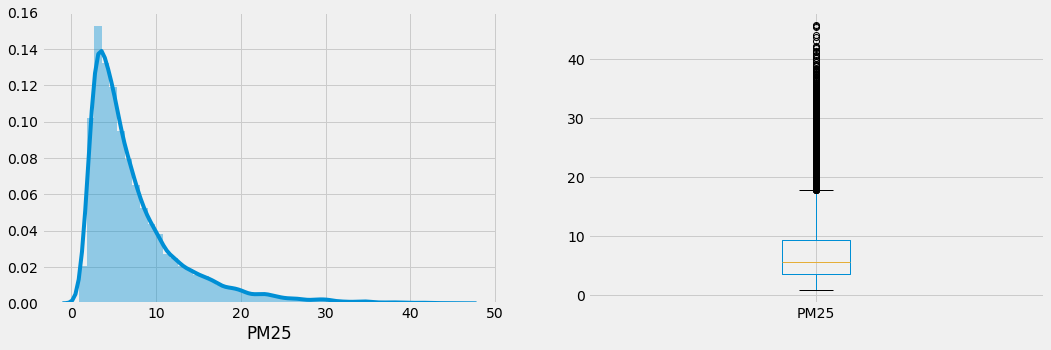

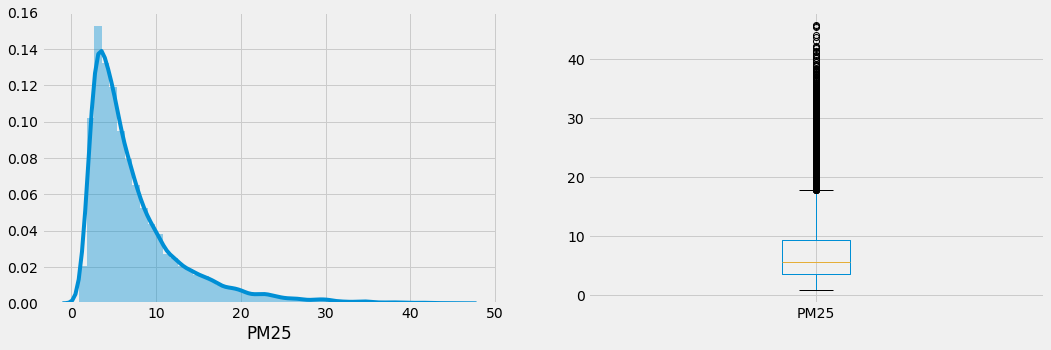

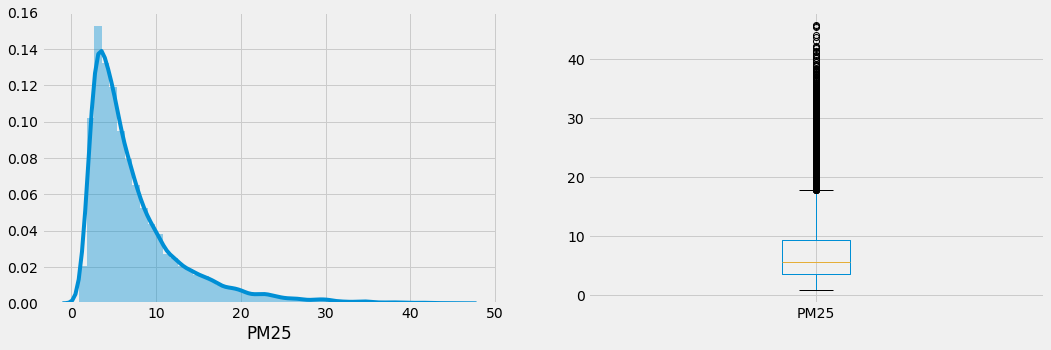

In [51]:
for r in train['region'].unique():
  t = train[train['region']==r]
  pm25(t)
plt.close()

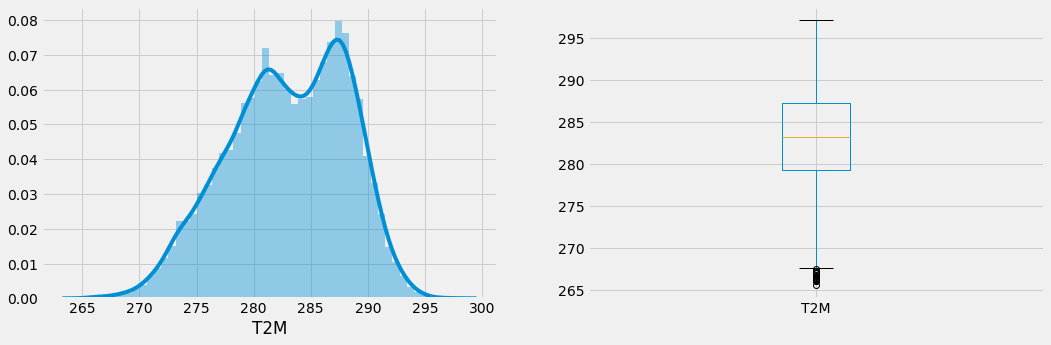

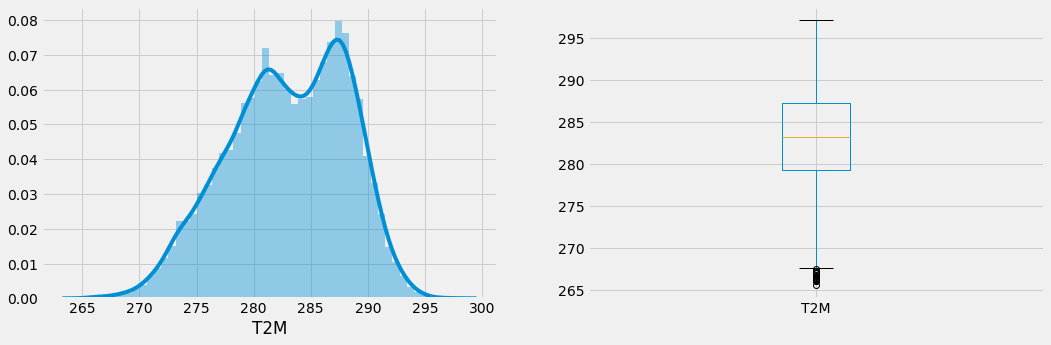

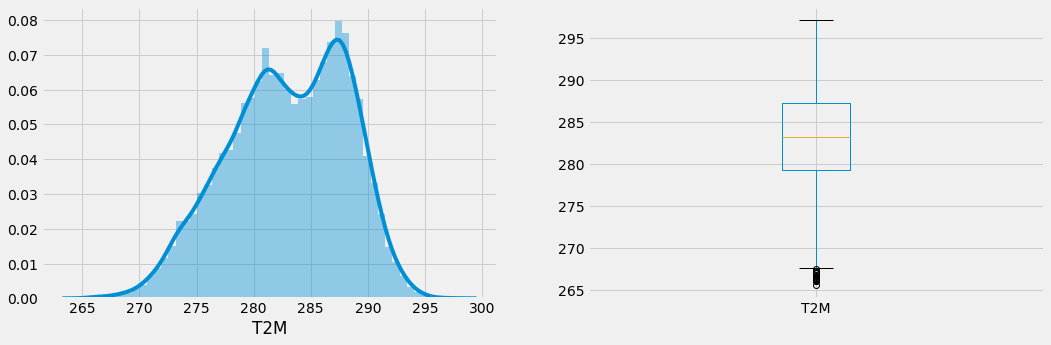

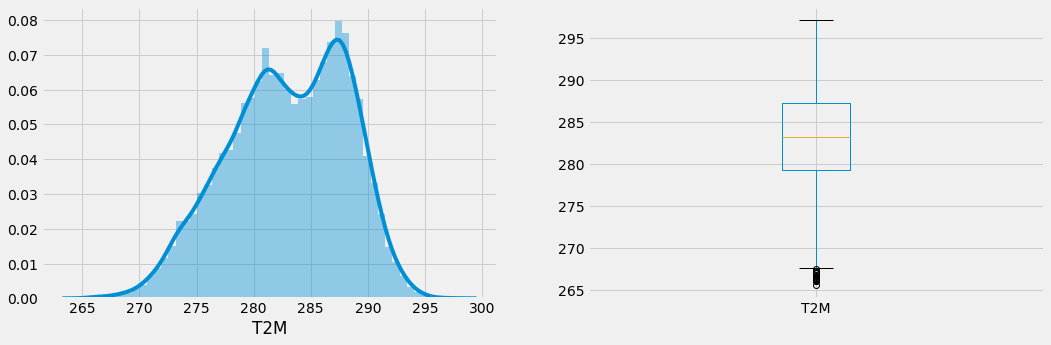

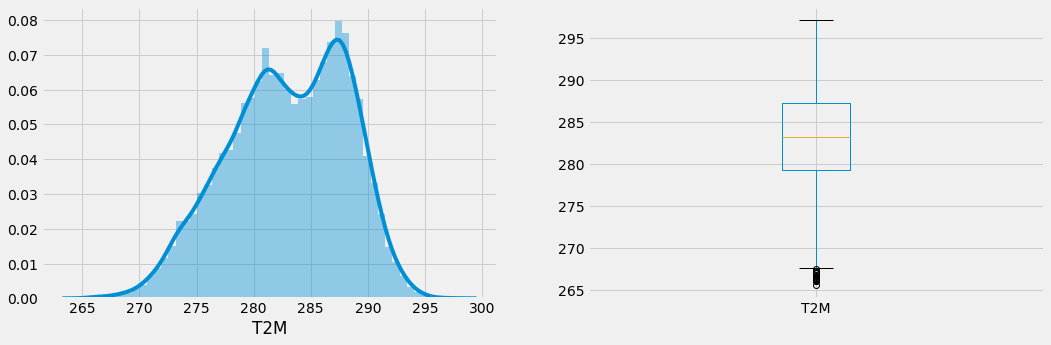

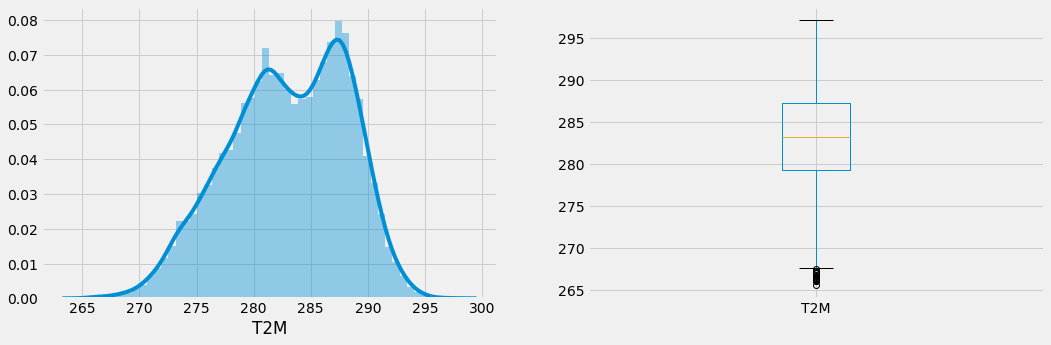

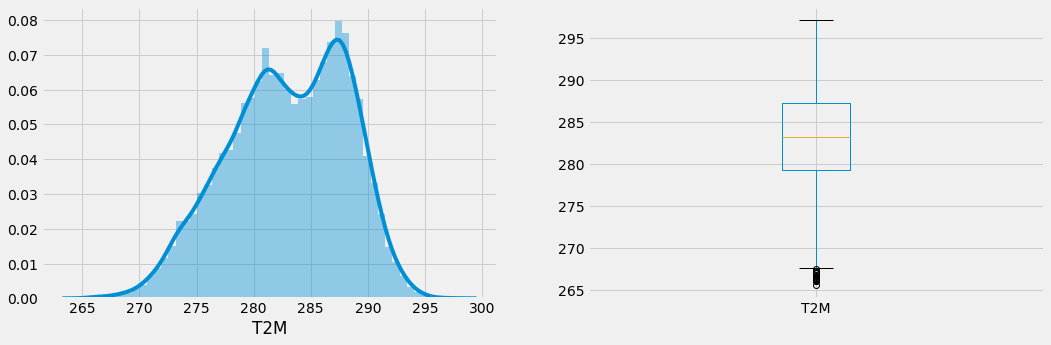

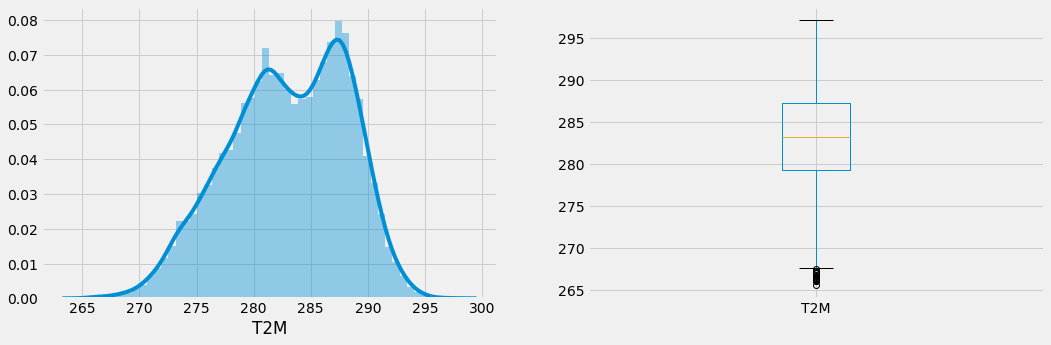

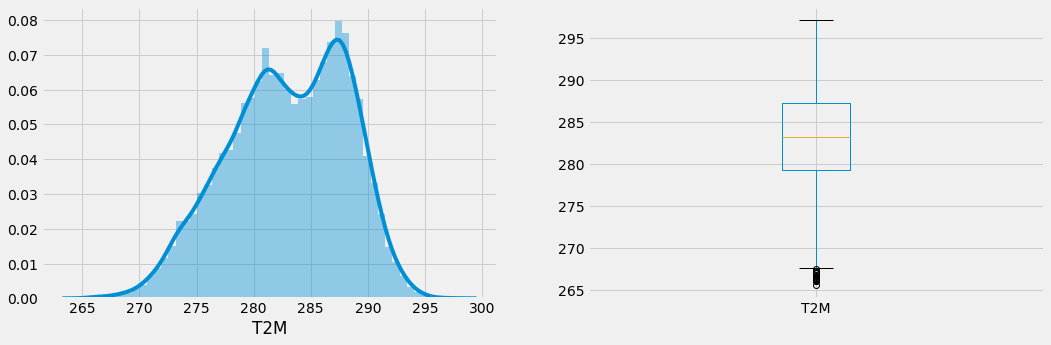

In [52]:
for r in train['region'].unique():
  t = train[train['region']==r]
  t2m(t)
plt.close()

In [0]:
#train1.groupby("region")["Region"].unique()

In [54]:
train1.head()

region       date  mortality_rate  ...      T2M       Code      Region
0  E12000001 2007-01-02           2.264  ...  278.138  E12000001  North East
1  E12000001 2007-01-03           2.030  ...  281.745  E12000001  North East
2  E12000001 2007-01-04           1.874  ...  280.523  E12000001  North East
3  E12000001 2007-01-05           2.069  ...  280.421  E12000001  North East
4  E12000001 2007-01-06           1.913  ...  278.961  E12000001  North East

[5 rows x 10 columns]

## Transformations

# Bivariate analysis - Region Wise

### variation with date - time series plot ##

### For region 1 - North East

In [55]:
train_r1 = train1[train1["Region"]=="North East"]
fig1 = px.line(train_r1, x='date', y='mortality_rate')
fig1.show()

In [56]:
fig2 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1['mortality_rate'])])
#fig2.show()

fig2.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [57]:
fig3 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["O3"])])
#fig2.show()

fig3.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [58]:
fig2 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["PM10"])])
#fig2.show()

fig2.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [59]:
fig4 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["PM25"])])
#fig2.show()

fig4.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [60]:
fig5 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["NO2"])])
#fig2.show()

fig5.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

### scatter plot of PM25 with other variables ###

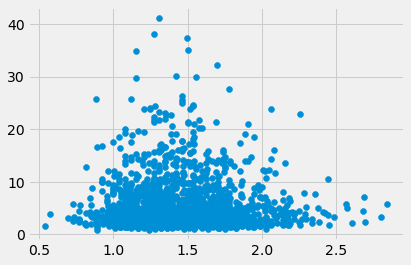

In [61]:
plt.scatter(x=train_r1['mortality_rate'], y=train_r1["PM25"])

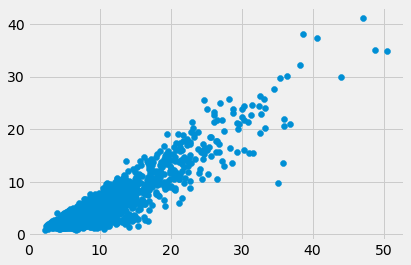

In [62]:
plt.scatter(x=train_r1['PM10'], y=train_r1["PM25"])

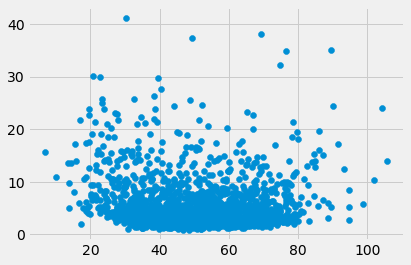

In [63]:
plt.scatter(x=train_r1['O3'], y=train_r1["PM25"])

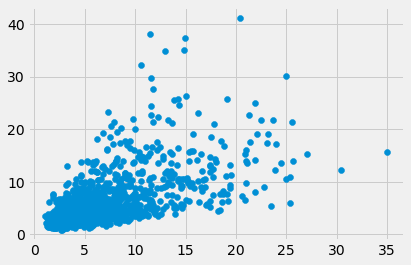

In [64]:
plt.scatter(x=train_r1['NO2'], y=train_r1["PM25"])

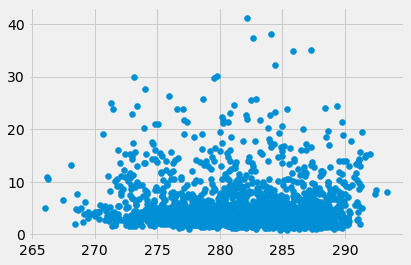

In [65]:
plt.scatter(x=train_r1['T2M'], y=train_r1["PM25"])

### scatter plot of NO2 with other variables ###

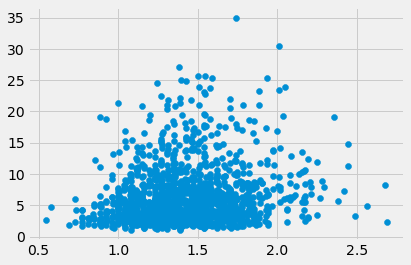

In [66]:
plt.scatter(x=train_r1['mortality_rate'], y=train_r1["NO2"])

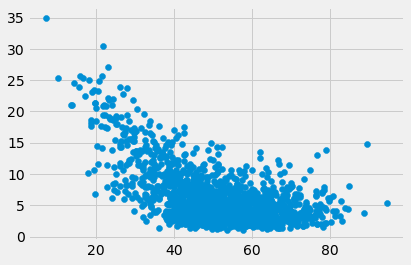

In [67]:
plt.scatter(x=train_r1['O3'], y=train_r1["NO2"])

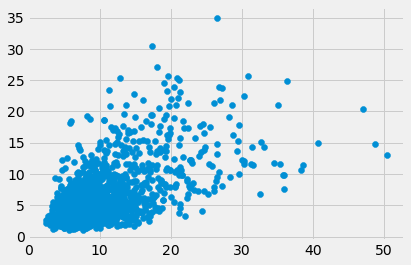

In [68]:
plt.scatter(x=train_r1['PM10'], y=train_r1["NO2"])

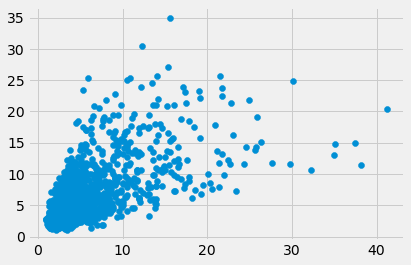

In [69]:
plt.scatter(x=train_r1['PM25'], y=train_r1["NO2"])

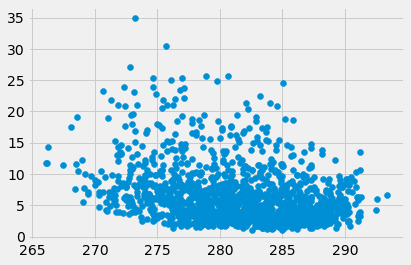

In [70]:
plt.scatter(x=train_r1['T2M'], y=train_r1["NO2"])

# Missing value imputation using MICE 

#### For Region1 - North East

In [71]:
train_r1.head()

region       date  mortality_rate  ...      T2M       Code      Region
0  E12000001 2007-01-02           2.264  ...  278.138  E12000001  North East
1  E12000001 2007-01-03           2.030  ...  281.745  E12000001  North East
2  E12000001 2007-01-04           1.874  ...  280.523  E12000001  North East
3  E12000001 2007-01-05           2.069  ...  280.421  E12000001  North East
4  E12000001 2007-01-06           1.913  ...  278.961  E12000001  North East

[5 rows x 10 columns]

In [72]:
train_r1.isna().sum()

region              0
date                0
mortality_rate      0
O3                  1
PM10                1
PM25              364
NO2               730
T2M                 0
Code                0
Region              0
dtype: int64

In [73]:
train_r1.drop(columns=["region","date", "Code", "Region"], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
# start the MICE training
train_r1_imp=mice(train_r1.values)

In [0]:
train_r1_imp = pd.DataFrame(train_r1_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

In [76]:
train_r1_imp.isna().sum()

mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               0
T2M               0
dtype: int64

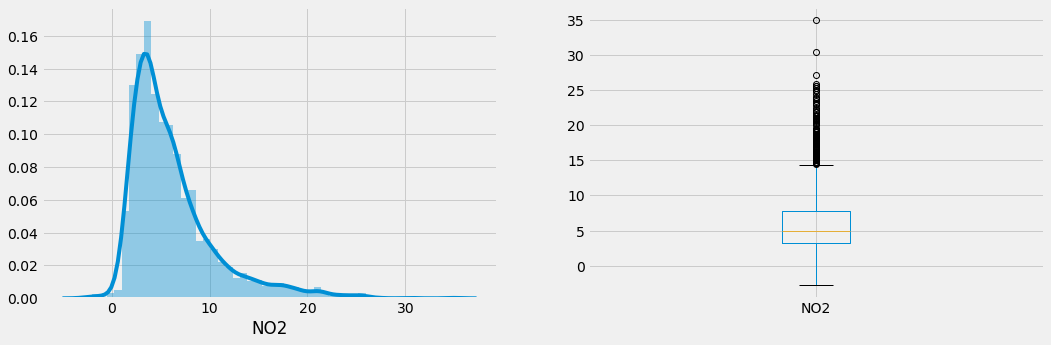

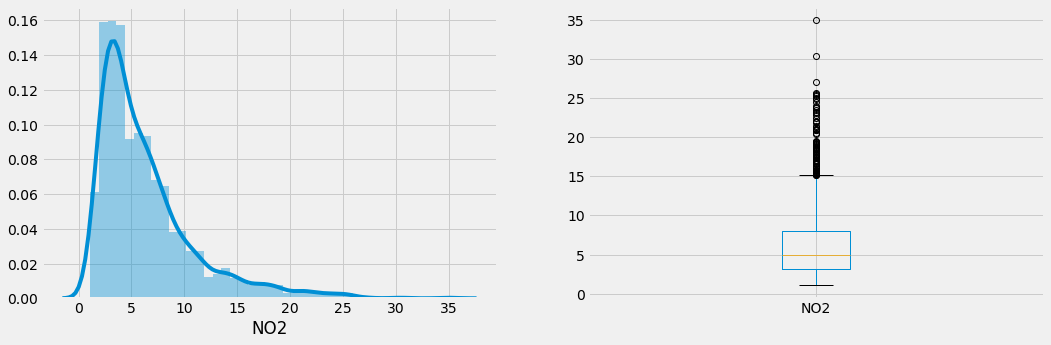

In [77]:
# Visualizing NO2
# plt.figure(1)
plt.subplot(121)
NO2_1 = train_r1_imp['NO2'].dropna()
sns.distplot(NO2_1);

plt.subplot(122)
NO2_1.plot.box(figsize=(16,5))

plt.show()


plt.subplot(121)
NO2_1 = train_r1['NO2'].dropna()
sns.distplot(NO2_1);

plt.subplot(122)
NO2_1.plot.box(figsize=(16,5))

plt.show()

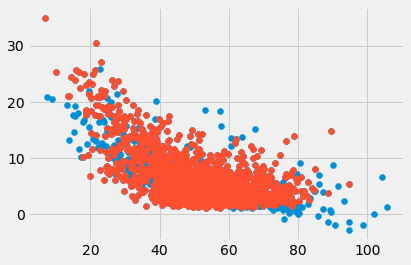

In [78]:
plt.scatter(x=train_r1_imp['O3'], y=train_r1_imp["NO2"])
plt.scatter(x=train_r1['O3'], y=train_r1["NO2"])

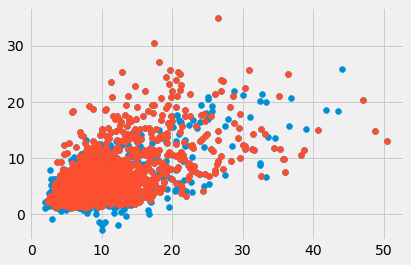

In [79]:
plt.scatter(x=train_r1_imp['PM10'], y=train_r1_imp["NO2"])
plt.scatter(x=train_r1['PM10'], y=train_r1["NO2"])

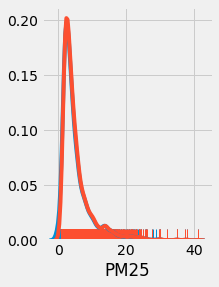

In [80]:
# Visualizing NO2
# plt.figure(1)
plt.subplot(121)
NO2_1_imp = train_r1_imp['PM25'].dropna()
NO2_1 = train_r1['PM25'].dropna()
#sns.distplot(NO2_1_imp)
#sns.distplot(NO2_1)

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)


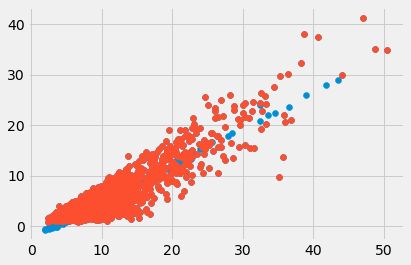

In [81]:
plt.scatter(x=train_r1_imp['PM10'], y=train_r1_imp["PM25"])
plt.scatter(x=train_r1['PM10'], y=train_r1["PM25"])

In [82]:
train_r1_imp['PM25'].describe(), train_r1['PM25'].describe()

(count    2191.000000
 mean        5.203044
 std         4.765004
 min        -0.656271
 25%         2.325434
 50%         3.636000
 75%         6.168487
 max        41.255000
 Name: PM25, dtype: float64, count    1827.000000
 mean        5.368816
 std         4.773007
 min         0.904000
 25%         2.451500
 50%         3.802000
 75%         6.269000
 max        41.255000
 Name: PM25, dtype: float64)

In [83]:
train_r1_imp['NO2'].describe(), train_r1['NO2'].describe()

(count    2191.000000
 mean        6.164154
 std         4.378407
 min        -2.754285
 25%         3.228438
 50%         4.988000
 75%         7.738791
 max        34.990000
 Name: NO2, dtype: float64, count    1461.000000
 mean        6.353291
 std         4.572821
 min         1.104000
 25%         3.172000
 50%         4.988000
 75%         7.971000
 max        34.990000
 Name: NO2, dtype: float64)

In [0]:
## changing negative values to min value
#train_r1_imp['PM25'] = np.where(train_r1_imp['PM25']<=0, 0.904000, train_r1_imp['PM25'] )
#train_r1_imp['NO2'] = np.where(train_r1_imp['NO2']<=0, 1.104000, train_r1_imp['NO2'] )

train_r1_imp['NO2']=train_r1_imp['NO2'].apply(lambda x: f(x))
train_r1_imp['PM25']=train_r1_imp['PM25'].apply(lambda x: f(x))
train_r1_imp.ffill(axis=0, inplace=True)

In [85]:
## changing negative values to min value
train_r1_imp.describe()

mortality_rate           O3  ...          NO2          T2M
count     2191.000000  2191.000000  ...  2191.000000  2191.000000
mean         1.473910    50.540317  ...     6.174300   281.815754
std          0.317746    14.304483  ...     4.364206     4.943598
min          0.544000     7.022000  ...     0.013978   266.057000
25%          1.249000    41.314000  ...     3.228438   278.274500
50%          1.444000    50.098000  ...     4.988000   282.001000
75%          1.666000    59.553500  ...     7.738791   285.899500
max          2.841000   105.693000  ...    34.990000   293.376000

[8 rows x 6 columns]

#### Since we are getting good enough results region wise we can impute PM25 and NO2 on the basis of regions

### Region wise imputation

In [86]:
train1.head()

region       date  mortality_rate  ...      T2M       Code      Region
0  E12000001 2007-01-02           2.264  ...  278.138  E12000001  North East
1  E12000001 2007-01-03           2.030  ...  281.745  E12000001  North East
2  E12000001 2007-01-04           1.874  ...  280.523  E12000001  North East
3  E12000001 2007-01-05           2.069  ...  280.421  E12000001  North East
4  E12000001 2007-01-06           1.913  ...  278.961  E12000001  North East

[5 rows x 10 columns]

In [87]:
regions = list(region["Region"].values)
train_imp = pd.DataFrame()

for reg in regions:
    
    train_r = train1[train1["Region"] == reg].reset_index(drop=True)
    train_r_imp = mice(train_r.drop(["region","date", "Code", "Region"], axis = 1).values)
    train_r_imp = pd.DataFrame(train_r_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])
    
    ## changing negative values to min value
    train_r_imp['PM25'] = np.where(train_r_imp['PM25']<=0, min(train_r['PM25']), train_r_imp['PM25'] )
    
    ## changing negative values to min value
    train_r_imp['NO2'] = np.where(train_r_imp['NO2']<=0, min(train_r['NO2']), train_r_imp['NO2'] )
    
    print("\n\n")
    print("train_r = before", train_r.isna().sum())
    
    train_r['PM25'] = train_r_imp['PM25']
    train_r['NO2'] = train_r_imp['NO2']
    train_r['O3'] = train_r_imp['O3']
    train_r['PM10'] = train_r_imp['PM10']
    
    print("train_r_imp = \n", train_r_imp.isna().sum())
    print("train_r = \n", train_r.isna().sum())
    print("----------------------------------------")
    
    train_imp = train_imp.append(train_r)
    
print("train_imp = ", train_imp.isna().sum(), '\n')
    
    




train_r = before region              0
date                0
mortality_rate      0
O3                  1
PM10                1
PM25              364
NO2               730
T2M                 0
Code                0
Region              0
dtype: int64
train_r_imp = 
 mortality_rate     0
O3                 0
PM10               0
PM25              13
NO2                8
T2M                0
dtype: int64
train_r = 
 region             0
date               0
mortality_rate     0
O3                 0
PM10               0
PM25              13
NO2                8
T2M                0
Code               0
Region             0
dtype: int64
----------------------------------------



train_r = before region              0
date                0
mortality_rate      0
O3                  1
PM10                1
PM25              364
NO2               730
T2M                 0
Code                0
Region              0
dtype: int64
train_r_imp = 
 mortality_rate    0
O3                0
PM10   

In [0]:
pd.set_option('display.max_rows', None)
#train_imp
                                    

In [89]:
train_imp.describe()

mortality_rate            O3  ...           NO2           T2M
count    18403.000000  18403.000000  ...  18383.000000  18403.000000
mean         1.301737     45.319634  ...     12.127066    283.002235
std          0.304161     16.221104  ...      8.235103      5.182186
min          0.439000      0.988000  ...      0.013978    265.562000
25%          1.102000     35.067500  ...      6.187929    279.321500
50%          1.281000     45.830000  ...      9.880000    283.270000
75%          1.474000     55.880000  ...     15.954000    287.240500
max          2.841000    105.693000  ...     76.765000    297.209000

[8 rows x 6 columns]

In [90]:
train_imp.head()

region       date  mortality_rate  ...      T2M       Code      Region
0  E12000001 2007-01-02           2.264  ...  278.138  E12000001  North East
1  E12000001 2007-01-03           2.030  ...  281.745  E12000001  North East
2  E12000001 2007-01-04           1.874  ...  280.523  E12000001  North East
3  E12000001 2007-01-05           2.069  ...  280.421  E12000001  North East
4  E12000001 2007-01-06           1.913  ...  278.961  E12000001  North East

[5 rows x 10 columns]

In [91]:
temp_r_imp = mice(train_imp.drop(columns=['region','date','Code','Region']).values)
temp_r_imp = pd.DataFrame(temp_r_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

train_r_imp_full = train_imp.copy()
train_r_imp_full["NO2"] = temp_r_imp["NO2"]
train_r_imp_full["PM25"] = temp_r_imp["PM25"]
train_r_imp_full["O3"] = temp_r_imp["O3"]
train_r_imp_full["PM10"] = temp_r_imp["PM10"]

train_r_imp_full.isna().sum()  #### FINAL DATAFRAME WITH IMPUTED VALUES REGION WISE

region            0
date              0
mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               0
T2M               0
Code              0
Region            0
dtype: int64

In [92]:
train_r_imp_full.shape, train1.shape

((18403, 10), (18403, 10))

In [93]:
train_r_imp_full.head()

region       date  mortality_rate  ...      T2M       Code      Region
0  E12000001 2007-01-02           2.264  ...  278.138  E12000001  North East
1  E12000001 2007-01-03           2.030  ...  281.745  E12000001  North East
2  E12000001 2007-01-04           1.874  ...  280.523  E12000001  North East
3  E12000001 2007-01-05           2.069  ...  280.421  E12000001  North East
4  E12000001 2007-01-06           1.913  ...  278.961  E12000001  North East

[5 rows x 10 columns]

In [94]:
train_r_imp_full['NO2'].describe()

count    18403.000000
mean         6.137423
std          4.403698
min         -5.495204
25%          3.220000
50%          4.971415
75%          7.737107
max         34.990000
Name: NO2, dtype: float64

In [95]:
train1['NO2'].describe()

count    11833.000000
mean        12.045813
std          8.296675
min          1.104000
25%          6.056000
50%          9.769000
75%         15.858000
max         76.765000
Name: NO2, dtype: float64

In [96]:
train_r_imp_full['PM25'].describe()

count    18403.000000
mean         5.162043
std          4.756403
min         -0.993929
25%          2.272000
50%          3.572000
75%          6.127000
max         41.255000
Name: PM25, dtype: float64

In [97]:
train1['PM25'].describe()

count    15127.000000
mean         7.498714
std          5.758357
min          0.904000
25%          3.624000
50%          5.636000
75%          9.326500
max         45.846000
Name: PM25, dtype: float64

In [0]:
train_r_imp_full['NO2']=train_r_imp_full['NO2'].apply(lambda x: f(x))
train_r_imp_full['PM25']=train_r_imp_full['PM25'].apply(lambda x: f(x))
train_r_imp_full.ffill(axis=0, inplace=True)

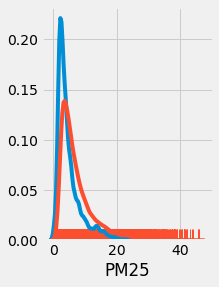

In [99]:
plt.subplot(121)
NO2_1= train1['PM25'].dropna()
NO2_1_imp  = train_r_imp_full['PM25'].dropna()

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)

Region wise imputation is fine but at an overall level it does not suits well..

### Impution on full data - MICE

In [0]:
# start the MICE training
temp_imp = mice(train1.drop(["region","date", "Code", "Region"], axis = 1).values)
temp_imp = pd.DataFrame(temp_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

train_full_imp = train1.copy()
train_full_imp["NO2"] = temp_imp["NO2"]
train_full_imp["PM25"] = temp_imp["PM25"]
train_full_imp["O3"] = temp_imp["O3"]
train_full_imp["PM10"] = temp_imp["PM10"]

In [101]:
train_full_imp.isna().sum() ### FINAL DATAFRAME WITH IMPUTATION ON FULL DATA

region            0
date              0
mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               0
T2M               0
Code              0
Region            0
dtype: int64

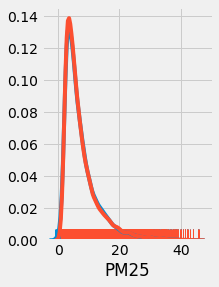

In [102]:
plt.subplot(121)
NO2_1= train1['PM25'].dropna()
NO2_1_imp  = train_full_imp['PM25'].dropna()

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)

# Imputation using KNN

In [0]:
imputer = KNNImputer(n_neighbors=5, add_indicator=True)

In [0]:
#imputer.fit(train.drop(["region","date", "Code", "Region"], axis = 1))
imputer.fit(train.drop(["region","date"], axis = 1))
train_knn = pd.DataFrame(imputer.transform(train.drop(["region","date"], axis = 1)),
                         columns = ['mortality_rate','O3','PM10','PM25','NO2','T2M','MI1','MI2','MI3','MI4'])
train_knn.index = train.index
train_knn[['region','date']] = train[['region','date']]

In [105]:
train.head()

region       date  mortality_rate      O3   PM10  PM25  NO2      T2M
Id                                                                         
1   E12000001 2007-01-02           2.264  42.358  9.021   NaN  NaN  278.138
2   E12000001 2007-01-03           2.030  49.506  5.256   NaN  NaN  281.745
3   E12000001 2007-01-04           1.874  51.101  4.946   NaN  NaN  280.523
4   E12000001 2007-01-05           2.069  47.478  6.823   NaN  NaN  280.421
5   E12000001 2007-01-06           1.913  45.226  7.532   NaN  NaN  278.961

In [106]:
train_knn.head()

mortality_rate      O3   PM10    PM25  ...  MI3  MI4     region       date
Id                                         ...                                
1            2.264  42.358  9.021  4.0380  ...  1.0  1.0  E12000001 2007-01-02
2            2.030  49.506  5.256  2.3710  ...  1.0  1.0  E12000001 2007-01-03
3            1.874  51.101  4.946  2.2176  ...  1.0  1.0  E12000001 2007-01-04
4            2.069  47.478  6.823  3.8032  ...  1.0  1.0  E12000001 2007-01-05
5            1.913  45.226  7.532  3.4798  ...  1.0  1.0  E12000001 2007-01-06

[5 rows x 12 columns]

# Feature Engineering

one hot encoding for regions

In [0]:
def sets(df1,df2):
    dummy1= pd.get_dummies(df1['region'])
    train_f = df1.join(dummy1)

    dummy2= pd.get_dummies(df2['region'])
    test_f = df2.join(dummy2)

    return (train_f, test_f)

In [0]:
def day_and_year(df1,df2):
    df1['year'] = df1['date'].map(lambda x: x.year)
    df2['year'] = df2['date'].map(lambda x: x.year)

    df1['year^2'] = df1['year']**2
    df2['year^2'] = df2['year']**2

    df1['doy'] = df1['date'].map(lambda x: x.dayofyear)
    df2['doy'] = df2['date'].map(lambda x: x.dayofyear)

    df1['doy^2'] = df1['doy']**2
    df2['doy^2'] = df2['doy']**2

    return (df1,df2)

In [0]:
def log_transform(df1,df2):
    df1['NO2_log']=np.log(df1['NO2'])
    df1['PM10_log']=np.log(df1['PM10'])
    df1['PM25_log']=np.log(df1['PM25'])

    df2['NO2_log']=np.log(df2['NO2'])
    df2['PM10_log']=np.log(df2['PM10'])
    df2['PM25_log']=np.log(df2['PM25'])

    return (df1,df2)

In [0]:
def rolling(df1,df2):
    total_f=total=pd.concat([df1,df2],sort=False)
    total_f['T2M_rolling'] = total_f.groupby('region')['T2M'].transform(lambda x: x.rolling(30).mean())
    df1=total_f[:18403].dropna()
    df2=total_f[18403:].drop(['mortality_rate'],axis=1)
    return (df1, df2)

In [0]:
ridge_dist = dict(alpha=sps.uniform(loc=0.0001, scale=50))
lasso_dist = dict(alpha=sps.uniform(loc=0.0001, scale=10))
rf_dist = {'max_depth': [2,5,8,10]
           }
           
inner_cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [0]:
def print_scores(cv_score_linear,nested_score_ridge,nested_score_lasso,nested_score_rf):
    print('Avg. RMSE Linear Regression:',np.sqrt(cv_score_linear.mean()))
    print('Avg. RMSE Ridge:',np.sqrt(nested_score_ridge.mean()))
    print('Avg. RMSE Lasso:',np.sqrt(nested_score_lasso.mean()))
    print('Avg. RMSE RF:',np.sqrt(nested_score_rf.mean()))

In [0]:
RMSE= make_scorer(metrics.mean_squared_error)

In [0]:
def models(X,y):
    reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)
    reg_lasso = RandomizedSearchCV(estimator=Lasso(random_state=SEED), param_distributions=lasso_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)
    reg_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)

    nested_score_ridge = cross_val_score(reg_ridge, X = X, y=y, cv=outer_cv,scoring=RMSE)
    nested_score_lasso = cross_val_score(reg_lasso, X = X, y=y, cv=outer_cv,scoring=RMSE)
    cv_score_linear = cross_val_score(LinearRegression(), X = X, y=y, cv=outer_cv,scoring=RMSE)
    nested_score_rf = cross_val_score(reg_rf, X = X, y=y, cv=outer_cv,scoring=RMSE)
    print_scores(cv_score_linear,nested_score_ridge,nested_score_lasso,nested_score_rf)

In [0]:
def xgbr(X,y):
    reg_xgb = GridSearchCV(estimator=xgb.XGBRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)
    nested_score_xgb = cross_val_score(reg_xgb, X = X, y=y, cv=outer_cv,scoring=RMSE)

    print(np.sqrt(nested_score_xgb.mean()))

# Modelling After Dropping Missing Values

In [0]:
train_f, test_f = sets(train, test)

In [0]:
train_f, test_f = day_and_year(train_f, test_f)

In [0]:
train_f, test_f = log_transform(train_f,test_f)

In [0]:
train_f, test_f = rolling(train_f,test_f)

In [240]:
train_f.shape,test_f.shape

((11833, 25), (7886, 24))

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(train_f.drop(['mortality_rate'],axis=1), train_f['mortality_rate'], test_size=0.2)

In [0]:
X=train_f.drop(['mortality_rate'],axis=1)
y=train_f['mortality_rate']

In [0]:
#X[predictors].head()

### Predictor Set 1

In [0]:
predictors=['O3','PM10','PM25','NO2','T2M']

In [222]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.2337415276738402
Avg. RMSE Ridge: 0.23374151735631013
Avg. RMSE Lasso: 0.2903495843194669
Avg. RMSE RF: 0.2486711577425666


In [245]:
xgbr(X[predictors],y)

[16:09:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2270312665036995


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing1.csv')

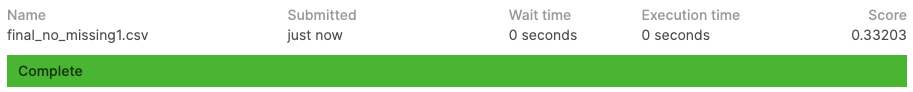

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.to_csv('final_no_missing1_lr.csv')

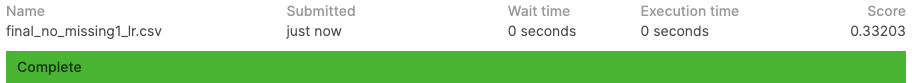

In [246]:
reg_xgb = GridSearchCV(estimator=xgb.XGBRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)


reg_xgb.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_xgb.predict(test_f[predictors])
predictions.to_csv('final_no_missing1_xgb.csv')

[16:12:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


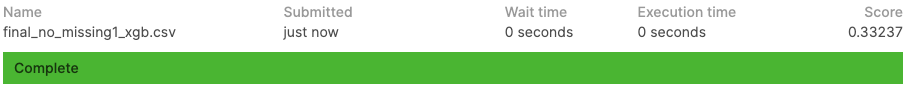

### Predictor Set 2

In [0]:
predictors=['O3','PM10','PM25','NO2_log','T2M']

In [151]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.23978990190465566
Avg. RMSE Ridge: 0.23979481155770332
Avg. RMSE Lasso: 0.2903495843194669
Avg. RMSE RF: 0.24867171177165


In [248]:
xgbr(X[predictors],y)

[16:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.22703819137440165


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing2.csv')

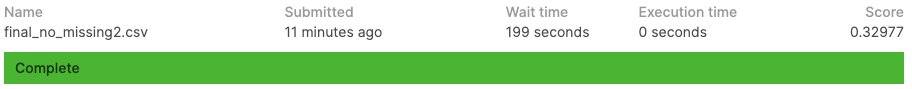

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.to_csv('final_no_missing2_lr.csv')

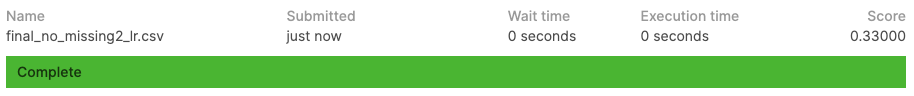

In [249]:
reg_xgb = GridSearchCV(estimator=xgb.XGBRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)


reg_xgb.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_xgb.predict(test_f[predictors])
predictions.to_csv('final_no_missing2_xgb.csv')

[16:14:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


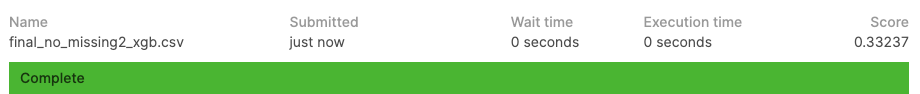

### Predictor Set 3

In [0]:
predictors=['O3','PM10','PM25_log','NO2_log','T2M']

In [251]:
xgbr(X[predictors],y)

[16:14:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.22703879408241537


In [156]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.23971446468123325
Avg. RMSE Ridge: 0.23972301032132903
Avg. RMSE Lasso: 0.2903495843194669
Avg. RMSE RF: 0.24867171177165


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing3.csv')

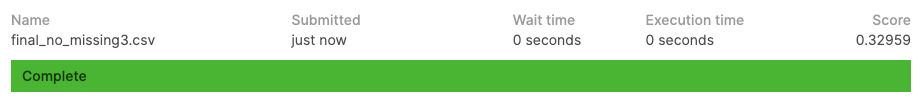

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.to_csv('final_no_missing3_lr.csv')

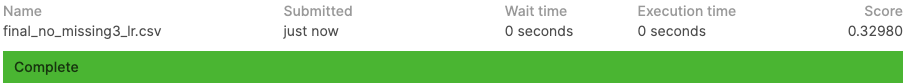

In [252]:
reg_xgb = GridSearchCV(estimator=xgb.XGBRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)


reg_xgb.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_xgb.predict(test_f[predictors])
predictions.to_csv('final_no_missing3_xgb.csv')

[16:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


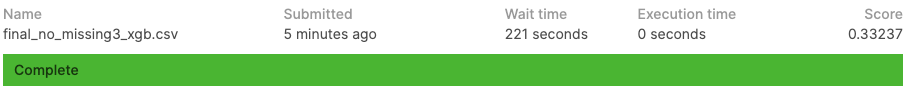

### Predictor Set 4

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M']

In [254]:
xgbr(X[predictors],y)

[16:16:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.22705045093356274


In [159]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.2395985399395797
Avg. RMSE Ridge: 0.2396076160739517
Avg. RMSE Lasso: 0.2903495843194669
Avg. RMSE RF: 0.24867171177165


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing4.csv')

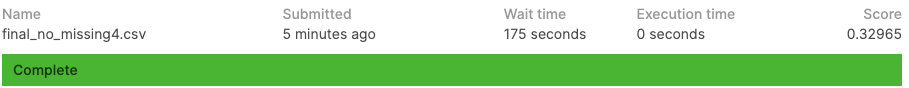

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.to_csv('final_no_missing4_lr.csv')

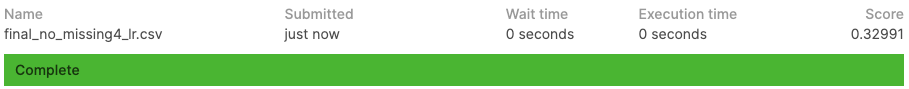

In [255]:
reg_xgb = GridSearchCV(estimator=xgb.XGBRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)


reg_xgb.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_xgb.predict(test_f[predictors])
predictions.to_csv('final_no_missing4_xgb.csv')

[16:17:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


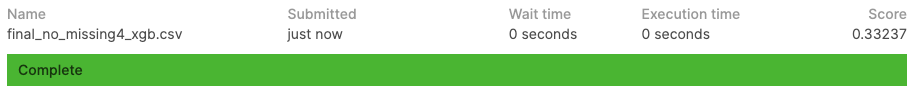

### Predictor Set 5

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling']

In [257]:
xgbr(X[predictors],y)

[16:17:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2111156255713247


In [162]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.22305394221823371
Avg. RMSE Ridge: 0.22306500419210917
Avg. RMSE Lasso: 0.2903495843194669
Avg. RMSE RF: 0.2380443594918228


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing5.csv')

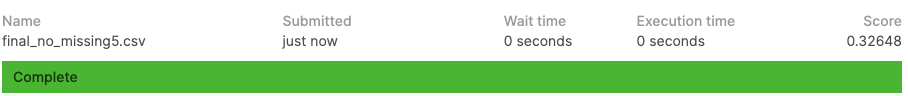

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.to_csv('final_no_missing5_lr.csv')

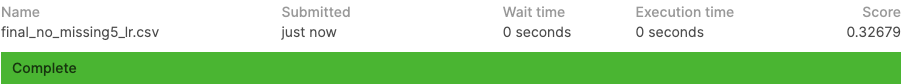

In [258]:
reg_xgb = GridSearchCV(estimator=xgb.XGBRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)


reg_xgb.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_xgb.predict(test_f[predictors])
predictions.to_csv('final_no_missing5_xgb.csv')

[16:19:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


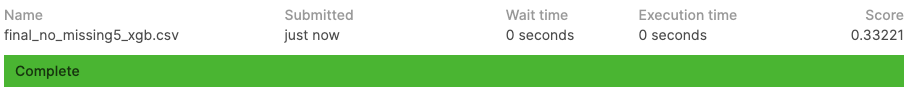

### Predictor Set 6

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling','year','year^2','doy','doy^2']

In [260]:
xgbr(X[predictors],y)

[16:19:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.1997296215310891


In [165]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.2153555933435319
Avg. RMSE Ridge: 0.21646419012373053
Avg. RMSE Lasso: 0.2892125322976449
Avg. RMSE RF: 0.23468146554038513


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing6.csv')

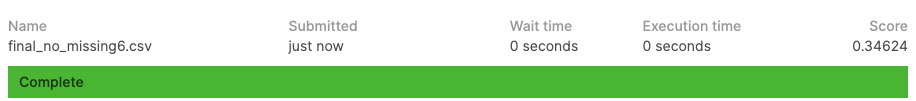

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.to_csv('final_no_missing6_lr.csv')

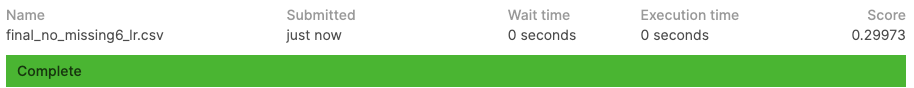

In [261]:
reg_xgb = GridSearchCV(estimator=xgb.XGBRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)


reg_xgb.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_xgb.predict(test_f[predictors])
predictions.to_csv('final_no_missing6_xgb.csv')

[16:21:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


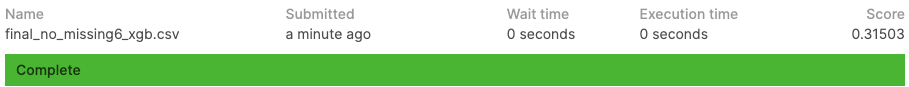

### Predictor Set 7

In [0]:
predictors=['T2M_rolling', 'year', 'year^2', 'doy', 'doy^2','E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']

In [263]:
xgbr(X[predictors],y)

[16:21:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.1724572138451691


In [168]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.17998668350427127
Avg. RMSE Ridge: 0.1806573311028001
Avg. RMSE Lasso: 0.2892125322976449
Avg. RMSE RF: 0.21158268698055097


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing7.csv')

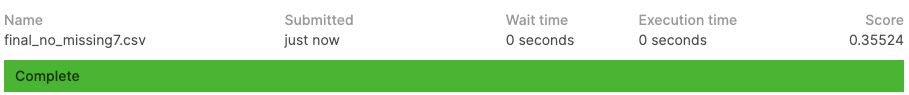

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.to_csv('final_no_missing7_lr.csv')

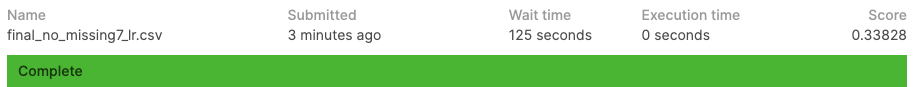

In [264]:
reg_xgb = GridSearchCV(estimator=xgb.XGBRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)


reg_xgb.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_xgb.predict(test_f[predictors])
predictions.to_csv('final_no_missing7_xgb.csv')

[16:22:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


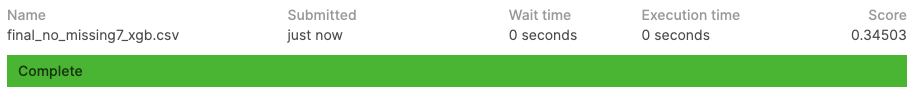

### Final Algo - mixed LR

In [0]:
a = LinearRegression()
b = LinearRegression()
c = LinearRegression()
ab = LinearRegression()

In [0]:

y0 = train_f['mortality_rate']



#modela
a_predictors = ['NO2_log', 'year', 'year^2', 'doy', 'doy^2','PM10_log']
a_X0 = train_f[a_predictors]
a.fit(a_X0, y0)



#modelb
b_predictors = [
        'T2M_rolling', 'year', 'year^2', 'doy', 'doy^2',
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
b_X0 = train_f[b_predictors]
b.fit(b_X0, y0)



#modelc
c_predictors = [
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
c_X0 = train_f[c_predictors]
c.fit(c_X0, y0)


region_effect_reduction = 0.85


# Model AB
# Produces the final solution. Combines A and "reduced B" by using their predictions as features for a linear regression.

ab_X0 = pd.DataFrame({
    'A': a.predict(a_X0),
    'reduced B': b.predict(b_X0) - (c.predict(c_X0) * region_effect_reduction)
    })

ab.fit(ab_X0, y0)

# predict

a_X1 = test_f[a_predictors]
b_X1 = test_f[b_predictors]
c_X1 = test_f[c_predictors]

ab_X1 = pd.DataFrame({'A': a.predict(a_X1),'reduced B': b.predict(b_X1) - (c.predict(c_X1) * region_effect_reduction)})

ab_y1 = ab.predict(ab_X1)



predictions = pd.DataFrame(index=test_f.index)
#predictions['mortality_rate'] =  a.predict(a_X1)
predictions['mortality_rate'] = ab_y1
predictions.to_csv('final_no_missing_final.csv')


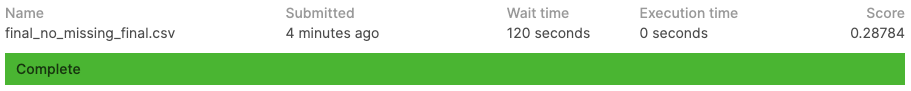

## Results
best LB socre for -(region_effect_reduction = 0.85)<br>
private score - 0.28948<br>
public score - 0.28784<br>


benchmark -<br>
private score - 0.29022<br>
public socre - 0.29259<br>

# MICE Imputation on Full Data

## Feature Engineering

In [0]:
train_f, test_f = sets(train_full_imp,test)
train_f.drop(columns='Region',inplace=True)

In [0]:
train_f, test_f = day_and_year(train_f, test_f)

In [0]:
train_f['NO2']=train_f['NO2'].apply(lambda x: f(x))
train_f['PM25']=train_f['PM25'].apply(lambda x: f(x))
train_f.isna().sum()
train_f.ffill(axis=0, inplace=True)

In [0]:
train_f, test_f = log_transform(train_f,test_f)

In [0]:
train_f, test_f = rolling(train_f,test_f)

In [175]:
train_f.shape,test_f.shape

((18142, 26), (7886, 25))

## Modelling

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(train_f.drop(['mortality_rate'],axis=1), train_f['mortality_rate'], test_size=0.2)

In [0]:
X=train_f.drop(['mortality_rate'],axis=1)
y=train_f['mortality_rate']

### Predictor Set 1

In [0]:
predictors=['O3','PM10','PM25','NO2','T2M']

In [180]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.23907842356421785
Avg. RMSE Ridge: 0.2390784180114243
Avg. RMSE Lasso: 0.30214230792878016
Avg. RMSE RF: 0.2618146995828585


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_1.csv')

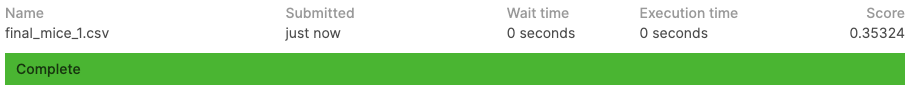

In [0]:
reg_linear = LinearRegression()
reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.index.name = 'Id'
predictions.to_csv('final_mice_1_lr.csv')

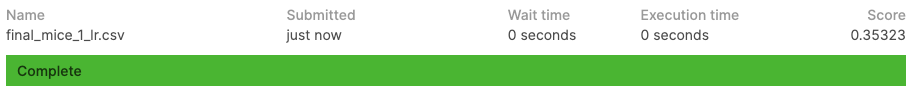

### Predictor Set 2

In [0]:
predictors=['O3','PM10','PM25','NO2_log','T2M']

In [183]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.247122122740389
Avg. RMSE Ridge: 0.24712504634683524
Avg. RMSE Lasso: 0.30214230792878016
Avg. RMSE RF: 0.2618146995828585


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_2.csv')

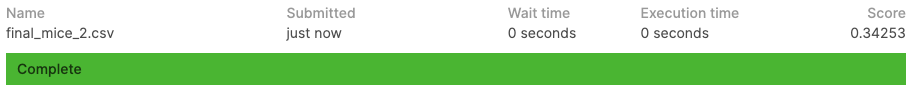

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.index.name = 'Id'
predictions.to_csv('final_mice_2_lr.csv')

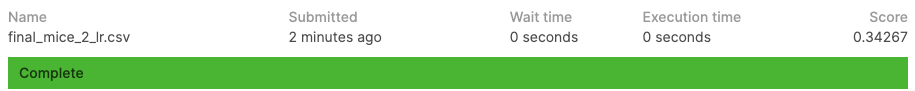

### Predictor Set 3

In [0]:
predictors=['O3','PM10','PM25_log','NO2_log','T2M']

In [186]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.24713898361722636
Avg. RMSE Ridge: 0.24714184123731536
Avg. RMSE Lasso: 0.30214230792878016
Avg. RMSE RF: 0.2618146995828585


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_3.csv')

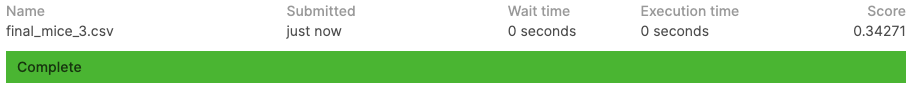

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.index.name = 'Id'
predictions.to_csv('final_mice_3_lr.csv')

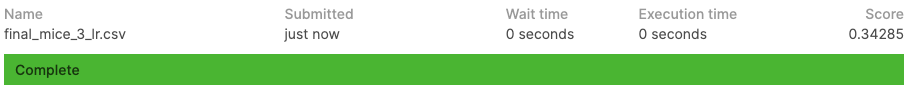

### Predictor Set 4

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M']

In [189]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.24693624715740667
Avg. RMSE Ridge: 0.24694326064013658
Avg. RMSE Lasso: 0.30214230792878016
Avg. RMSE RF: 0.2618146995828585


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_4.csv')

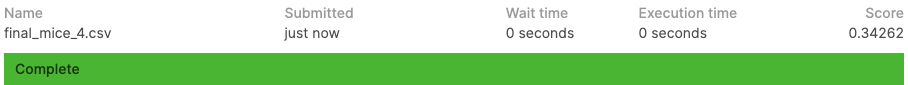

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.index.name = 'Id'
predictions.to_csv('final_mice_4_lr.csv')

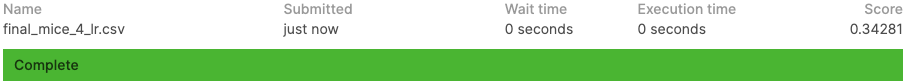

### Predictor Set 5

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling']

In [192]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.2304672120664263
Avg. RMSE Ridge: 0.23047057009916685
Avg. RMSE Lasso: 0.30214230792878016
Avg. RMSE RF: 0.25176855290941297


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_5.csv')

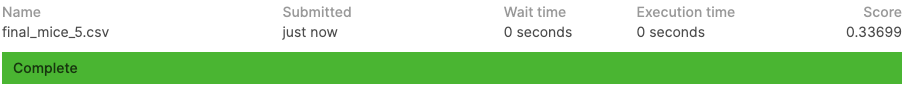

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.index.name = 'Id'
predictions.to_csv('final_mice_5_lr.csv')

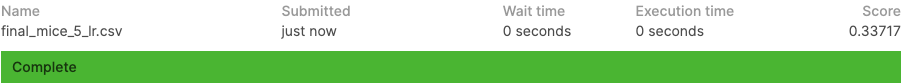

### Predictor Set 6

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling','year','year^2','doy','doy^2']

In [195]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.2183340138761394
Avg. RMSE Ridge: 0.2183624381708921
Avg. RMSE Lasso: 0.29768216146878507
Avg. RMSE RF: 0.2506971220523606


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_6.csv')

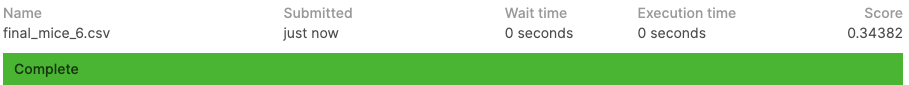

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.index.name = 'Id'
predictions.to_csv('final_mice_6_lr.csv')

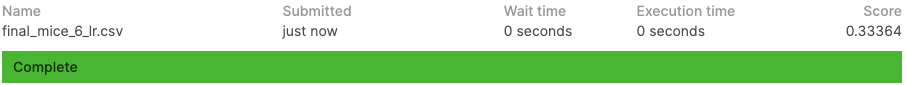

### Predictor Set 7

In [0]:
predictors=['T2M_rolling', 'year', 'year^2', 'doy', 'doy^2','E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']

In [198]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.18419424843955814
Avg. RMSE Ridge: 0.18444395074395964
Avg. RMSE Lasso: 0.29768216146878507
Avg. RMSE RF: 0.22680189553780075


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_7.csv')

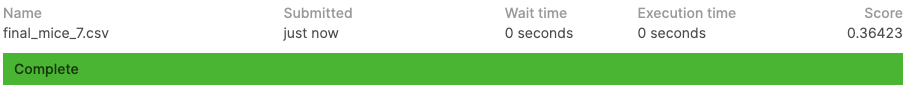

In [0]:
reg_linear = LinearRegression()

reg_linear.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_linear.predict(test_f[predictors])
predictions.index.name = 'Id'
predictions.to_csv('final_mice_7_lr.csv')

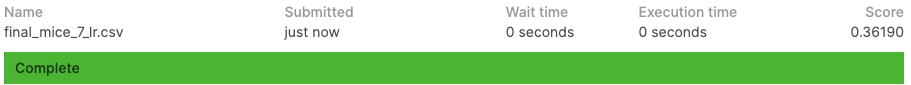

### Final Algo - mixed LR


Notation:
X0 - training predictors
y0 - training target
X1 - test predictors
y1 - predictions


In [0]:
a = LinearRegression()
b = LinearRegression()
c = LinearRegression()
ab = LinearRegression()

In [0]:

y0 = train_f['mortality_rate']



#modela
a_predictors = ['NO2_log', 'year', 'year^2', 'doy', 'doy^2','PM10_log']
a_X0 = train_f[a_predictors]
a.fit(a_X0, y0)



#modelb
b_predictors = [
        'T2M_rolling', 'year', 'year^2', 'doy', 'doy^2',
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
b_X0 = train_f[b_predictors]
b.fit(b_X0, y0)



#modelc
c_predictors = [
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
c_X0 = train_f[c_predictors]
c.fit(c_X0, y0)


region_effect_reduction = 0.85


# Model AB
# Produces the final solution. Combines A and "reduced B" by using their predictions as features for a linear regression.

ab_X0 = pd.DataFrame({
    'A': a.predict(a_X0),
    'reduced B': b.predict(b_X0) - (c.predict(c_X0) * region_effect_reduction)
    })

ab.fit(ab_X0, y0)

# predict

a_X1 = test_f[a_predictors]
b_X1 = test_f[b_predictors]
c_X1 = test_f[c_predictors]

ab_X1 = pd.DataFrame({'A': a.predict(a_X1),'reduced B': b.predict(b_X1) - (c.predict(c_X1) * region_effect_reduction)})

ab_y1 = ab.predict(ab_X1)



predictions = pd.DataFrame(index=test_f.index)
#predictions['mortality_rate'] =  a.predict(a_X1)
predictions['mortality_rate'] = ab_y1
predictions.index.name = 'Id'
predictions.to_csv('final_mice_final.csv')


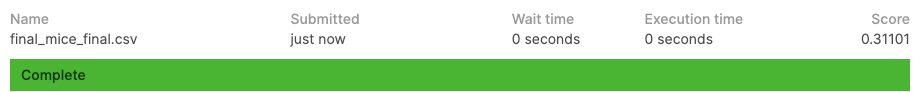

# Modelling After KNN On Full Data

In [0]:
train_f, test_f = sets(train_knn, test)

In [0]:
train_f, test_f = day_and_year(train_f, test_f)

In [0]:
train_f, test_f = log_transform(train_f,test_f)

In [0]:
train_f, test_f = rolling(train_f,test_f)

In [118]:
train_f.shape,test_f.shape

((18142, 29), (7886, 28))

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(train_f.drop(['mortality_rate'],axis=1), train_f['mortality_rate'], test_size=0.2)

In [0]:
RMSE= make_scorer(metrics.mean_squared_error)

In [0]:
X=train_f.drop(['mortality_rate'],axis=1)
y=train_f['mortality_rate']

In [0]:
#X[predictors].head()

### Predictor Set 1

In [0]:
predictors=['O3','PM10','PM25','NO2','T2M']

In [516]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09127828858367296
Avg. RMSE Ridge: 0.0639516765821944
Avg. RMSE Lasso: 0.09127828858367296
Avg. RMSE RF: 0.06883624088258992


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_knn1.csv')

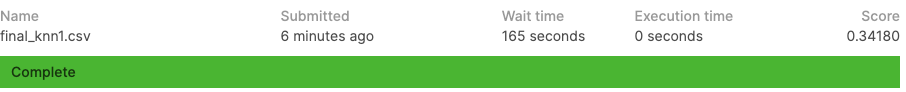

### Predictor Set 2

In [0]:
predictors=['O3','PM10','PM25','NO2_log','T2M']

In [519]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09127828858367296
Avg. RMSE Ridge: 0.06596550547145678
Avg. RMSE Lasso: 0.09127828858367296
Avg. RMSE RF: 0.06883632656115052


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_knn2.csv')

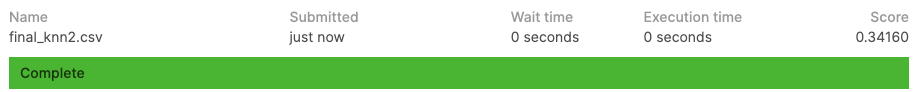

### Predictor Set 3

In [0]:
predictors=['O3','PM10','PM25_log','NO2_log','T2M']

In [522]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09127828858367296
Avg. RMSE Ridge: 0.06593501493610432
Avg. RMSE Lasso: 0.09127828858367296
Avg. RMSE RF: 0.06883632656115052


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_knn3.csv')

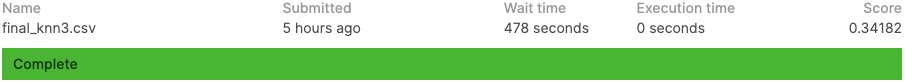

### Predictor Set 4

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M']

In [525]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09127828858367296
Avg. RMSE Ridge: 0.06593202279191875
Avg. RMSE Lasso: 0.09127828858367296
Avg. RMSE RF: 0.06883632656115052


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_knn4.csv')

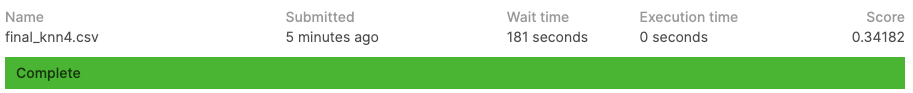

### Predictor Set 5

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling']

In [125]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09127828858367296
Avg. RMSE Ridge: 0.057773228610911
Avg. RMSE Lasso: 0.09127828858367296
Avg. RMSE RF: 0.06334060881614285


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_knn5.csv')

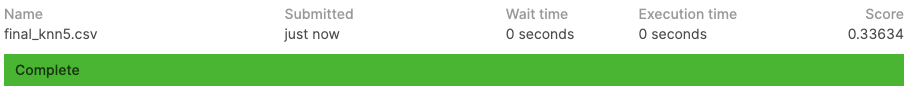

### Predictor Set 6

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling','year','year^2','doy','doy^2']

In [128]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08858483784089531
Avg. RMSE Ridge: 0.05048905403780761
Avg. RMSE Lasso: 0.08858483784089531
Avg. RMSE RF: 0.06281798428486708


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_knn6.csv')

### Predictor Set 7

In [0]:
predictors=['T2M_rolling', 'year', 'year^2', 'doy', 'doy^2','E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']

In [131]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08858483784089531
Avg. RMSE Ridge: 0.034028958081879265
Avg. RMSE Lasso: 0.08858483784089531
Avg. RMSE RF: 0.05137000304451307


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_knn7.csv')

### Final Algo - mixed LR

In [0]:
a = LinearRegression()
b = LinearRegression()
c = LinearRegression()
ab = LinearRegression()

In [0]:

y0 = train_f['mortality_rate']



#modela
a_predictors = ['NO2_log', 'year', 'year^2', 'doy', 'doy^2','PM10_log']
a_X0 = train_f[a_predictors]
a.fit(a_X0, y0)



#modelb
b_predictors = [
        'T2M_rolling', 'year', 'year^2', 'doy', 'doy^2',
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
b_X0 = train_f[b_predictors]
b.fit(b_X0, y0)



#modelc
c_predictors = [
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
c_X0 = train_f[c_predictors]
c.fit(c_X0, y0)


region_effect_reduction = 0.85


# Model AB
# Produces the final solution. Combines A and "reduced B" by using their predictions as features for a linear regression.

ab_X0 = pd.DataFrame({
    'A': a.predict(a_X0),
    'reduced B': b.predict(b_X0) - (c.predict(c_X0) * region_effect_reduction)
    })

ab.fit(ab_X0, y0)

# predict

a_X1 = test_f[a_predictors]
b_X1 = test_f[b_predictors]
c_X1 = test_f[c_predictors]

ab_X1 = pd.DataFrame({'A': a.predict(a_X1),'reduced B': b.predict(b_X1) - (c.predict(c_X1) * region_effect_reduction)})

ab_y1 = ab.predict(ab_X1)



predictions = pd.DataFrame(index=test_f.index)
#predictions['mortality_rate'] =  a.predict(a_X1)
predictions['mortality_rate'] = ab_y1
predictions.to_csv('final_knn_final.csv')


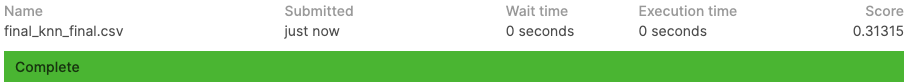